In [1]:
library(igraph)
library(utils)
library(tidyverse)
library(furrr)
library(purrr)
library(RPostgreSQL)
library(dbplyr)
library(FactoMineR)
library(factoextra)
library(corrplot)
require(scales)
library(caret)
library(gridExtra)
library(grid)
library(ggridges)
library(ggthemes)
theme_set(theme_minimal())
library(vcd)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ dplyr::filter()        masks stats::filter()
✖ dplyr::groups()        masks igraph::groups()
✖ dplyr::lag()           masks stats::lag()
✖ purrr::simplify()      masks igraph::simplify()

Loading required package: future


Attaching package: ‘future’


The following objects are masked from ‘package:igraph’:

    %->%, %<-%


Loadin

In [2]:
subnetworks=c("II","V","X","IX","VIII")

In [3]:
con = dbConnect(PostgreSQL(),dbname = 'yourdb', 
                 host = 'yourhost',
                 port = 0000)

In [4]:
r=tbl(con,in_schema("physcogrn", "reg_class"))
tf=as_tibble(r) %>% filter(reg_class=="TF") %>% select(geneid) %>% unlist(.,use.names=F)
length(tf)

[1] 979

In [5]:
a=read_delim("../GENIE3.top10_target_ranks.ranked_regulator_target_interactions.with_communities.correlations_and_directionality.tsv.gz",delim="\t")
nrow(a)
a=a[a$community %in% c(0,as.character(as.roman(1:11))),]
l=c("0",as.character(as.roman(1:11)))
a=transform(a,regulator_community=factor(a$regulator_community,levels=l),target_community=factor(a$target_community,levels=l))
nrow(a)
a=droplevels(a %>% filter(regulatoryGene %in% tf & target_community %in% subnetworks))

nrow(a)

head(a)
table(a$community)

Parsed with column specification:
cols(
  regulatoryGene = col_character(),
  targetGene = col_character(),
  full_cor = col_double(),
  full_reg = col_character(),
  our_cor = col_double(),
  our_reg = col_character(),
  weight = col_double(),
  regulator_rank = col_double(),
  target_rank = col_double(),
  mutual_rank = col_double(),
  regulator_community = col_character(),
  target_community = col_character(),
  community = col_character()
)



[1] 356457

[1] 356390

[1] 123335

regulatoryGene   targetGene                 full_cor   full_reg our_cor      
1 Pp3c4_31920.mRNA Pp3c13_21080.mRNA           0.1577695 +        -4.337281e-16
2 Pp3c4_350.mRNA   Pp3c3_28370.C_D_box_snoRNA  1.0000000 +         1.000000e+00
3 Pp3c12_10.mRNA   Pp3c1_12760.mRNA           -0.1279099 -         1.873743e-15
4 Pp3c1_21610.mRNA Pp3s178_40.mRNA             0.2570535 +         2.713689e-16
5 Pp3c1_32440.mRNA Pp3c7_19620.mRNA            0.7938397 +         6.887235e-01
6 Pp3c2_9700.mRNA  Pp3c5_14180.mRNA            0.1967969 +        -2.155251e-15
  our_reg weight     regulator_rank target_rank mutual_rank regulator_community
1 -       0.06337407 1              1           1           II                 
2 +       0.05976139 1              1           1           II                 
3 +       0.05927444 1              1           1           V                  
4 +       0.05903109 1              1           1           II                 
5 +       0.05734152 1              1           1           II                 
6 -       0.05491606 1              1           1           II                 
  target_community community
1 II               II       
2 II               II       
3 V                V        
4 II               II       
5 II               II       
6 II               II


    0    II    IX     V  VIII     X 
51095 17231 16298 10140 13935 14636 

In [6]:
n=read_delim("../GENIE3.top10_target_ranks.communities_PLM.with_node_centralities.csv",delim=";")
n=n[n$community %in% c(0,as.character(as.roman(1:11))),]
n=transform(n,community=factor(n$community,levels=l[-1]))
n=droplevels(n %>% filter(geneid %in% union(a$regulatoryGene,a$targetGene)))
head(n)
table(n$community)

Parsed with column specification:
cols(
  geneid = col_character(),
  community = col_character(),
  degree_centrality = col_double(),
  betweenness_centrality = col_double(),
  eigenvector_centrality = col_double(),
  local_reaching_centrality = col_double(),
  centrality_rank = col_double()
)



geneid            community degree_centrality betweenness_centrality
1 Pp3c27_3080.mRNA  I         109                   0                 
2 Pp3c11_23290.mRNA I         552                3190                 
3 Pp3c7_2300.mRNA   I         505                7529                 
4 Pp3c17_23620.mRNA I         490                1988                 
5 Pp3c16_13280.mRNA I         485                9982                 
6 Pp3c8_6080.mRNA   I         451               32391                 
  eigenvector_centrality local_reaching_centrality centrality_rank
1 0.00000000             0.9977499                 1              
2 0.05359921             0.9971070                 2              
3 0.02518149             0.9971070                 3              
4 0.05419710             0.9971070                 4              
5 0.05634423             0.9971070                 5              
6 0.03267935             0.9971070                 7


   I   II  III   IV    V   VI  VII VIII   IX    X   XI 
 117 4418   77   79 3434   45   58 3661 6154 2403   65 

In [7]:
#syntax file to make file is in data/dge_analysis
p=read_delim(gzfile("../DEK1_study.DEGs.minimal_info.tsv.gz"),delim="\t",col_types=cols())  %>% 
    select(1,8:9,12,30:31,34,52:53,56) %>%
    rowwise() %>%
    mutate( deregulation= sum(abs(deltaDEK_vs_OE.b_wt),abs(WT_vs_deltaDEK.b_wt),abs(WT_vs_OE.b_wt))) %>%
    mutate( effect_size= sum(abs(deltaDEK_vs_OE.test_stat_lrt),abs(WT_vs_deltaDEK.test_stat_lrt),abs(WT_vs_OE.test_stat_lrt))) %>%
    mutate( is_significant= (deltaDEK_vs_OE.qval_lrt<0.1 | WT_vs_OE.qval_lrt) & WT_vs_deltaDEK.qval_lrt<0.1) %>%
    ungroup() %>%
    select (geneid,deregulation,effect_size,is_significant) %>%
    filter(geneid %in% n$geneid)
p[!is.na(p$is_significant) & (is.na(p$effect_size) & is.na(p$deregulation)),"is_significant"]=FALSE
nrow(p)
head(p)

[1] 16215

geneid           deregulation effect_size is_significant
1 Pp3c1_1000.mRNA  0.6631450    42.770694   FALSE         
2 Pp3c1_10010.mRNA 0.4157642    25.840706   FALSE         
3 Pp3c1_10040.mRNA 0.3886370    34.809445   FALSE         
4 Pp3c1_10050.mRNA 0.6477729    15.268414   FALSE         
5 Pp3c1_10080.mRNA 0.4072536    24.435037    TRUE         
6 Pp3c1_10090.mRNA 0.2063672     1.569724   FALSE

In [8]:
e=read_delim("../calpain_cleavage_prediction.cosmoss_V3.3.release.pep.ccd.NERD_classification.tsv",delim="\t",col_types=cols()) %>%
    #mutate(NERD_target= fate=="NERD" &  U1>0.9 & uncertainty<0.05) %>%
    mutate(NERD_target= fate_strict=="NERD") %>%
    #mutate(NERD_ratio=ifelse(sites_raw>0,
    #                         (tertiary_deaminated_raw+tertiary_oxidized_or_acetylated_raw+secondary_ATE_raw+secondary_peptidase_raw)/(sites_raw),
    #                         0
    #                        )) %>%
    rename(geneid="target_id") %>%
    filter(geneid %in% n$geneid)
head(e)

geneid            id               sites_raw len tertiary_deaminated_raw
1 Pp3c10_10040.mRNA Pp3c10_10040V3.3 63        472 7                      
2 Pp3c10_10090.mRNA Pp3c10_10090V3.1 13         56 2                      
3 Pp3c10_10130.mRNA Pp3c10_10130V3.1 19        499 0                      
4 Pp3c10_10170.mRNA Pp3c10_10170V3.1  1         35 0                      
5 Pp3c10_10200.mRNA Pp3c10_10200V3.3 13        169 0                      
6 Pp3c10_10220.mRNA Pp3c10_10220V3.1 31        748 3                      
  tertiary_oxidized_or_acetylated_raw secondary_ATE_raw secondary_peptidase_raw
1 0                                   0                 11                     
2 0                                   1                  6                     
3 0                                   0                  3                     
4 0                                   0                  1                     
5 0                                   0                  2                     
6 0                                   1                  5                     
  primary_acetylated_raw ratio      ⋯ secondary_peptidase_rel
1 40                     0.13347458 ⋯ 0.023305085            
2  4                     0.23214286 ⋯ 0.107142857            
3 16                     0.03807615 ⋯ 0.006012024            
4  0                     0.02857143 ⋯ 0.028571429            
5 10                     0.07692308 ⋯ 0.011834320            
6 19                     0.04144385 ⋯ 0.006684492            
  primary_acetylated_rel clust uncertainty  U1           U2          
1 0.08474576             1     5.693259e-05 9.999431e-01 5.691329e-05
2 0.07142857             2     6.172489e-05 6.172489e-05 9.999383e-01
3 0.03206413             3     2.393614e-02 2.393520e-02 9.345508e-07
4 0.00000000             1     9.508984e-04 9.990491e-01 6.720694e-05
5 0.05917160             1     7.920775e-03 9.920792e-01 2.690608e-05
6 0.02540107             3     4.333126e-03 4.333035e-03 9.034481e-08
  U3           fate  fate_strict NERD_target
1 1.930043e-08 NERD  NERD         TRUE      
2 5.138348e-87 NERD  NERD         TRUE      
3 9.760639e-01 other other       FALSE      
4 8.836915e-04 NERD  NERD         TRUE      
5 7.893869e-03 NERD  NERD         TRUE      
6 9.956669e-01 other other       FALSE

In [9]:
names(e)

[1] "geneid"                              "id"                                 
 [3] "sites_raw"                           "len"                                
 [5] "tertiary_deaminated_raw"             "tertiary_oxidized_or_acetylated_raw"
 [7] "secondary_ATE_raw"                   "secondary_peptidase_raw"            
 [9] "primary_acetylated_raw"              "ratio"                              
[11] "lratio"                              "SLC"                                
[13] "sites_rel"                           "tertiary_deaminated_rel"            
[15] "tertiary_oxidized_or_acetylated_rel" "secondary_ATE_rel"                  
[17] "secondary_peptidase_rel"             "primary_acetylated_rel"             
[19] "clust"                               "uncertainty"                        
[21] "U1"                                  "U2"                                 
[23] "U3"                                  "fate"                               
[25] "fate_strict"                         "NERD_target"

In [10]:
P=left_join(n,e %>% select(geneid,NERD_target,
                           SLC,sites_rel,
                           tertiary_deaminated_rel,tertiary_oxidized_or_acetylated_rel,
                           secondary_ATE_rel,secondary_peptidase_rel,primary_acetylated_rel
                          ),by="geneid") %>% 
    mutate(NERD_target=ifelse(is.na(NERD_target),FALSE,NERD_target))
nrow(P)
P=right_join(p,P,by="geneid") 
table(P$effect_size>0)
table(P$deregulation>0)
P=P %>% 
    replace_na(list(
        deregulation=0,
        effect_size=0,
        is_significant=FALSE,
        NERD_target=FALSE
    ))
table(P$effect_size>0)
table(P$deregulation>0)
table(P$NERD_target)

nrow(p)
nrow(n)
nrow(P)
head(P)

[1] 20511


 TRUE 
14740 


 TRUE 
14740 


FALSE  TRUE 
 5771 14740 


FALSE  TRUE 
 5771 14740 


FALSE  TRUE 
13389  7122 

[1] 16215

[1] 20511

[1] 20511

geneid           deregulation effect_size is_significant community
1 Pp3c1_1000.mRNA  0.6631450    42.770694   FALSE          VIII     
2 Pp3c1_10010.mRNA 0.4157642    25.840706   FALSE          VIII     
3 Pp3c1_10040.mRNA 0.3886370    34.809445   FALSE          IX       
4 Pp3c1_10050.mRNA 0.6477729    15.268414   FALSE          IX       
5 Pp3c1_10080.mRNA 0.4072536    24.435037    TRUE          VIII     
6 Pp3c1_10090.mRNA 0.2063672     1.569724   FALSE          VIII     
  degree_centrality betweenness_centrality eigenvector_centrality
1 0                 0                      0.0218658786          
2 0                 0                      0.0156725382          
3 0                 0                      0.0028652419          
4 0                 0                      0.0007250114          
5 0                 0                      0.0110877665          
6 0                 0                      0.0188438642          
  local_reaching_centrality centrality_rank NERD_target SLC sites_rel 
1 0                          801            FALSE       S3  0.06459948
2 0                         1155            FALSE       S2  0.03943218
3 0                         3978            FALSE       S3  0.04273504
4 0                         5542            FALSE       S2  0.03076923
5 0                         1571            FALSE       S3  0.05497382
6 0                          952            FALSE       S2  0.03783784
  tertiary_deaminated_rel tertiary_oxidized_or_acetylated_rel secondary_ATE_rel
1 0.000000000             0                                   0.000000000      
2 0.004731861             0                                   0.001577287      
3 0.000000000             0                                   0.005698006      
4 0.000000000             0                                   0.000000000      
5 0.000000000             0                                   0.000000000      
6 0.001801802             0                                   0.001801802      
  secondary_peptidase_rel primary_acetylated_rel
1 0.015503876             0.04134367            
2 0.003154574             0.02208202            
3 0.008547009             0.02564103            
4 0.015384615             0.01538462            
5 0.018324607             0.03403141            
6 0.007207207             0.02522523

In [11]:
nrow(P)
P=P %>% filter(is_significant | NERD_target | community %in% subnetworks) 
nrow(P)
nrow(a)
a=a %>% filter(regulatoryGene %in% P$geneid & target_community %in% subnetworks )
nrow(a)

[1] 20511

[1] 20394

[1] 123335

[1] 117285

In [12]:
G=graph_from_data_frame(a,directed = TRUE,vertices = P)
is_weighted(G)
list.edge.attributes(G)
list.vertex.attributes(G)

[1] TRUE

[1] "full_cor"            "full_reg"            "our_cor"            
 [4] "our_reg"             "weight"              "regulator_rank"     
 [7] "target_rank"         "mutual_rank"         "regulator_community"
[10] "target_community"    "community"

[1] "name"                                "deregulation"                       
 [3] "effect_size"                         "is_significant"                     
 [5] "community"                           "degree_centrality"                  
 [7] "betweenness_centrality"              "eigenvector_centrality"             
 [9] "local_reaching_centrality"           "centrality_rank"                    
[11] "NERD_target"                         "SLC"                                
[13] "sites_rel"                           "tertiary_deaminated_rel"            
[15] "tertiary_oxidized_or_acetylated_rel" "secondary_ATE_rel"                  
[17] "secondary_peptidase_rel"             "primary_acetylated_rel"

In [13]:
col=read.csv("../subnetwork_colours.csv",stringsAsFactors=FALSE)
col$network=ordered(col$network,levels=as.character(as.roman(1:11)))
col=col[order(col$network),]
col
col2=col$colour
names(col2)=col$network
col2

network colour 
1  I       #999999
2  II      #FFE529
3  III     #5A6A99
4  IV      #FF7F00
5  V       #E486B7
6  VI      #6B886E
7  VII     #E41A1C
8  VIII    #CA9A2C
9  IX      #AD5882
10 X       #C66764
11 XI      #449B76

I        II       III        IV         V        VI       VII      VIII 
"#999999" "#FFE529" "#5A6A99" "#FF7F00" "#E486B7" "#6B886E" "#E41A1C" "#CA9A2C" 
       IX         X        XI 
"#AD5882" "#C66764" "#449B76"

In [15]:
analyzeNeighbors=function(id,max_order) {
    EG=make_ego_graph(G,nodes=id,order=max_order,mode="in")[[1]] 
    EGI=delete_vertices(EG,!(V(EG)$is_significant |V(EG)$NERD_target) & !V(EG)$name==id)
    EGE=delete_vertices(EG,!(V(EG)$is_significant) & !V(EG)$name==id)
    EGN=delete_vertices(EG,! (V(EG)$NERD_target) & !V(EG)$name==id)
    seq_len(max_order) %>% 
        map( function(i) {
            EEG=make_ego_graph(EG,nodes=id,order=i,mode="in")[[1]]
            EEG=delete_vertices(EEG,V(EEG)$name==id)
            tibble(
                geneid=id,
                order=i,
                u_deregulation=median(V(EEG)$deregulation,na.rm=TRUE),
                u_effect_size=median(V(EEG)$effect_size,na.rm=TRUE),
                u_local_reaching_centrality=median(V(EEG)$local_reaching_centrality,na.rm=TRUE),
                u_sites_rel=median(V(EEG)$sites_rel,na.rm=TRUE),
                u_tertiary_deaminated_rel=median(V(EEG)$tertiary_deaminated_rel,na.rm=TRUE),
                u_tertiary_oxidized_or_acetylated_rel=median(V(EEG)$tertiary_oxidized_or_acetylated_rel,na.rm=TRUE),
                u_secondary_ATE_rel=median(V(EEG)$secondary_ATE_rel,na.rm=TRUE),
                u_secondary_peptidase_rel=median(V(EEG)$secondary_peptidase_rel,na.rm=TRUE),
                u_primary_acetylated_rel=median(V(EEG)$primary_acetylated_rel,na.rm=TRUE),
                all_targets=ego_size(EGI,nodes=id,mode="in",order=i)-1,
                dereg_targets=ego_size(EGE,nodes=id,mode="in",order=i)-1,
                direct_targets=ego_size(EGN,nodes=id,mode="in",order=i)-1,
                upstream=ego_size(EG,nodes=id,mode="in",order=i)-1)
            }) %>%
        bind_rows() %>%
        replace_na(list(u_deregulation=0,u_effect_size=0,
                        u_local_reaching_centrality=0,u_sites_rel=0,u_tertiary_deaminated_rel=0,
                        u_tertiary_oxidized_or_acetylated_rel=0, u_secondary_ATE_rel=0,
                        u_secondary_peptidase_rel=0,u_primary_acetylated_rel=0
                       )) %>%
        mutate(
            p_all_targets=ifelse(upstream>0,all_targets/upstream,0),
            p_dereg_targets=ifelse(upstream>0,dereg_targets/upstream,0),
            p_direct_targets=ifelse(upstream>0,direct_targets/upstream,0))
}
    

In [16]:
plan(multisession, workers = 30)


In [17]:
PP= P %>% 
    select(geneid) %>% unlist(.,use.names=FALSE) %>%
    future_map(function(x) analyzeNeighbors(x,3)) %>%
    bind_rows()

In [18]:
head(PP)

geneid           order u_deregulation u_effect_size
1 Pp3c1_1000.mRNA  1     0.3469483      11.286192    
2 Pp3c1_1000.mRNA  2     0.3469483       7.730350    
3 Pp3c1_1000.mRNA  3     0.4287560      12.382109    
4 Pp3c1_10010.mRNA 1     0.2098584       8.300724    
5 Pp3c1_10010.mRNA 2     0.4024813      15.200864    
6 Pp3c1_10010.mRNA 3     0.3972395      16.296349    
  u_local_reaching_centrality u_sites_rel u_tertiary_deaminated_rel
1 0.9978148                   0.07942824  0.004638740              
2 0.9978148                   0.08762103  0.005614174              
3 0.9978148                   0.07732684  0.006232042              
4 0.9978148                   0.07777164  0.005776663              
5 0.9974051                   0.08748337  0.006827096              
6 0.9978148                   0.09179849  0.007936730              
  u_tertiary_oxidized_or_acetylated_rel u_secondary_ATE_rel
1 0                                     0.001871391        
2 0                                     0.002011615        
3 0                                     0.002123228        
4 0                                     0.001533757        
5 0                                     0.002127814        
6 0                                     0.002446239        
  u_secondary_peptidase_rel u_primary_acetylated_rel all_targets dereg_targets
1 0.01571711                0.04456619                1          0            
2 0.01727296                0.05223983                6          0            
3 0.01422493                0.04456619               12          0            
4 0.01426660                0.04338914                1          0            
5 0.01702838                0.04711449                4          0            
6 0.01683325                0.05103846               11          0            
  direct_targets upstream p_all_targets p_dereg_targets p_direct_targets
1 1               4       0.2500000     0               0.2500000       
2 5              16       0.3750000     0               0.3125000       
3 7              46       0.2608696     0               0.1521739       
4 1               4       0.2500000     0               0.2500000       
5 4              20       0.2000000     0               0.2000000       
6 8              58       0.1896552     0               0.1379310

In [19]:
PPP=droplevels(inner_join(PP,P, on="geneid"))
head(PPP)

Joining, by = "geneid"



geneid           order u_deregulation u_effect_size
1 Pp3c1_1000.mRNA  1     0.3469483      11.286192    
2 Pp3c1_1000.mRNA  2     0.3469483       7.730350    
3 Pp3c1_1000.mRNA  3     0.4287560      12.382109    
4 Pp3c1_10010.mRNA 1     0.2098584       8.300724    
5 Pp3c1_10010.mRNA 2     0.4024813      15.200864    
6 Pp3c1_10010.mRNA 3     0.3972395      16.296349    
  u_local_reaching_centrality u_sites_rel u_tertiary_deaminated_rel
1 0.9978148                   0.07942824  0.004638740              
2 0.9978148                   0.08762103  0.005614174              
3 0.9978148                   0.07732684  0.006232042              
4 0.9978148                   0.07777164  0.005776663              
5 0.9974051                   0.08748337  0.006827096              
6 0.9978148                   0.09179849  0.007936730              
  u_tertiary_oxidized_or_acetylated_rel u_secondary_ATE_rel
1 0                                     0.001871391        
2 0                                     0.002011615        
3 0                                     0.002123228        
4 0                                     0.001533757        
5 0                                     0.002127814        
6 0                                     0.002446239        
  u_secondary_peptidase_rel ⋯ local_reaching_centrality centrality_rank
1 0.01571711                ⋯ 0                          801           
2 0.01727296                ⋯ 0                          801           
3 0.01422493                ⋯ 0                          801           
4 0.01426660                ⋯ 0                         1155           
5 0.01702838                ⋯ 0                         1155           
6 0.01683325                ⋯ 0                         1155           
  NERD_target SLC sites_rel  tertiary_deaminated_rel
1 FALSE       S3  0.06459948 0.000000000            
2 FALSE       S3  0.06459948 0.000000000            
3 FALSE       S3  0.06459948 0.000000000            
4 FALSE       S2  0.03943218 0.004731861            
5 FALSE       S2  0.03943218 0.004731861            
6 FALSE       S2  0.03943218 0.004731861            
  tertiary_oxidized_or_acetylated_rel secondary_ATE_rel secondary_peptidase_rel
1 0                                   0.000000000       0.015503876            
2 0                                   0.000000000       0.015503876            
3 0                                   0.000000000       0.015503876            
4 0                                   0.001577287       0.003154574            
5 0                                   0.001577287       0.003154574            
6 0                                   0.001577287       0.003154574            
  primary_acetylated_rel
1 0.04134367            
2 0.04134367            
3 0.04134367            
4 0.02208202            
5 0.02208202            
6 0.02208202

In [20]:
fit=step(glm(is_significant~p_all_targets+p_dereg_targets+p_direct_targets+order,data =PPP))
summary(fit)

Start:  AIC=86845.16
is_significant ~ p_all_targets + p_dereg_targets + p_direct_targets + 
    order

                   Df Deviance   AIC
- p_direct_targets  1    14809 86843
<none>                   14809 86845
- p_all_targets     1    14810 86848
- order             1    14856 87036
- p_dereg_targets   1    15016 87690

Step:  AIC=86843.45
is_significant ~ p_all_targets + p_dereg_targets + order

                  Df Deviance   AIC
<none>                  14809 86843
- p_all_targets    1    14812 86854
- order            1    14865 87071
- p_dereg_targets  1    15039 87783



Call:
glm(formula = is_significant ~ p_all_targets + p_dereg_targets + 
    order, data = PPP)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7058  -0.4414  -0.3524   0.5379   0.7261  

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.276068   0.010325  26.738  < 2e-16 ***
p_all_targets   -0.043722   0.012245  -3.571 0.000356 ***
p_dereg_targets  0.348865   0.011327  30.799  < 2e-16 ***
order            0.041534   0.002736  15.181  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.2420655)

    Null deviance: 15113  on 61181  degrees of freedom
Residual deviance: 14809  on 61178  degrees of freedom
AIC: 86843

Number of Fisher Scoring iterations: 2


In [21]:
fit=step(glm(effect_size~p_all_targets+p_dereg_targets+p_direct_targets+order,data =PPP))
summary(fit)

Start:  AIC=583992
effect_size ~ p_all_targets + p_dereg_targets + p_direct_targets + 
    order

                   Df Deviance    AIC
- p_all_targets     1 50058453 583990
<none>                50058106 583992
- p_direct_targets  1 50069417 584004
- order             1 50127134 584074
- p_dereg_targets   1 50218892 584186

Step:  AIC=583990.4
effect_size ~ p_dereg_targets + p_direct_targets + order

                   Df Deviance    AIC
<none>                50058453 583990
- p_direct_targets  1 50074624 584008
- order             1 50127925 584073
- p_dereg_targets   1 50300800 584284



Call:
glm(formula = effect_size ~ p_dereg_targets + p_direct_targets + 
    order, data = PPP)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-30.67  -19.58   -6.39    4.95  366.59  

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       14.0201     0.5788  24.221  < 2e-16 ***
p_dereg_targets    9.4059     0.5465  17.210  < 2e-16 ***
p_direct_targets   2.5771     0.5797   4.446 8.78e-06 ***
order              1.5548     0.1687   9.214  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 818.2427)

    Null deviance: 50351722  on 61181  degrees of freedom
Residual deviance: 50058453  on 61178  degrees of freedom
AIC: 583990

Number of Fisher Scoring iterations: 2


In [22]:
cbind(seq_len(ncol(PPP)),names(PPP))

[,1] [,2]                                 
 [1,] 1    geneid                               
 [2,] 2    order                                
 [3,] 3    u_deregulation                       
 [4,] 4    u_effect_size                        
 [5,] 5    u_local_reaching_centrality          
 [6,] 6    u_sites_rel                          
 [7,] 7    u_tertiary_deaminated_rel            
 [8,] 8    u_tertiary_oxidized_or_acetylated_rel
 [9,] 9    u_secondary_ATE_rel                  
[10,] 10   u_secondary_peptidase_rel            
[11,] 11   u_primary_acetylated_rel             
[12,] 12   all_targets                          
[13,] 13   dereg_targets                        
[14,] 14   direct_targets                       
[15,] 15   upstream                             
[16,] 16   p_all_targets                        
[17,] 17   p_dereg_targets                      
[18,] 18   p_direct_targets                     
[19,] 19   deregulation                         
[20,] 20   effect_size                          
[21,] 21   is_significant                       
[22,] 22   community                            
[23,] 23   degree_centrality                    
[24,] 24   betweenness_centrality               
[25,] 25   eigenvector_centrality               
[26,] 26   local_reaching_centrality            
[27,] 27   centrality_rank                      
[28,] 28   NERD_target                          
[29,] 29   SLC                                  
[30,] 30   sites_rel                            
[31,] 31   tertiary_deaminated_rel              
[32,] 32   tertiary_oxidized_or_acetylated_rel  
[33,] 33   secondary_ATE_rel                    
[34,] 34   secondary_peptidase_rel              
[35,] 35   primary_acetylated_rel

In [23]:
names(PPP)[-c(1,12:15,19:20,22:35)]

[1] "order"                                
 [2] "u_deregulation"                       
 [3] "u_effect_size"                        
 [4] "u_local_reaching_centrality"          
 [5] "u_sites_rel"                          
 [6] "u_tertiary_deaminated_rel"            
 [7] "u_tertiary_oxidized_or_acetylated_rel"
 [8] "u_secondary_ATE_rel"                  
 [9] "u_secondary_peptidase_rel"            
[10] "u_primary_acetylated_rel"             
[11] "p_all_targets"                        
[12] "p_dereg_targets"                      
[13] "p_direct_targets"                     
[14] "is_significant"

In [24]:
fit_control = trainControl(method = "repeatedcv",
                           number = 5,
                           repeats = 3)
PPPP=PPP %>% select(-c(1,12:15,19:20,22:35))
rf_fit = train(factor(is_significant,levels=c("TRUE","FALSE")) ~ . , 
                 data = PPPP, #importance = 'impurity',
                  method = "rf", 
                  #preProcess = c("scale", "center"),
                  trControl = fit_control,
                  verbose = FALSE)

In [25]:
varImp(rf_fit,scale = TRUE)

rf variable importance

                                      Overall
u_effect_size                          100.00
u_deregulation                          99.72
u_secondary_peptidase_rel               96.05
u_tertiary_deaminated_rel               93.02
p_dereg_targets                         91.54
u_secondary_ATE_rel                     91.04
u_primary_acetylated_rel                89.94
u_sites_rel                             89.13
p_direct_targets                        84.21
p_all_targets                           79.89
u_local_reaching_centrality             54.16
order                                   12.31
u_tertiary_oxidized_or_acetylated_rel    0.00

In [26]:
pred=predict(rf_fit, PPPP)
confusionMatrix(pred, factor(PPPP$is_significant,levels=c("TRUE","FALSE")))

Confusion Matrix and Statistics

          Reference
Prediction  TRUE FALSE
     TRUE  25918   649
     FALSE  1334 33281
                                         
               Accuracy : 0.9676         
                 95% CI : (0.9662, 0.969)
    No Information Rate : 0.5546         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.9342         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.9510         
            Specificity : 0.9809         
         Pos Pred Value : 0.9756         
         Neg Pred Value : 0.9615         
             Prevalence : 0.4454         
         Detection Rate : 0.4236         
   Detection Prevalence : 0.4342         
      Balanced Accuracy : 0.9660         
                                         
       'Positive' Class : TRUE           
                                      

In [27]:
options(repr.plot.width=15, repr.plot.height=8)

In [28]:
rf_model_imp = varImp(rf_fit, scale = TRUE)
p1 = rf_model_imp$importance %>%
  as.data.frame() %>%
  rownames_to_column() %>%
  ggplot(aes(x = reorder(rowname, Overall), y = Overall)) +
    geom_bar(stat = "identity", fill = "#1F77B4", alpha = 0.8) +
    coord_flip()

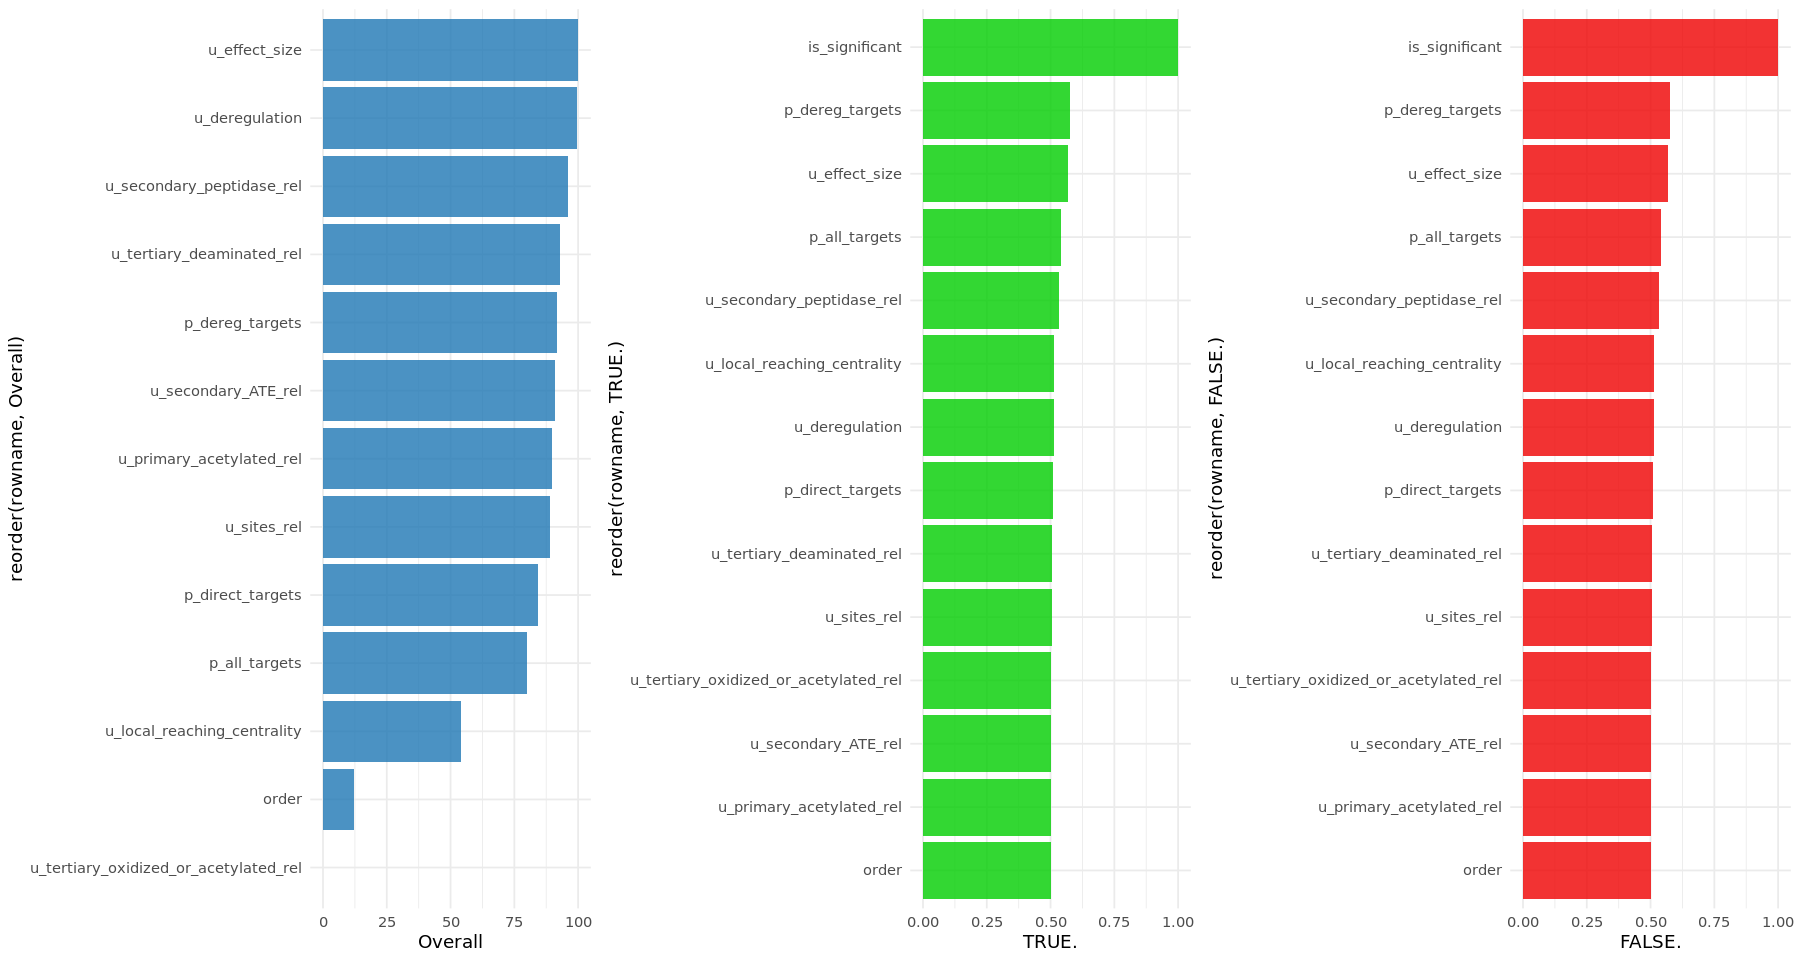

In [29]:
roc_imp = filterVarImp(x =PPPP,
                       y = factor(PPPP$is_significant,levels=c("TRUE","FALSE")))
p2 = roc_imp %>%
  as.data.frame() %>%
  rownames_to_column() %>%
  ggplot(aes(x = reorder(rowname,TRUE.), y = TRUE.)) +
    geom_bar(stat = "identity", fill = "green3", alpha = 0.8) +
    coord_flip()
p3 = roc_imp %>%
  as.data.frame() %>%
  rownames_to_column() %>%
  ggplot(aes(x = reorder(rowname,FALSE.), y = FALSE.)) +
    geom_bar(stat = "identity", fill = "red2", alpha = 0.8) +
    coord_flip()
grid.arrange(p1, p2,p3, ncol = 3)

In [30]:
options(repr.plot.width=12, repr.plot.height=7)

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'



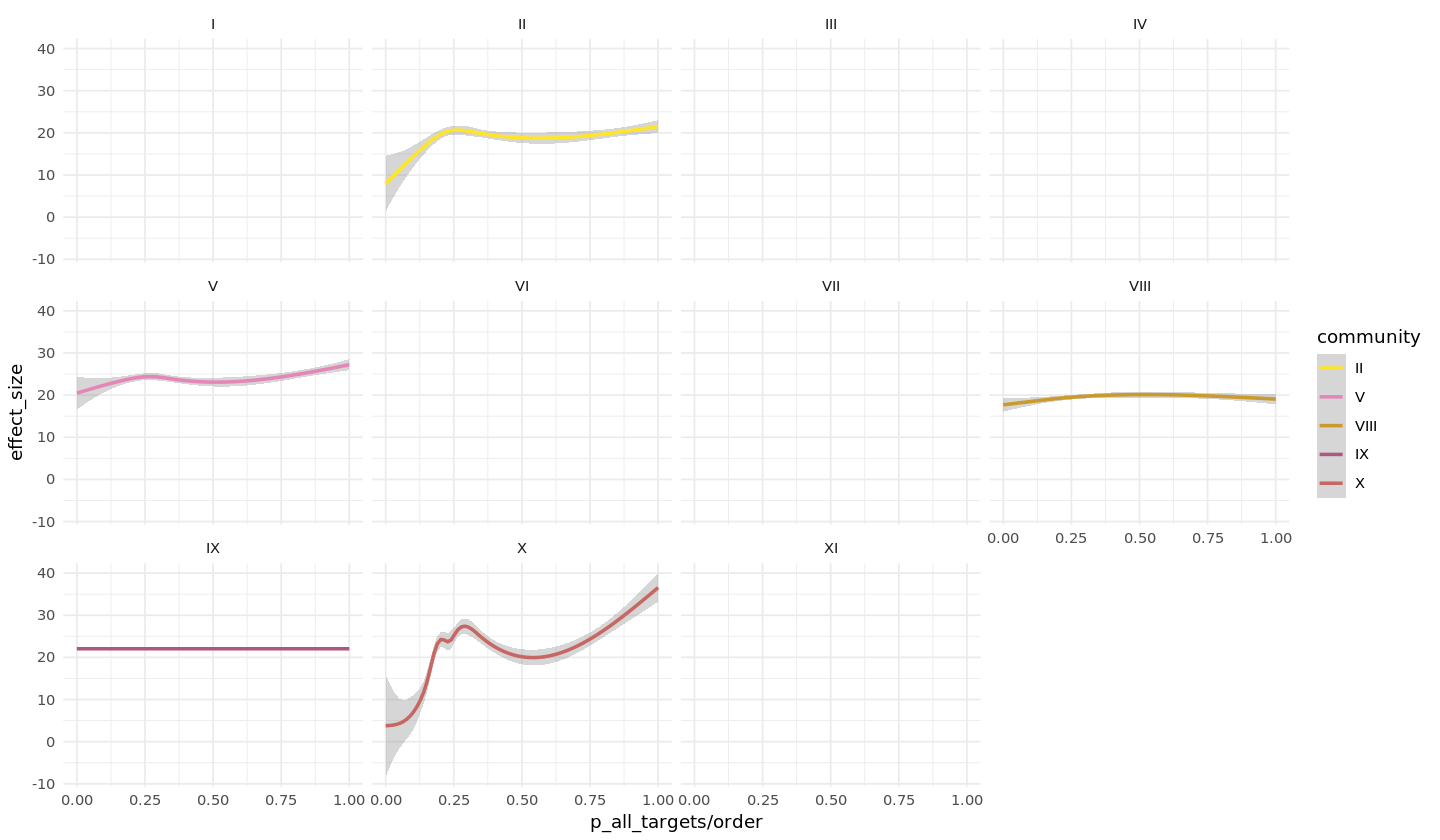

In [31]:
ggplot(PPP, aes(x=p_all_targets/order,y=effect_size,colour=community)) + facet_wrap(~community) +
geom_smooth(method="gam") +scale_colour_manual(values=col2) 

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'



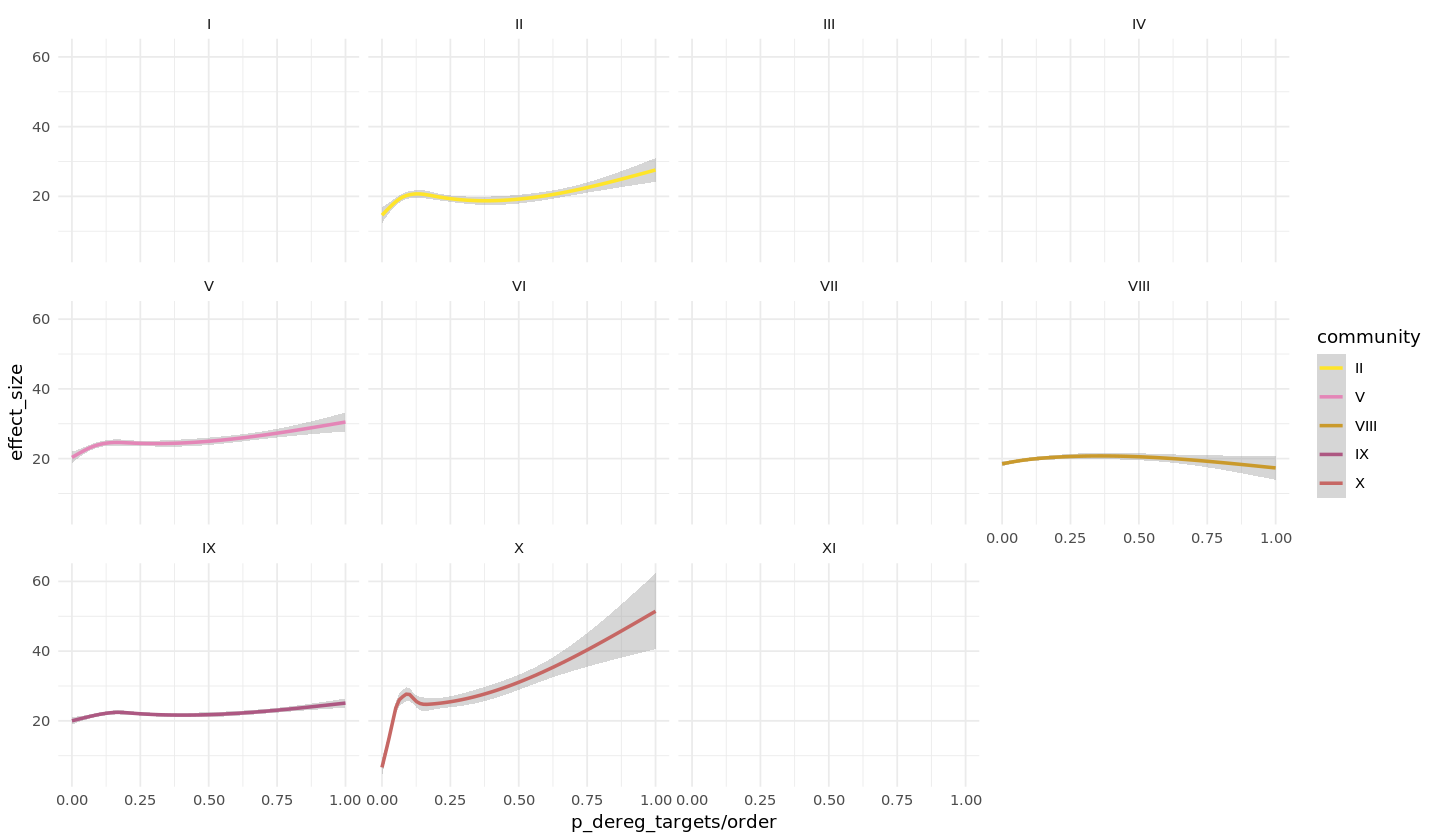

In [32]:
ggplot(PPP, aes(x=p_dereg_targets/order,y=effect_size,colour=community)) + facet_wrap(~community) +
geom_smooth(method="gam") +scale_colour_manual(values=col2) 

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'



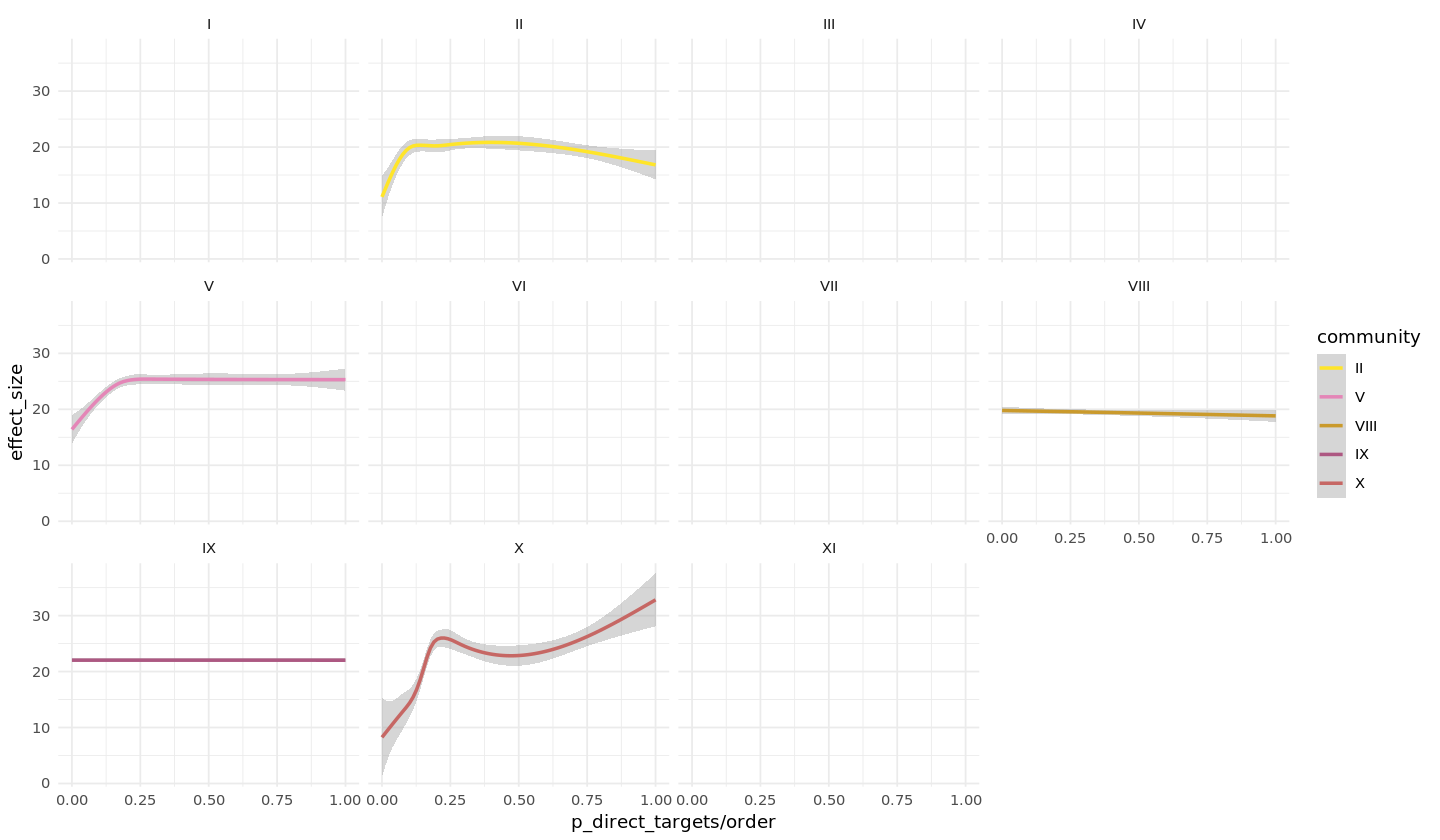

In [33]:
ggplot(PPP, aes(x=p_direct_targets/order,y=effect_size,colour=community)) + facet_wrap(~community) +
geom_smooth(method="gam") +scale_colour_manual(values=col2) 

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



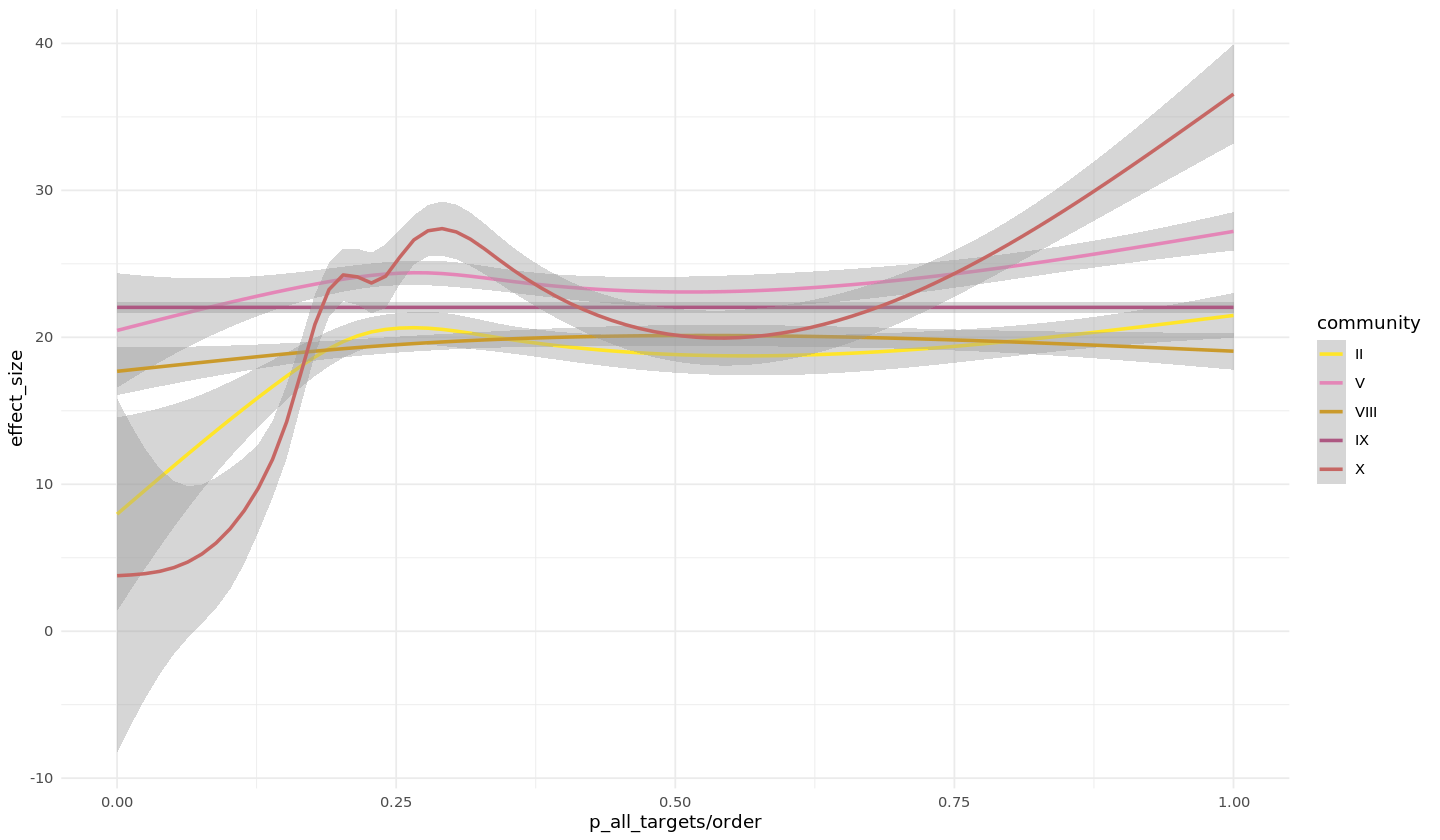

In [34]:
ggplot(PPP, aes(x=p_all_targets/order,y=effect_size,colour=community)) +
geom_smooth() +scale_colour_manual(values=col2) 

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



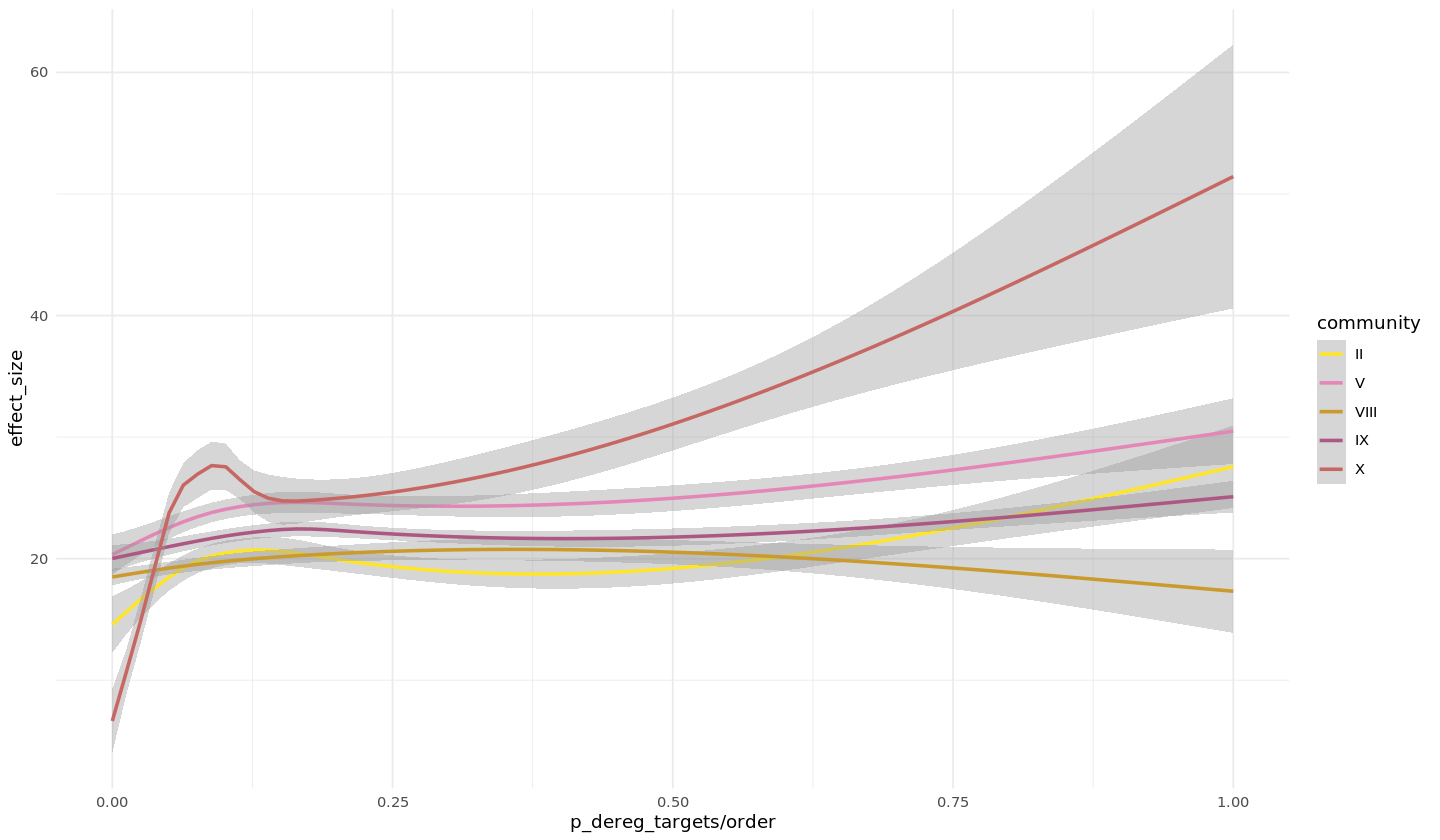

In [35]:
ggplot(PPP, aes(x=p_dereg_targets/order,y=effect_size,colour=community)) +
geom_smooth() +scale_colour_manual(values=col2) 

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'



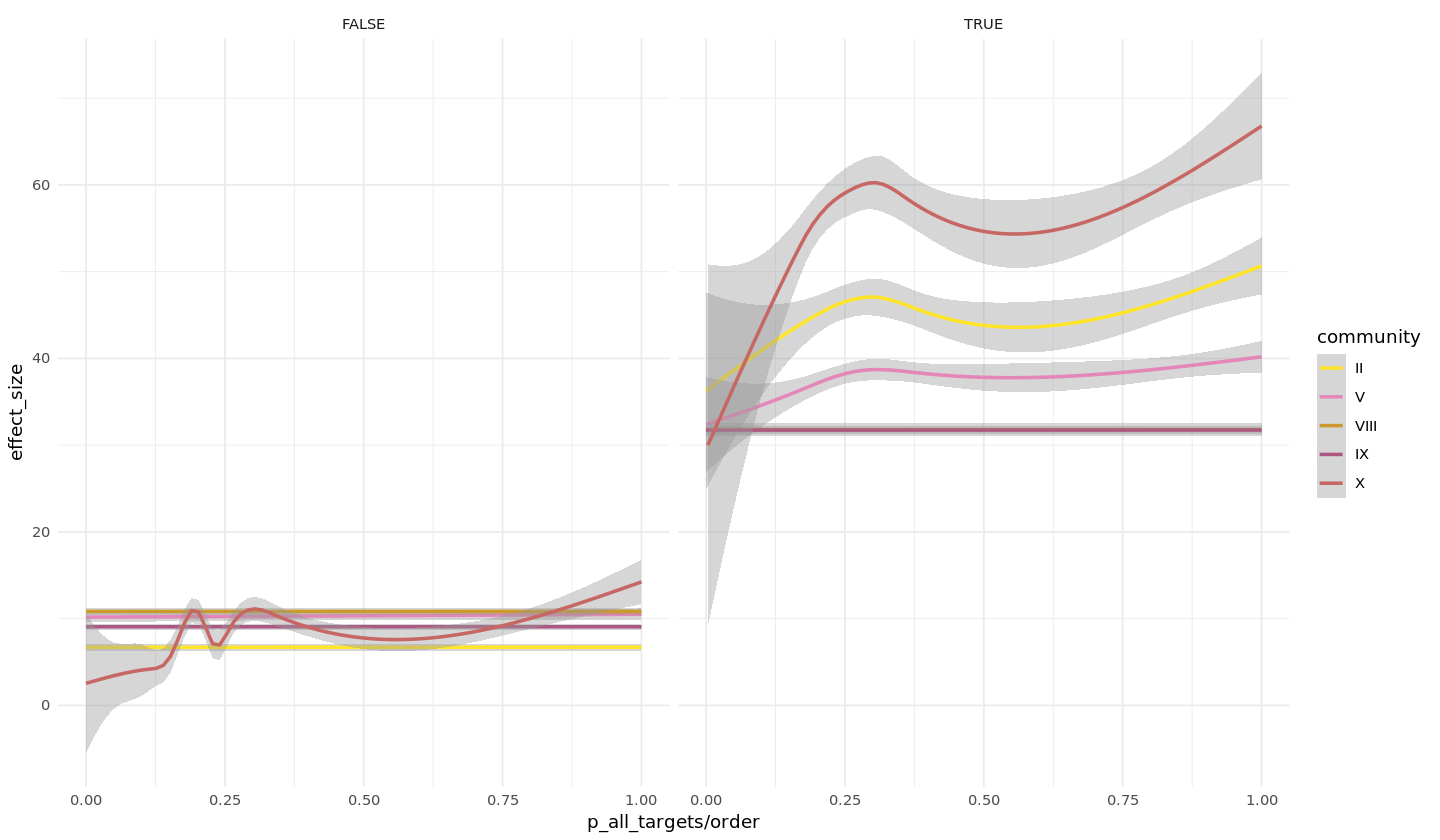

In [36]:
ggplot(PPP, aes(x=p_all_targets/order,y=effect_size,colour=community)) + facet_wrap(~is_significant) +
geom_smooth(method="gam") +scale_colour_manual(values=col2) 

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'



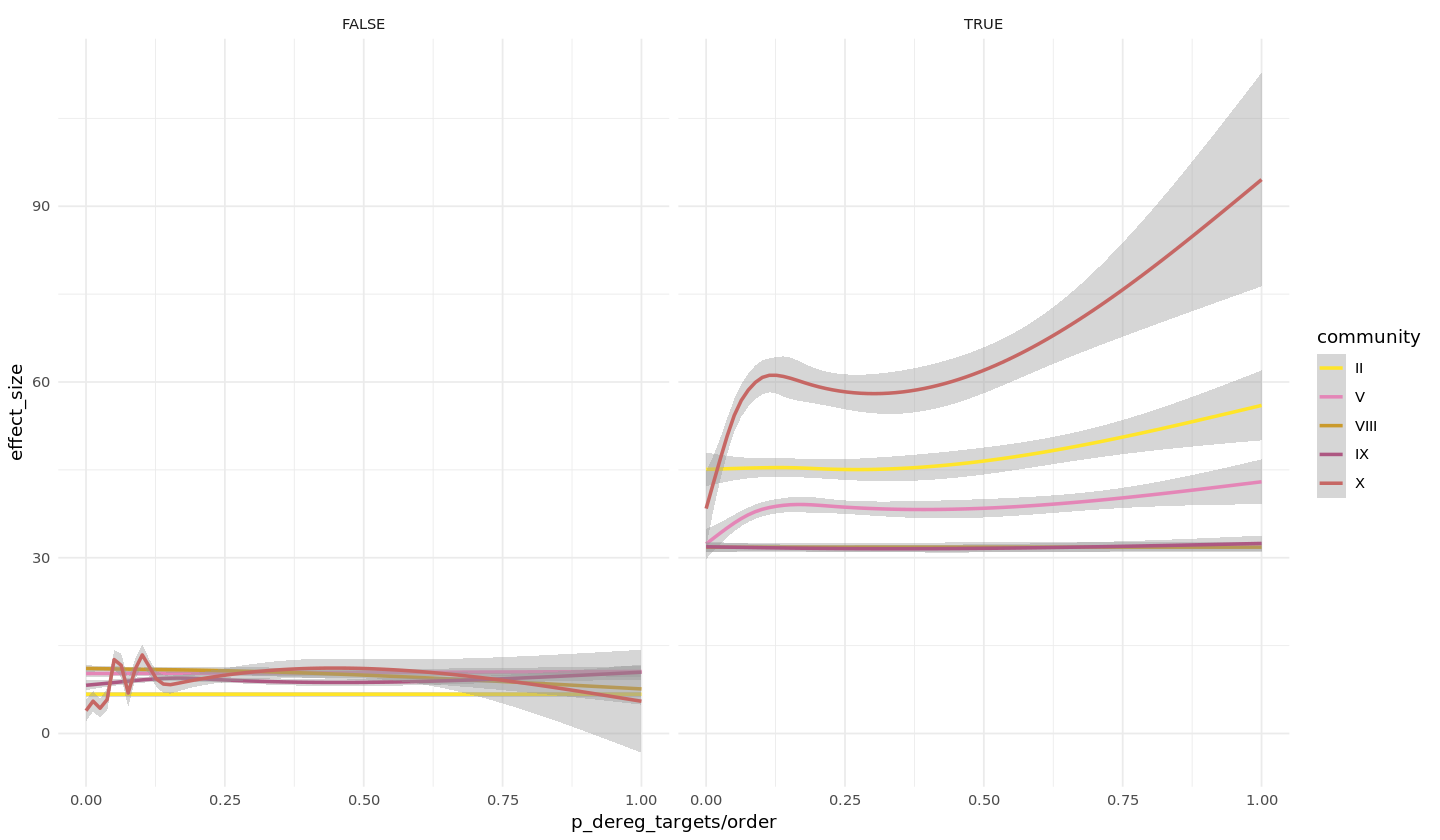

In [37]:
ggplot(PPP, aes(x=p_dereg_targets/order,y=effect_size,colour=community)) + facet_wrap(~is_significant) +
geom_smooth(method="gam") +scale_colour_manual(values=col2) 

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'



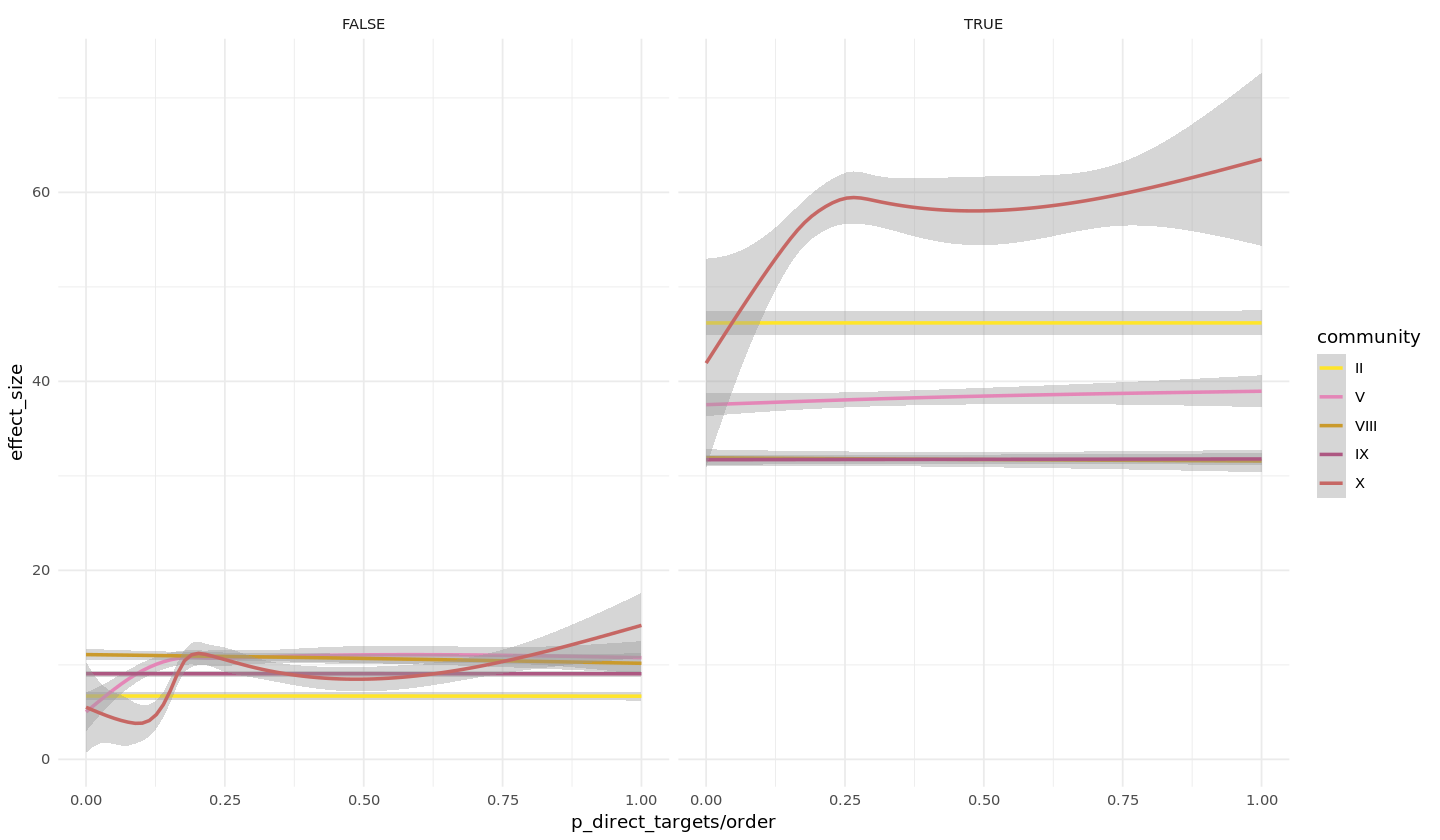

In [38]:
ggplot(PPP, aes(x=p_direct_targets/order,y=effect_size,colour=community)) + facet_wrap(~is_significant) +
geom_smooth(method="gam") +scale_colour_manual(values=col2) 

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



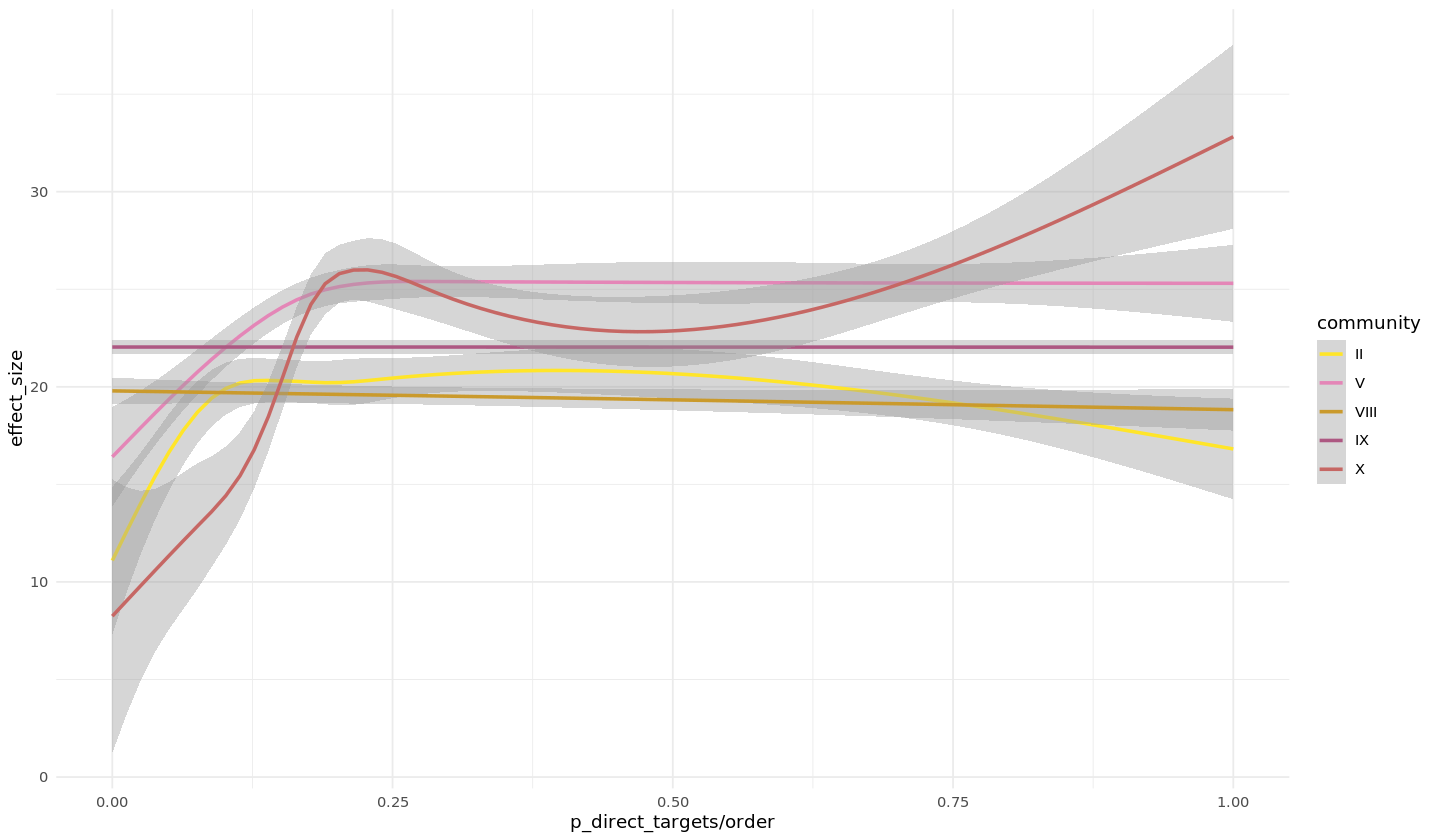

In [39]:
ggplot(PPP, aes(x=p_direct_targets/order,y=effect_size,colour=community)) +
geom_smooth() +scale_colour_manual(values=col2) 

`geom_smooth()` using formula 'y ~ x'



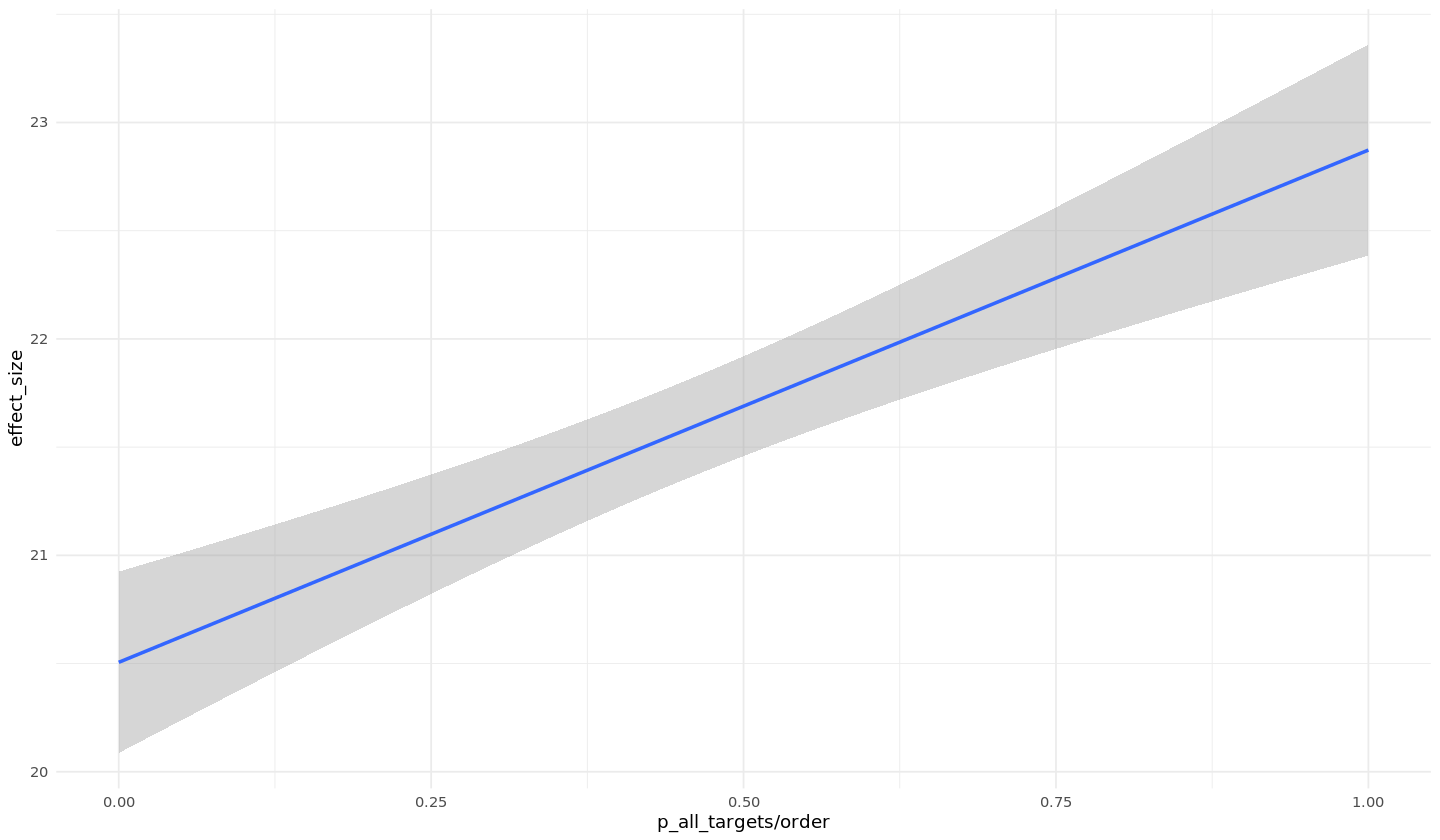

In [40]:
ggplot(PPP, aes(x=p_all_targets/order,y=effect_size)) +
geom_smooth(method="lm") 

`geom_smooth()` using formula 'y ~ x'



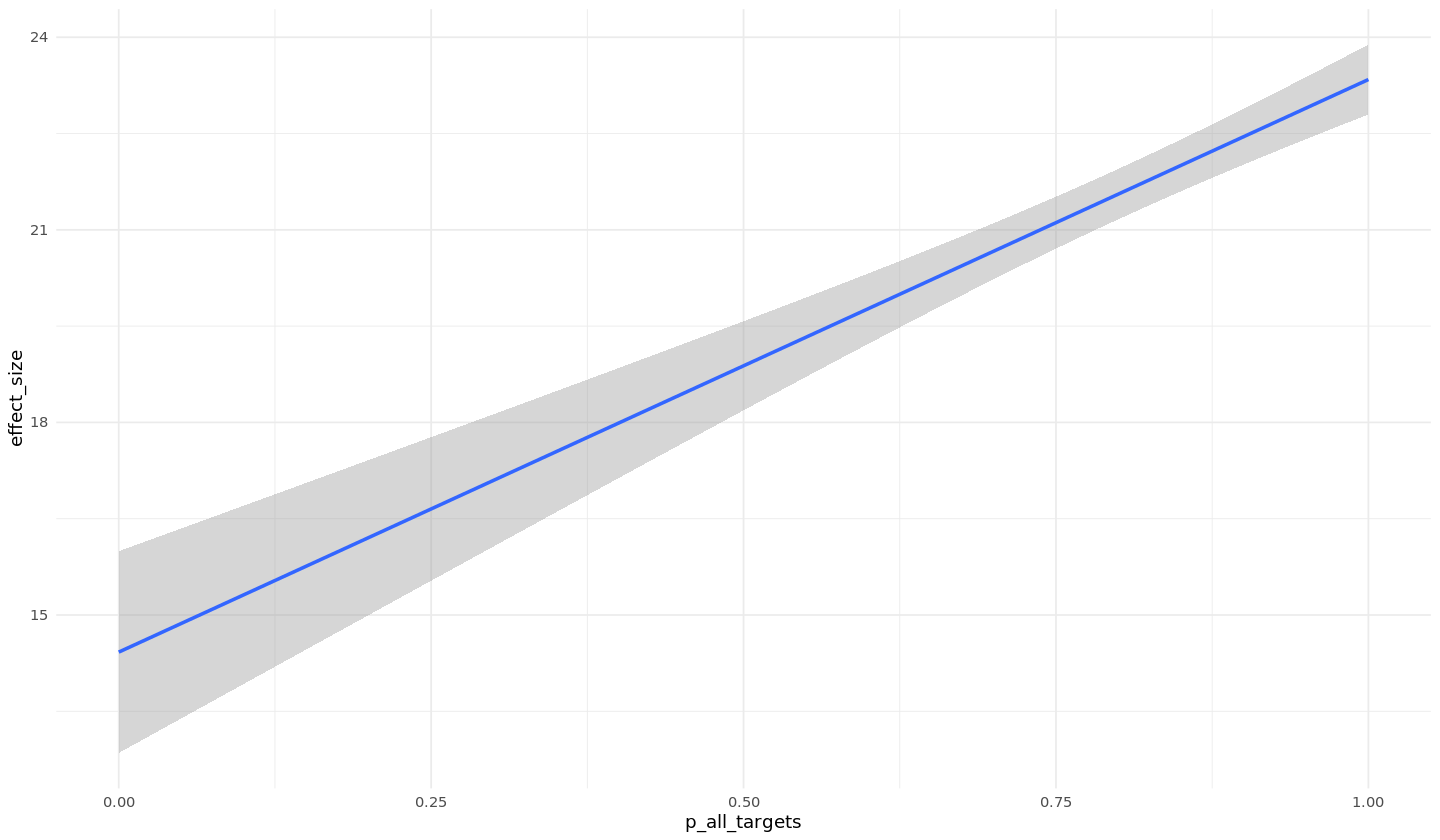

In [41]:
PPP %>% filter(order==1) %>%
ggplot(aes(x=p_all_targets,y=effect_size)) +
geom_smooth(method="lm") 

`geom_smooth()` using formula 'y ~ x'



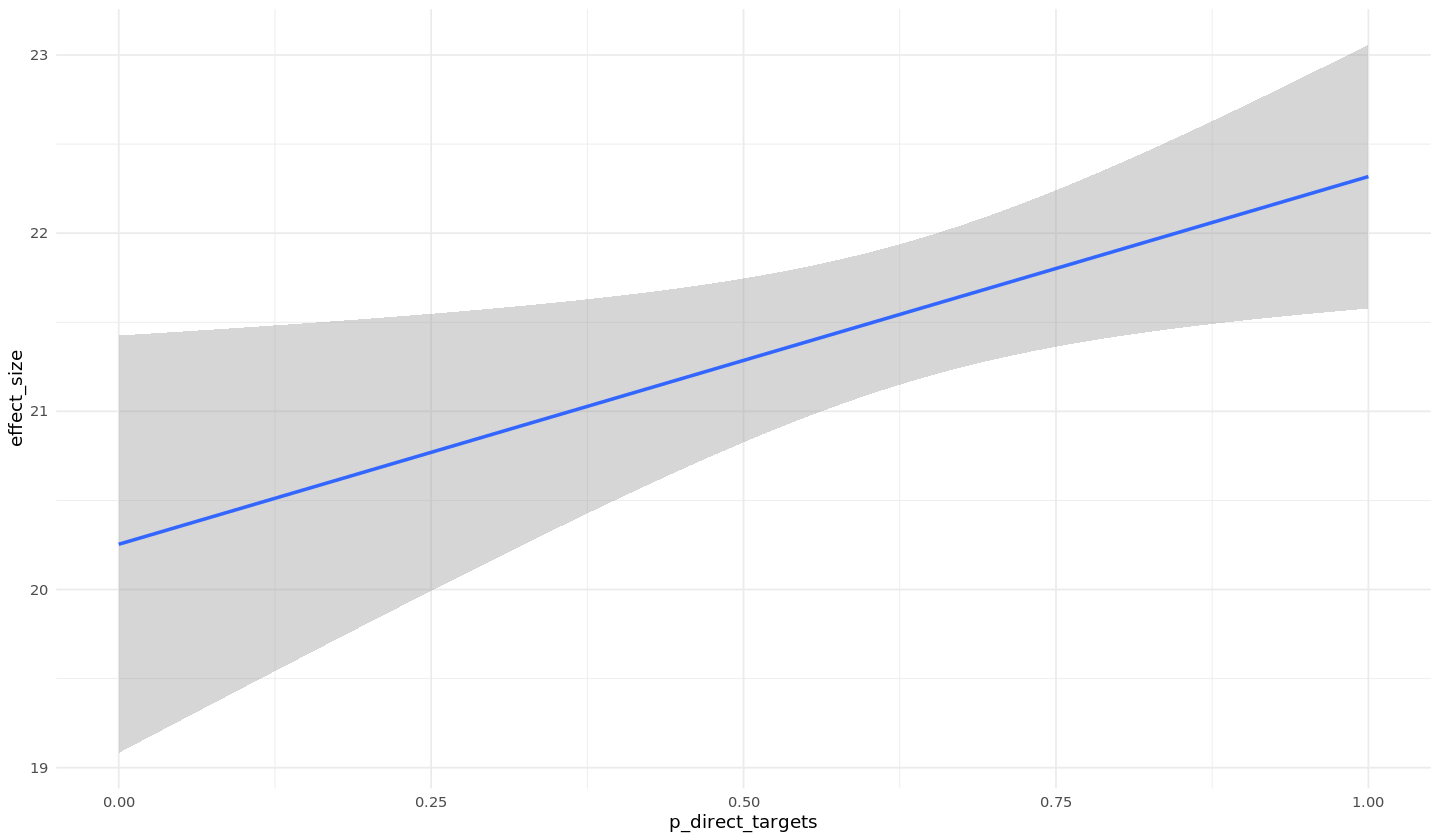

In [42]:
PPP %>% filter(order==1) %>%
ggplot(aes(x=p_direct_targets,y=effect_size)) +
geom_smooth(method="lm") 

`geom_smooth()` using formula 'y ~ x'



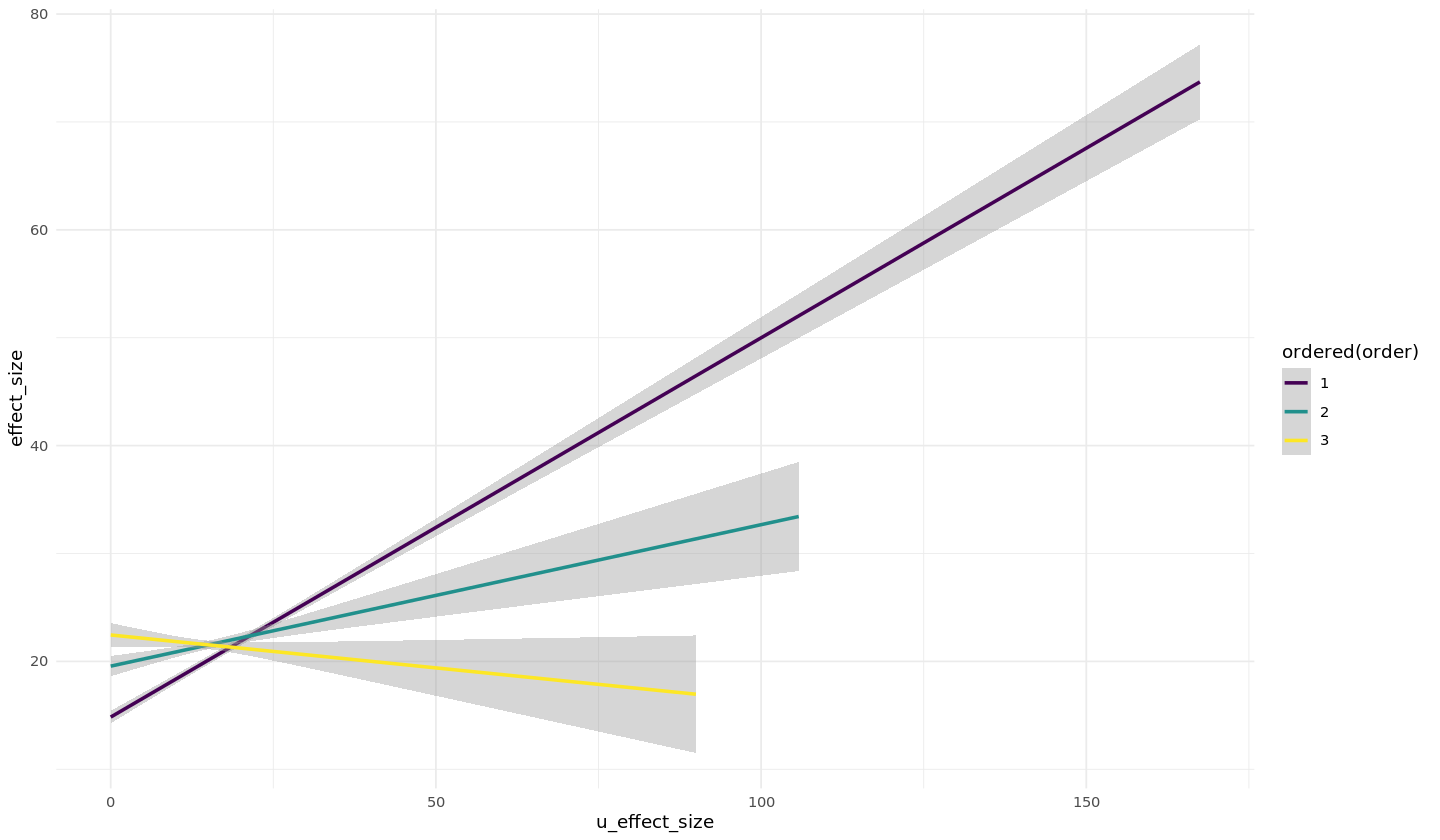

In [43]:
PPP %>%
ggplot(aes(x=u_effect_size,y=effect_size,colour=ordered(order))) +
geom_smooth(method="lm") 

`geom_smooth()` using formula 'y ~ x'



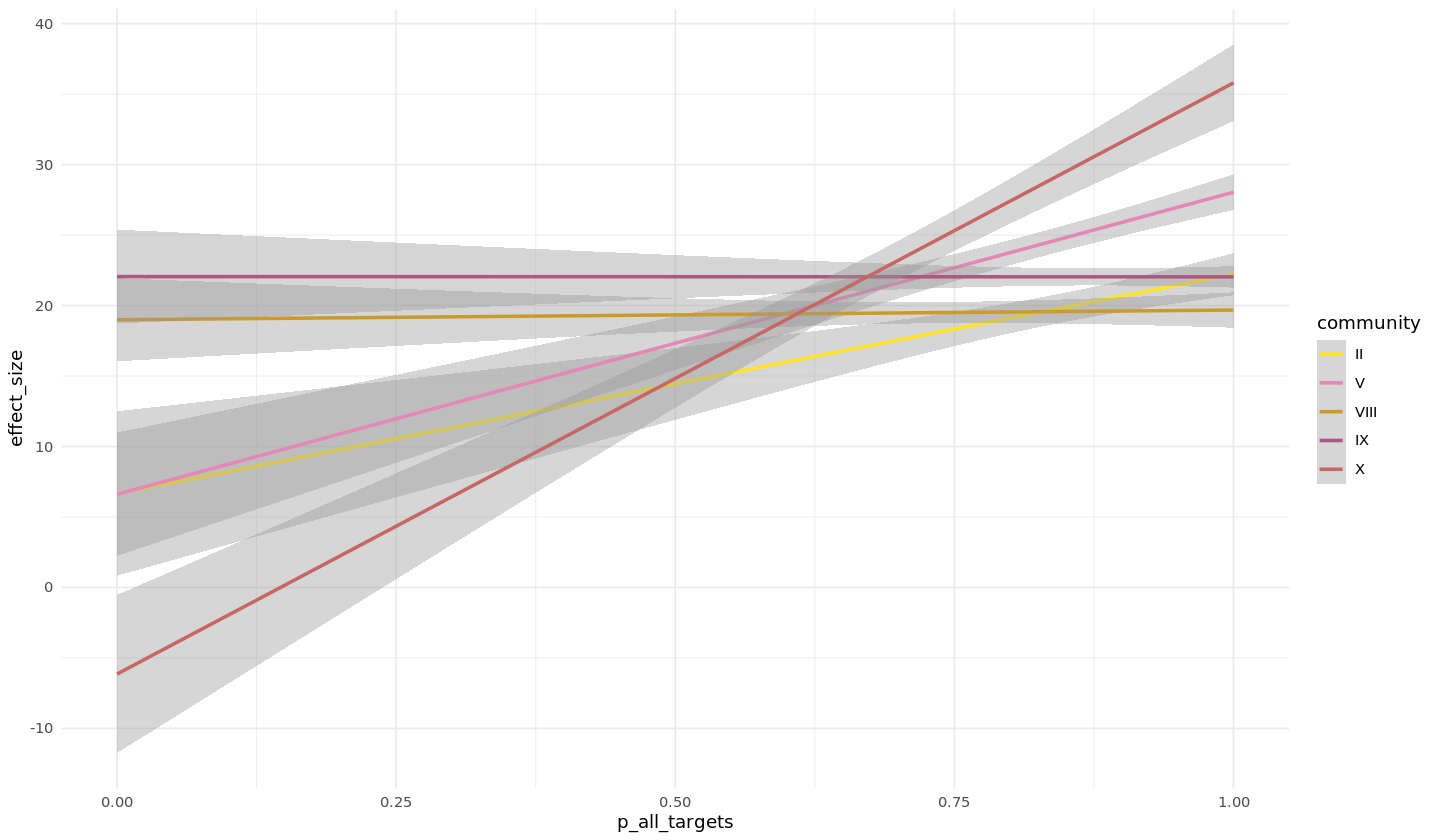

In [44]:
PPP %>% filter(order==1) %>%
ggplot(aes(x=p_all_targets,y=effect_size,colour=community)) +
geom_smooth(method="lm") +
scale_colour_manual(values=col2)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



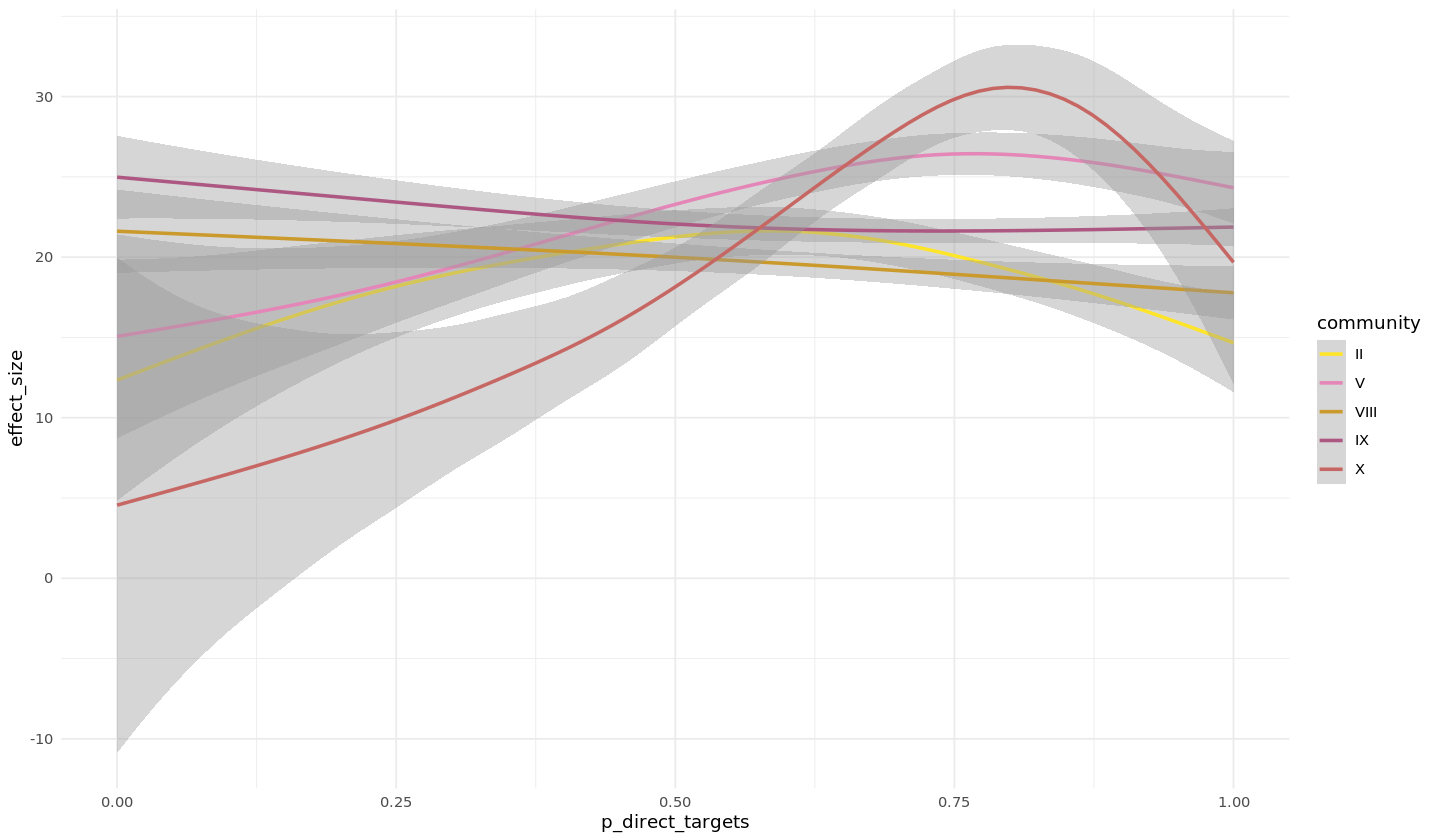

In [45]:
PPP %>% filter(order==1) %>%
ggplot(aes(x=p_direct_targets,y=effect_size,colour=community)) +
geom_smooth() +
scale_colour_manual(values=col2)

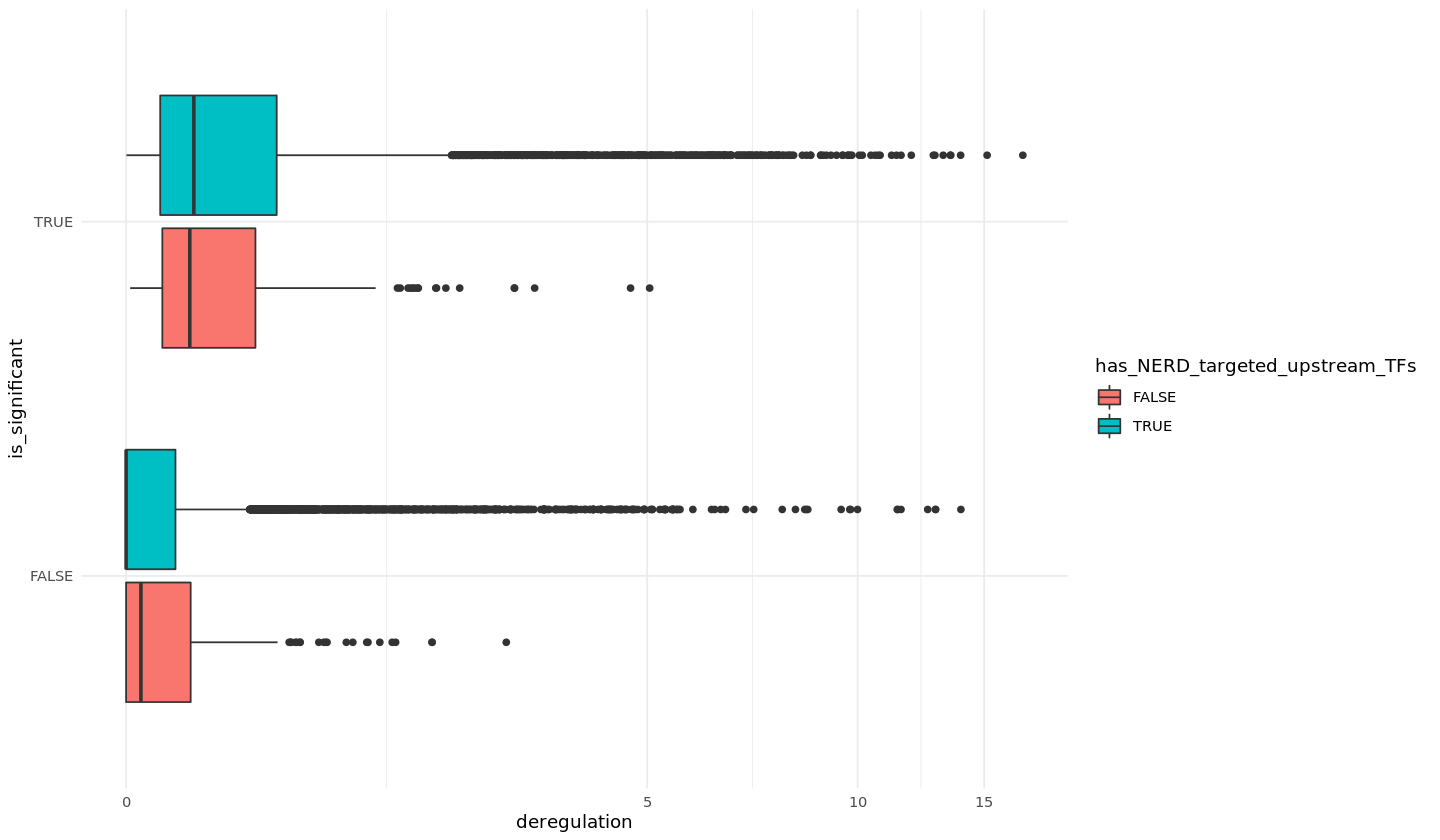

In [46]:
PPP %>% filter(order==1) %>% mutate(has_NERD_targeted_upstream_TFs=direct_targets>0) %>%
ggplot(aes(x=is_significant,y=deregulation,fill=has_NERD_targeted_upstream_TFs))+
geom_boxplot() + scale_y_continuous(trans=scales::pseudo_log_trans(base = 10)) + coord_flip()

In [47]:
fit=step(glm(effect_size~order*p_all_targets*p_direct_targets*community,data=PPP))

Start:  AIC=583388.9
effect_size ~ order * p_all_targets * p_direct_targets * community

                                                 Df Deviance    AIC
<none>                                              49491015 583389
- order:p_all_targets:p_direct_targets:community  4 49501853 583394


In [48]:
summary(fit)


Call:
glm(formula = effect_size ~ order * p_all_targets * p_direct_targets * 
    community, data = PPP)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-62.97  -18.62   -6.17    5.07  367.91  

Coefficients: (36 not defined because of singularities)
                                                     Estimate Std. Error
(Intercept)                                         1.542e+01  4.413e+00
order                                              -6.905e-15  2.043e+00
p_all_targets                                       8.537e+01  1.439e+01
p_direct_targets                                    2.803e+00  1.803e+01
communityII                                        -2.810e+01  8.388e+00
communityIII                                       -1.246e+00  7.725e+00
communityIV                                         4.401e+00  7.470e+00
communityV                                         -2.423e+01  8.609e+00
communityVI                                         1.005e+01  9.457e+00
com

In [49]:
head(PPP)

head(PPP %>% select(2,4,8:9,11:13))

geneid           order u_deregulation u_effect_size
1 Pp3c1_1000.mRNA  1     0.3469483      11.286192    
2 Pp3c1_1000.mRNA  2     0.3469483       7.730350    
3 Pp3c1_1000.mRNA  3     0.4287560      12.382109    
4 Pp3c1_10010.mRNA 1     0.2098584       8.300724    
5 Pp3c1_10010.mRNA 2     0.4024813      15.200864    
6 Pp3c1_10010.mRNA 3     0.3972395      16.296349    
  u_local_reaching_centrality u_sites_rel u_tertiary_deaminated_rel
1 0.9978148                   0.07942824  0.004638740              
2 0.9978148                   0.08762103  0.005614174              
3 0.9978148                   0.07732684  0.006232042              
4 0.9978148                   0.07777164  0.005776663              
5 0.9974051                   0.08748337  0.006827096              
6 0.9978148                   0.09179849  0.007936730              
  u_tertiary_oxidized_or_acetylated_rel u_secondary_ATE_rel
1 0                                     0.001871391        
2 0                                     0.002011615        
3 0                                     0.002123228        
4 0                                     0.001533757        
5 0                                     0.002127814        
6 0                                     0.002446239        
  u_secondary_peptidase_rel ⋯ local_reaching_centrality centrality_rank
1 0.01571711                ⋯ 0                          801           
2 0.01727296                ⋯ 0                          801           
3 0.01422493                ⋯ 0                          801           
4 0.01426660                ⋯ 0                         1155           
5 0.01702838                ⋯ 0                         1155           
6 0.01683325                ⋯ 0                         1155           
  NERD_target SLC sites_rel  tertiary_deaminated_rel
1 FALSE       S3  0.06459948 0.000000000            
2 FALSE       S3  0.06459948 0.000000000            
3 FALSE       S3  0.06459948 0.000000000            
4 FALSE       S2  0.03943218 0.004731861            
5 FALSE       S2  0.03943218 0.004731861            
6 FALSE       S2  0.03943218 0.004731861            
  tertiary_oxidized_or_acetylated_rel secondary_ATE_rel secondary_peptidase_rel
1 0                                   0.000000000       0.015503876            
2 0                                   0.000000000       0.015503876            
3 0                                   0.000000000       0.015503876            
4 0                                   0.001577287       0.003154574            
5 0                                   0.001577287       0.003154574            
6 0                                   0.001577287       0.003154574            
  primary_acetylated_rel
1 0.04134367            
2 0.04134367            
3 0.04134367            
4 0.02208202            
5 0.02208202            
6 0.02208202

order u_effect_size u_tertiary_oxidized_or_acetylated_rel u_secondary_ATE_rel
1 1     11.286192     0                                     0.001871391        
2 2      7.730350     0                                     0.002011615        
3 3     12.382109     0                                     0.002123228        
4 1      8.300724     0                                     0.001533757        
5 2     15.200864     0                                     0.002127814        
6 3     16.296349     0                                     0.002446239        
  u_primary_acetylated_rel all_targets dereg_targets
1 0.04456619                1          0            
2 0.05223983                6          0            
3 0.04456619               12          0            
4 0.04338914                1          0            
5 0.04711449                4          0            
6 0.05103846               11          0

In [50]:
PPPP=PPP %>% mutate(col=ordered(ifelse(is_significant,as.character(community),"YY")))
table(PPPP$col)


    I    II   III    IV    IX     V    VI   VII  VIII     X    XI    YY 
   99  4386    48    87 10563  5178    51    96  4542  2103    99 33930 

In [51]:
#res.pca=PCA(PPP %>% filter(order==3) %>% select(4,8:9,11:13), graph = FALSE, scale.unit=TRUE,quali.sup=5:6)
res.pca=PCA(PPP %>% select(2,4,8:9,11:13), graph = FALSE, scale.unit=TRUE,quali.sup=6:7)

In [52]:
options(repr.plot.width=7, repr.plot.height=7)

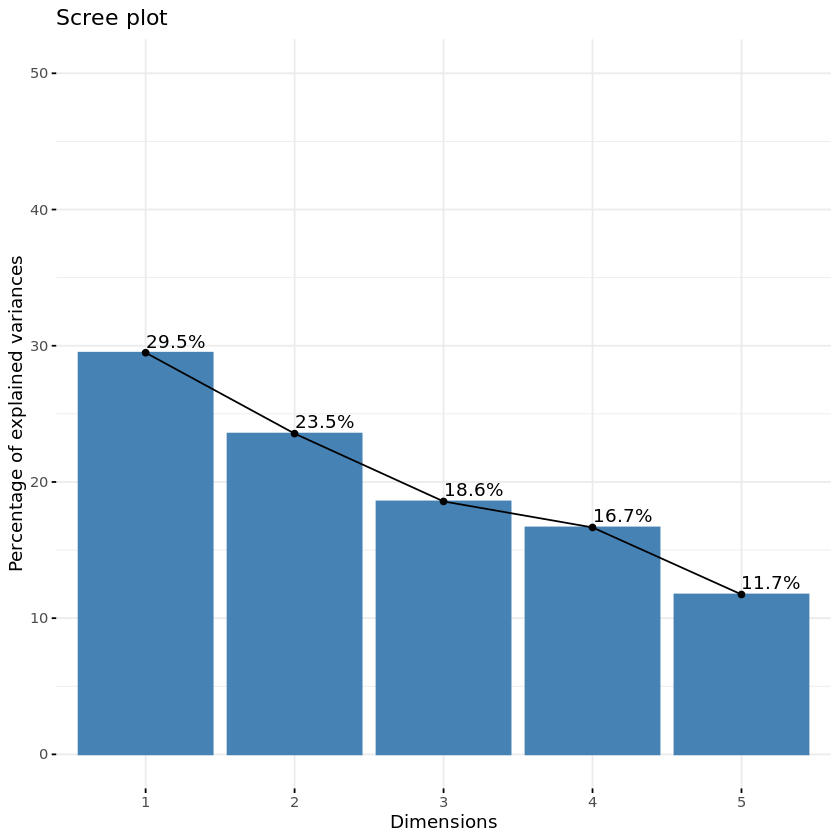

In [53]:
fviz_eig(res.pca, addlabels = TRUE, ylim = c(0, 50))

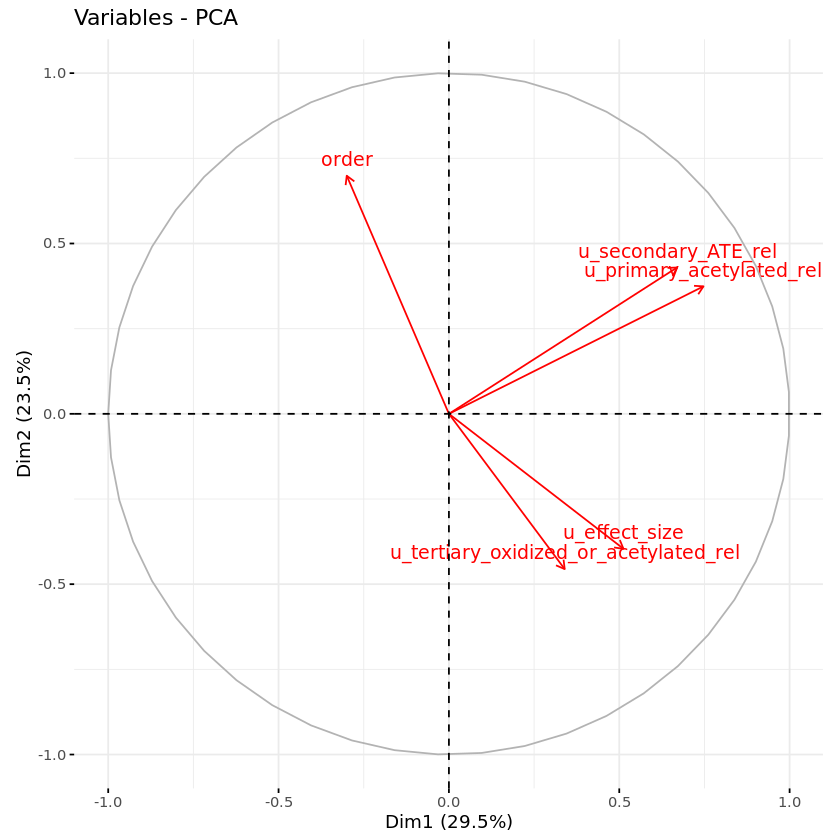

In [54]:
fviz_pca_var(res.pca, col.var = "red")

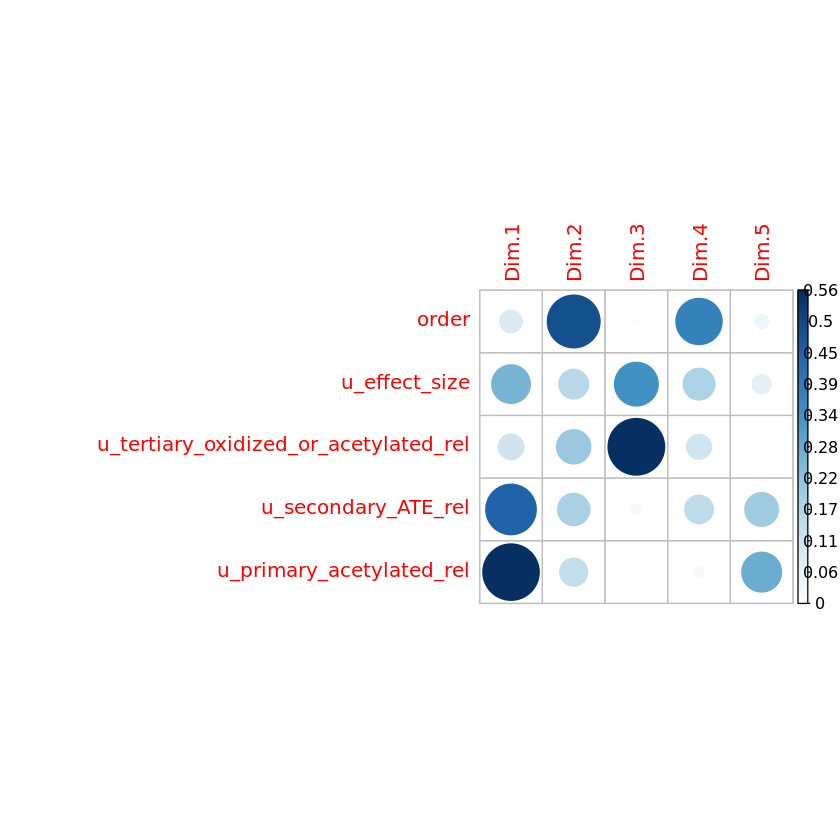

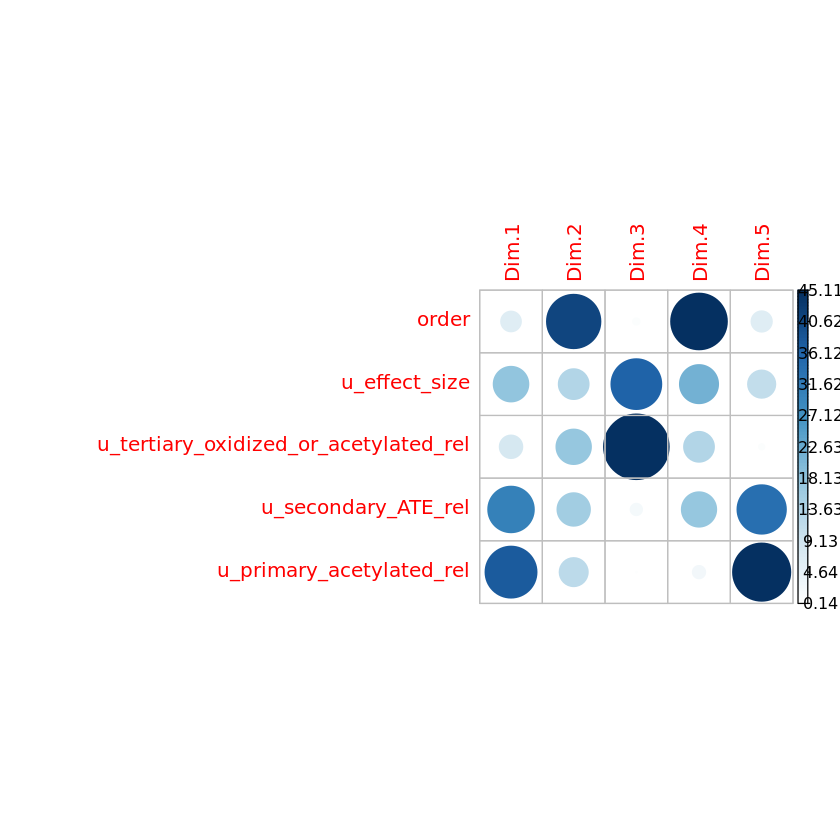

In [55]:
corrplot(res.pca$var$cos2, is.corr=FALSE)
corrplot(res.pca$var$contrib, is.corr=FALSE)    

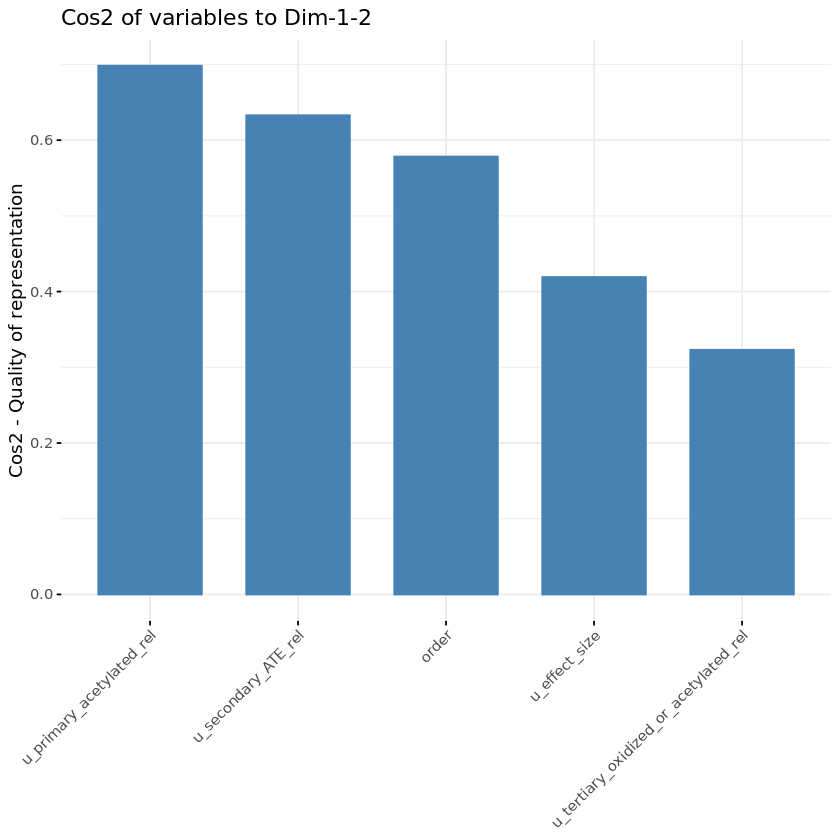

In [56]:
fviz_cos2(res.pca, choice = "var", axes = 1:2)

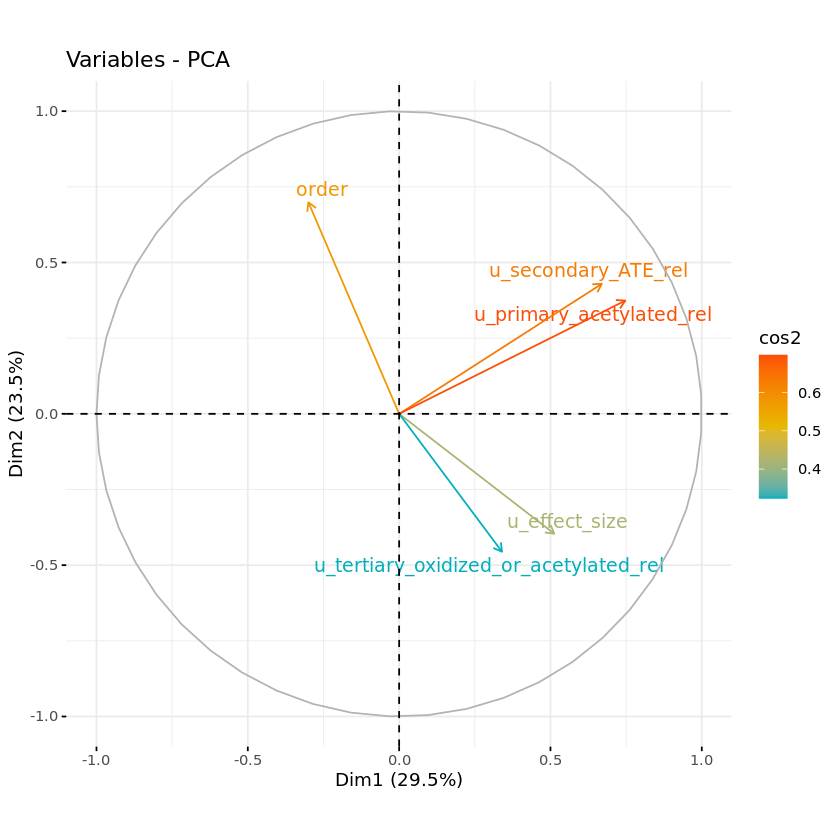

In [57]:
fviz_pca_var(res.pca, col.var = "cos2",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"), 
             repel = TRUE # Avoid text overlapping
             )

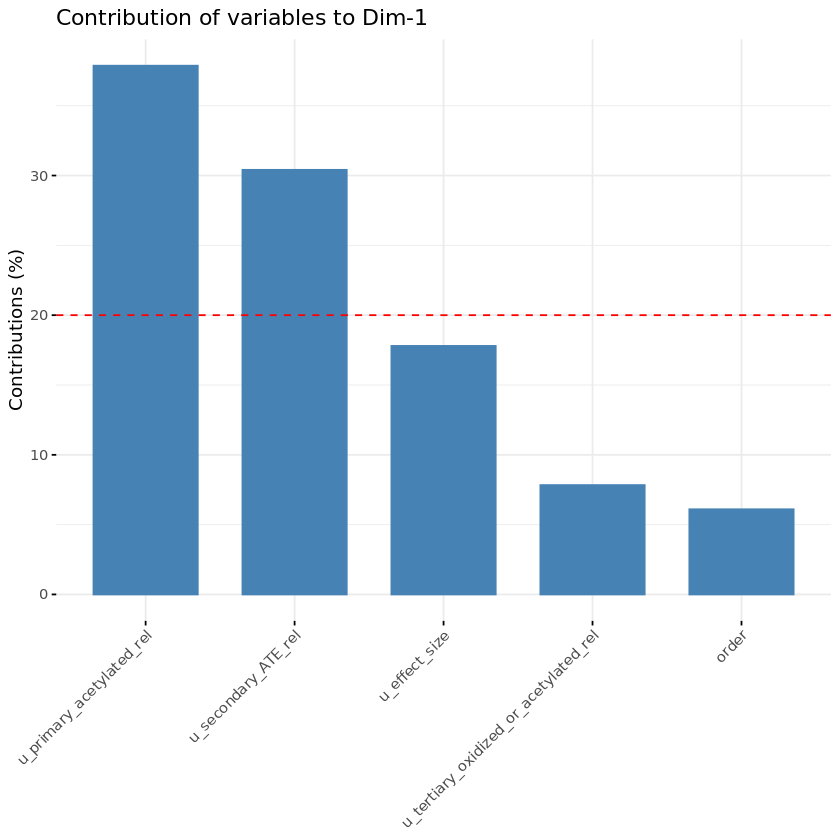

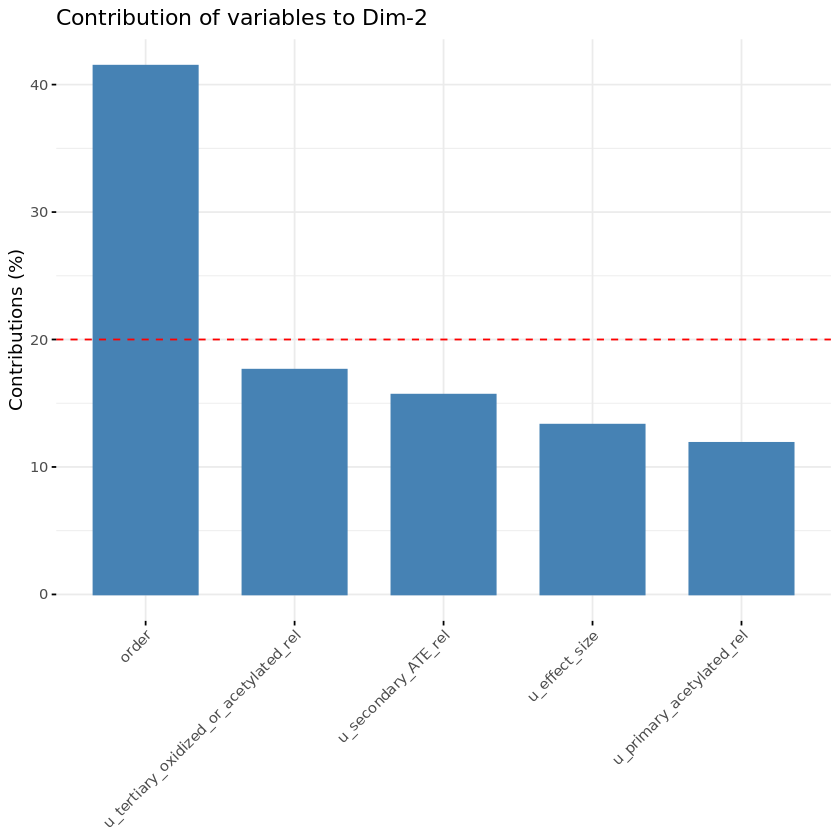

In [58]:
# Contributions of variables to PC1
fviz_contrib(res.pca, choice = "var", axes = 1, top = 10)
# Contributions of variables to PC2
fviz_contrib(res.pca, choice = "var", axes = 2, top = 10)

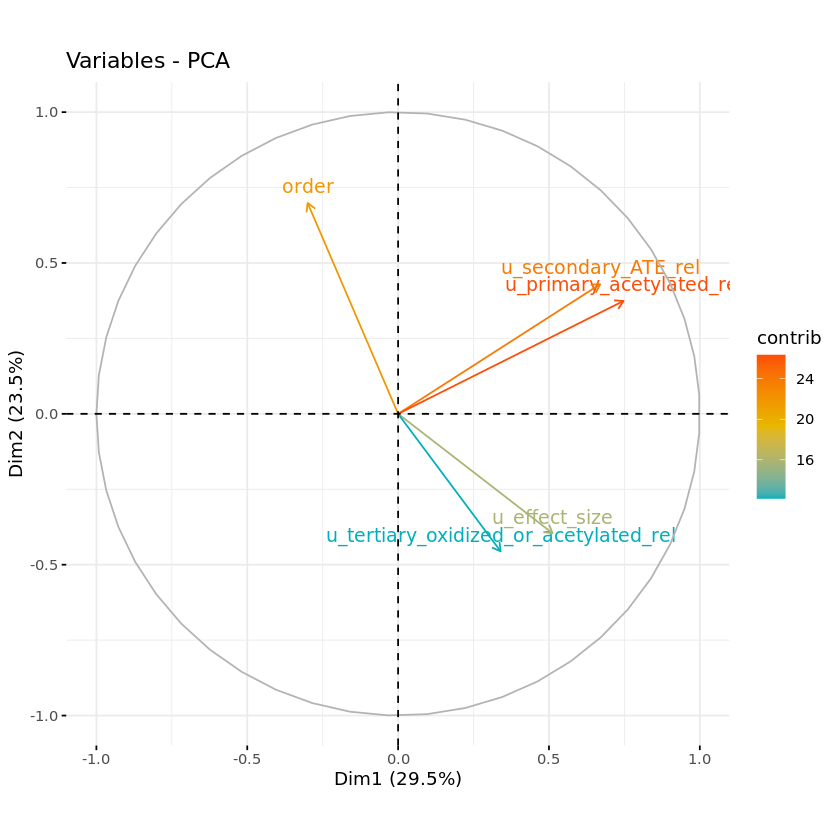

In [59]:
fviz_pca_var(res.pca, col.var = "contrib",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07")
             )

In [60]:
options(repr.plot.width=15, repr.plot.height=12)

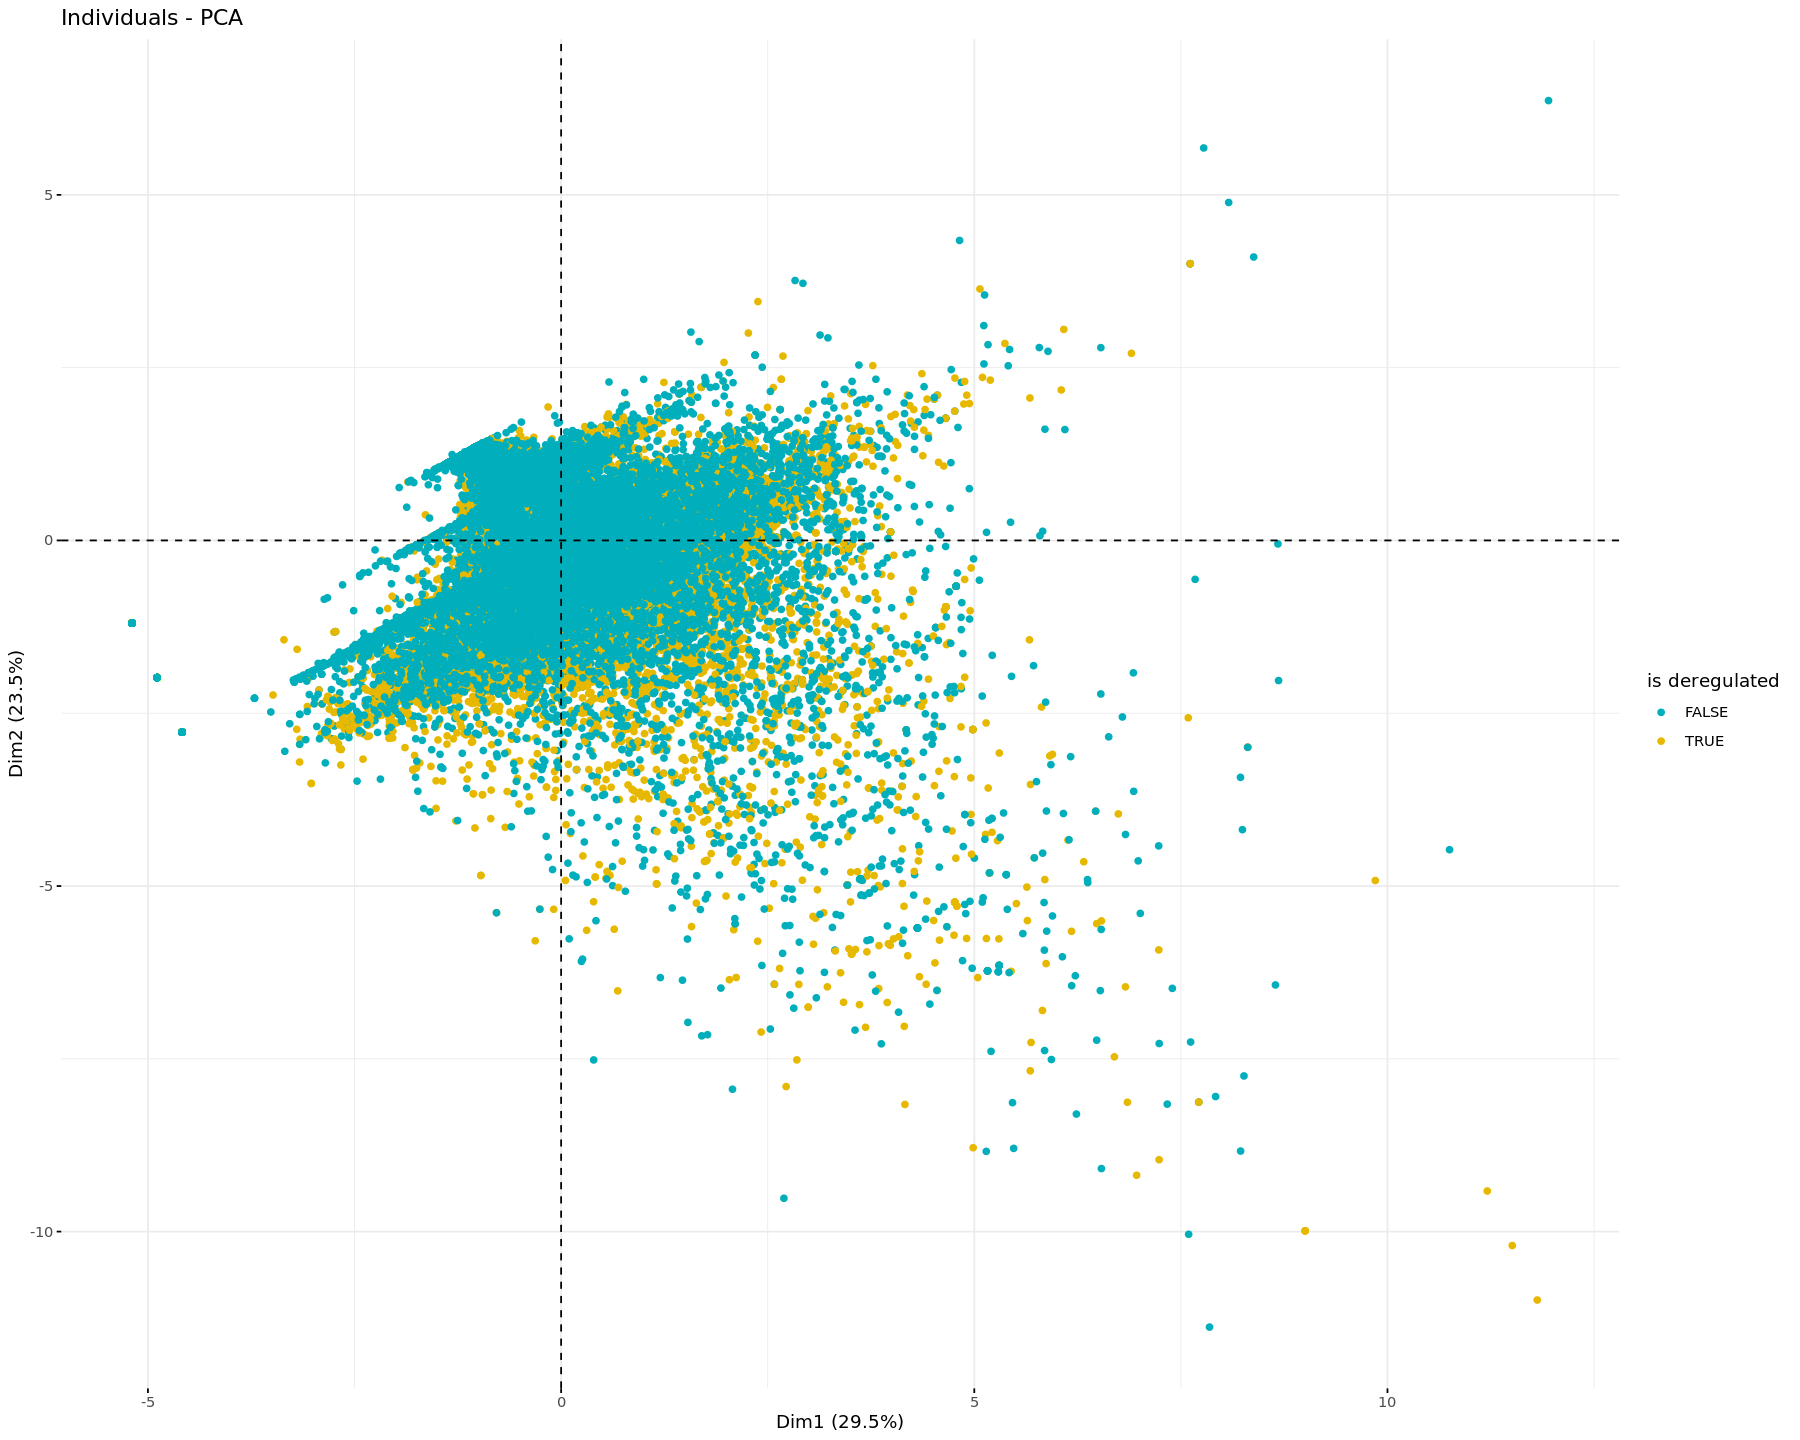

In [61]:
fviz_pca_ind(res.pca,
             geom.ind = "point", # show points only (nbut not "text")
             #col.ind = PPP%>% filter(order==2) %>% select(is_significant) %>% unlist(.,use.names=F), # color by groups
             col.ind = PPP%>% select(is_significant) %>% unlist(.,use.names=F), # color by groups
             palette = c("#00AFBB", "#E7B800", "#FC4E07"),
             addEllipses = FALSE, # Concentration ellipses
             legend.title = "is deregulated"
             )

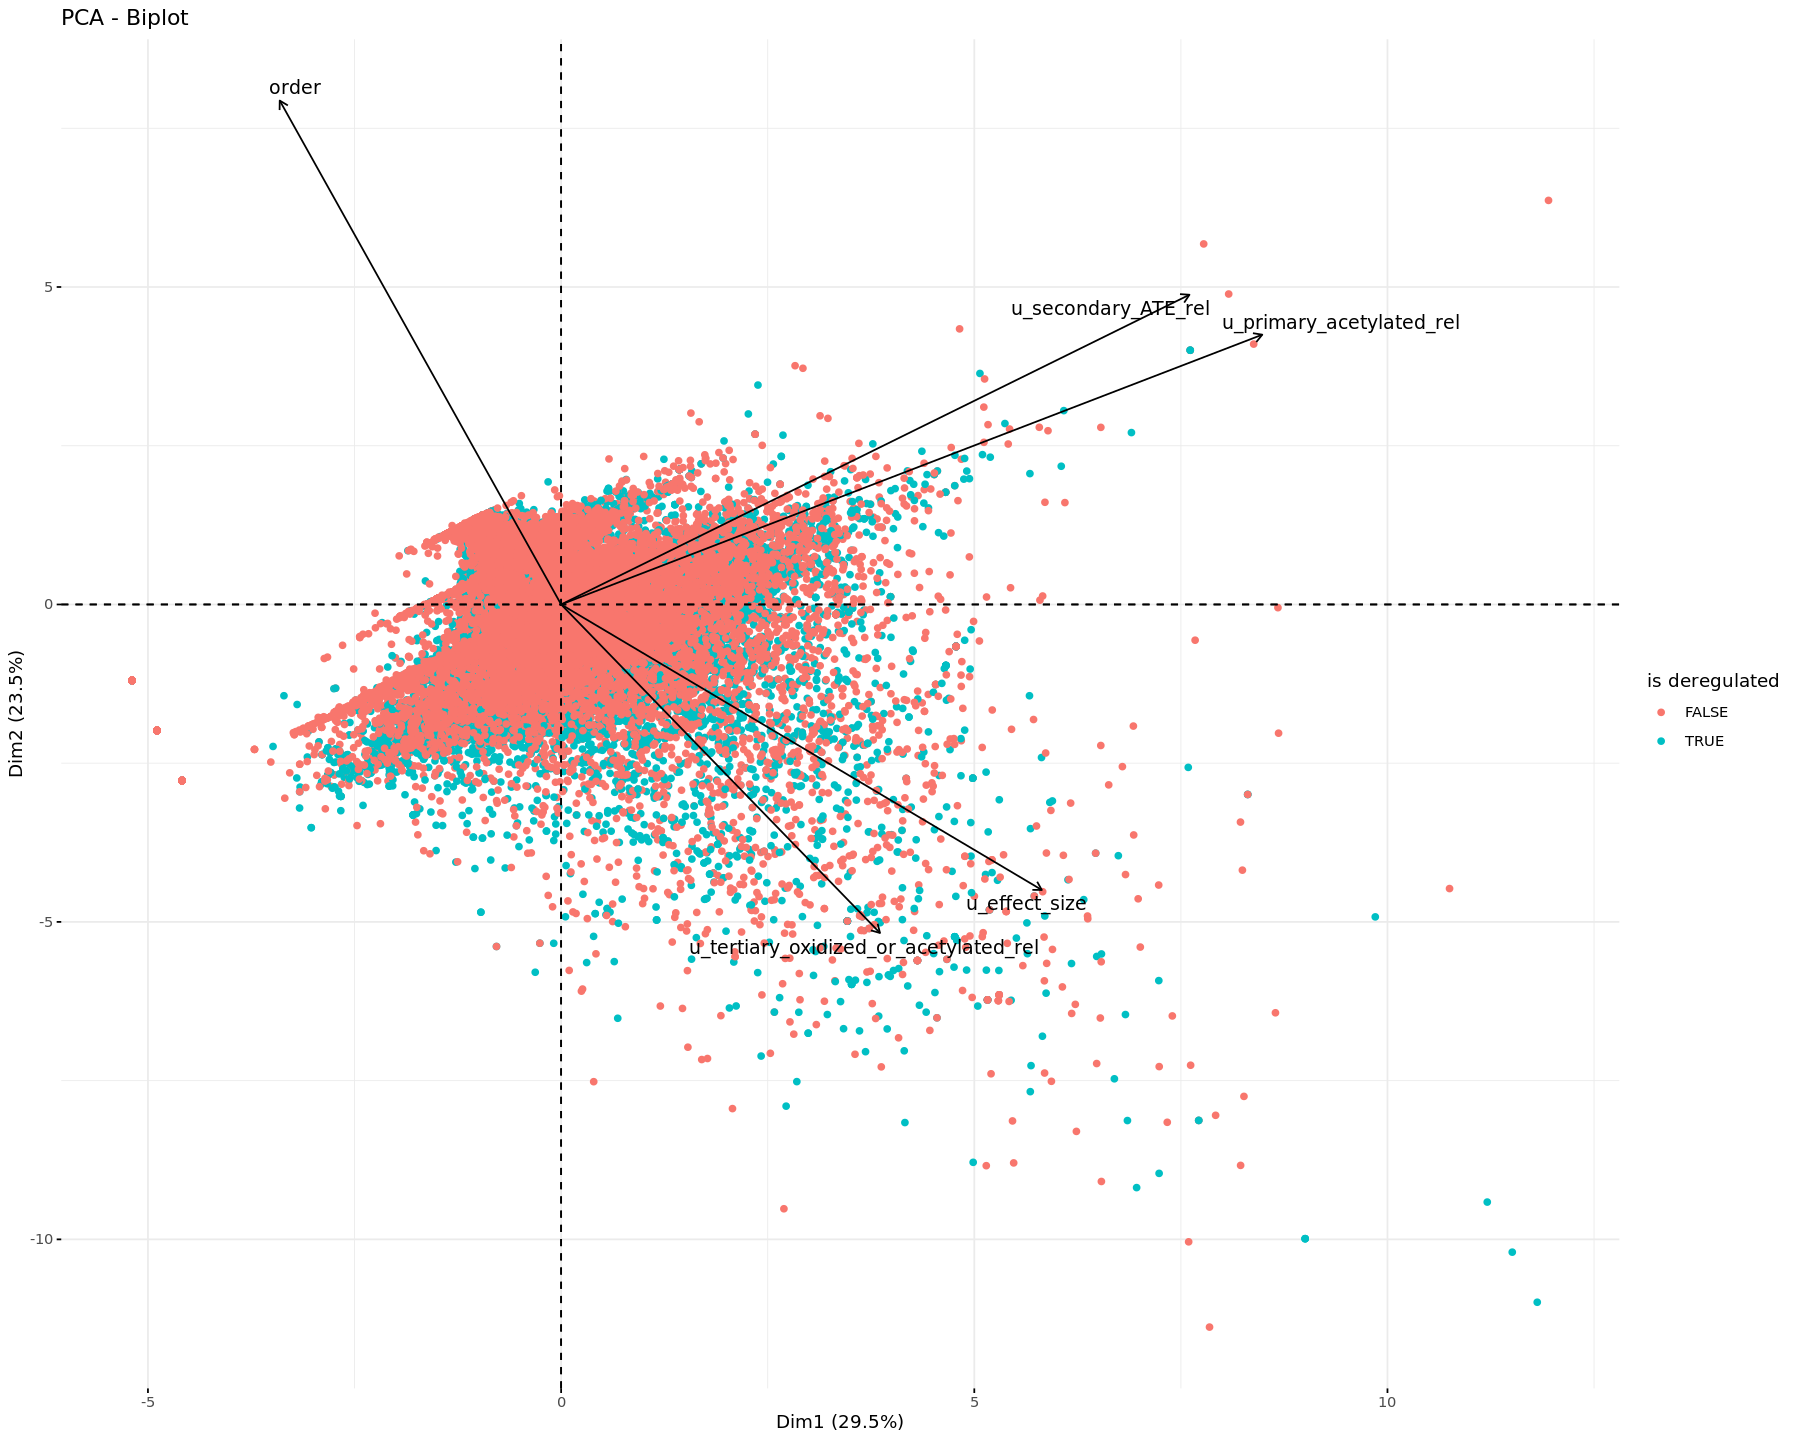

In [62]:
fviz_pca_biplot(res.pca, repel = TRUE,
             geom.ind = "point", # show points only (nbut not "text")
                col.var = "black", # Variables color
             #col.ind = PPP%>% filter(order==2) %>% select(is_significant) %>% unlist(.,use.names=F), # color by groups
             col.ind = PPP %>% select(is_significant) %>% unlist(.,use.names=F), # color by groups
             legend.title = "is deregulated"
            )

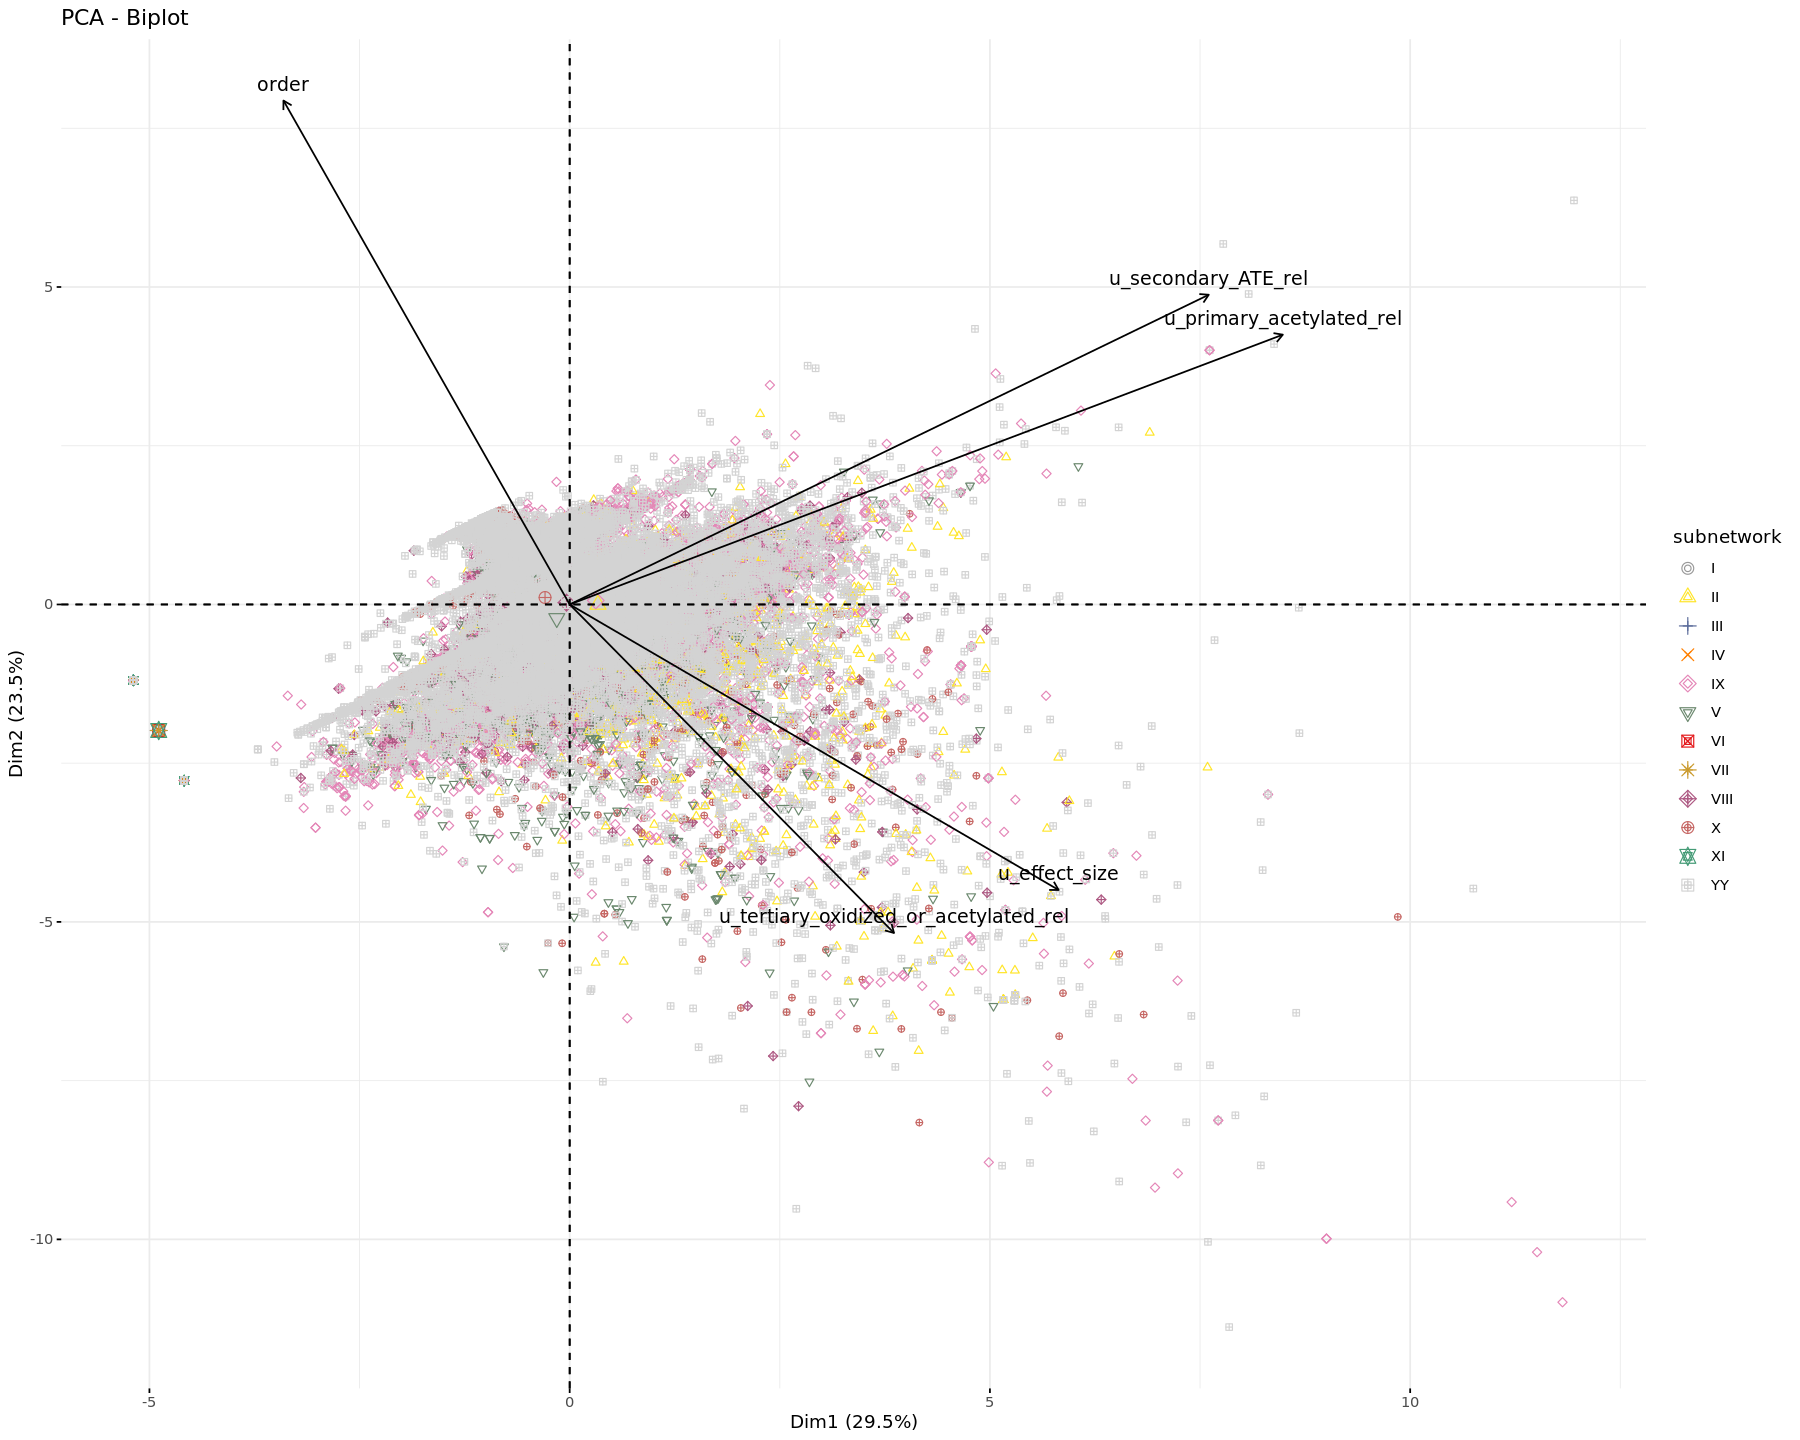

In [63]:
g= fviz_pca_biplot(res.pca, repel = FALSE,
             geom.ind = "point", # show points only (nbut not "text")
                 #col.ind = PPP%>% filter(order==2) %>% select(community) %>% unlist(.,use.names=F), # color by groups
                 col.ind = PPPP%>% select(col) %>% unlist(.,use.names=F), # color by groups
                col.var="black",
                palette=c(col2,"lightgrey"),
             legend.title = "subnetwork"
            )
g

In [64]:
dd=dimdesc(res.pca)

In [65]:
dd[[1]]$quanti
dd[[2]]$quanti

correlation p.value      
u_primary_acetylated_rel               0.74718568  0.000000e+00
u_secondary_ATE_rel                    0.66956977  0.000000e+00
u_effect_size                          0.51224428  0.000000e+00
u_tertiary_oxidized_or_acetylated_rel  0.33979484  0.000000e+00
dereg_targets                         -0.04044203  1.416726e-23
all_targets                           -0.11045320 2.463065e-165
order                                 -0.29986176  0.000000e+00

correlation p.value
order                                  0.6988629  0      
all_targets                            0.5059037  0      
u_secondary_ATE_rel                    0.4295814  0      
dereg_targets                          0.3797703  0      
u_primary_acetylated_rel               0.3742042  0      
u_effect_size                         -0.3960060  0      
u_tertiary_oxidized_or_acetylated_rel -0.4556298  0

In [66]:
dd[[1]]$quali
dd[[2]]$quali

NULL

NULL

In [67]:
dd[[1]]$category
dd[[2]]$category

NULL

NULL

In [68]:
names(PPP)

[1] "geneid"                               
 [2] "order"                                
 [3] "u_deregulation"                       
 [4] "u_effect_size"                        
 [5] "u_local_reaching_centrality"          
 [6] "u_sites_rel"                          
 [7] "u_tertiary_deaminated_rel"            
 [8] "u_tertiary_oxidized_or_acetylated_rel"
 [9] "u_secondary_ATE_rel"                  
[10] "u_secondary_peptidase_rel"            
[11] "u_primary_acetylated_rel"             
[12] "all_targets"                          
[13] "dereg_targets"                        
[14] "direct_targets"                       
[15] "upstream"                             
[16] "p_all_targets"                        
[17] "p_dereg_targets"                      
[18] "p_direct_targets"                     
[19] "deregulation"                         
[20] "effect_size"                          
[21] "is_significant"                       
[22] "community"                            
[23] "degree_centrality"                    
[24] "betweenness_centrality"               
[25] "eigenvector_centrality"               
[26] "local_reaching_centrality"            
[27] "centrality_rank"                      
[28] "NERD_target"                          
[29] "SLC"                                  
[30] "sites_rel"                            
[31] "tertiary_deaminated_rel"              
[32] "tertiary_oxidized_or_acetylated_rel"  
[33] "secondary_ATE_rel"                    
[34] "secondary_peptidase_rel"              
[35] "primary_acetylated_rel"

In [69]:
P3=droplevels(subset(PPP,order==3 ))
nrow(PPP)
nrow(P3)

[1] 61182

[1] 20394

In [70]:
table(target_deregulated=P3$is_significant,has_upstream_NERD_cleavage=P3$p_direct_targets>0,has_deregulated_regulon=P3$p_dereg_targets>0)
prop.table(table(target_deregulated=P3$is_significant,has_upstream_NERD_cleavage=P3$p_direct_targets>0,has_deregulated_regulon=P3$p_dereg_targets>0))

, , has_deregulated_regulon = FALSE

                  has_upstream_NERD_cleavage
target_deregulated FALSE  TRUE
             FALSE   192   886
             TRUE    187   442

, , has_deregulated_regulon = TRUE

                  has_upstream_NERD_cleavage
target_deregulated FALSE  TRUE
             FALSE   105 10127
             TRUE    127  8328


, , has_deregulated_regulon = FALSE

                  has_upstream_NERD_cleavage
target_deregulated       FALSE        TRUE
             FALSE 0.009414534 0.043444150
             TRUE  0.009169364 0.021673041

, , has_deregulated_regulon = TRUE

                  has_upstream_NERD_cleavage
target_deregulated       FALSE        TRUE
             FALSE 0.005148573 0.496567618
             TRUE  0.006227322 0.408355399


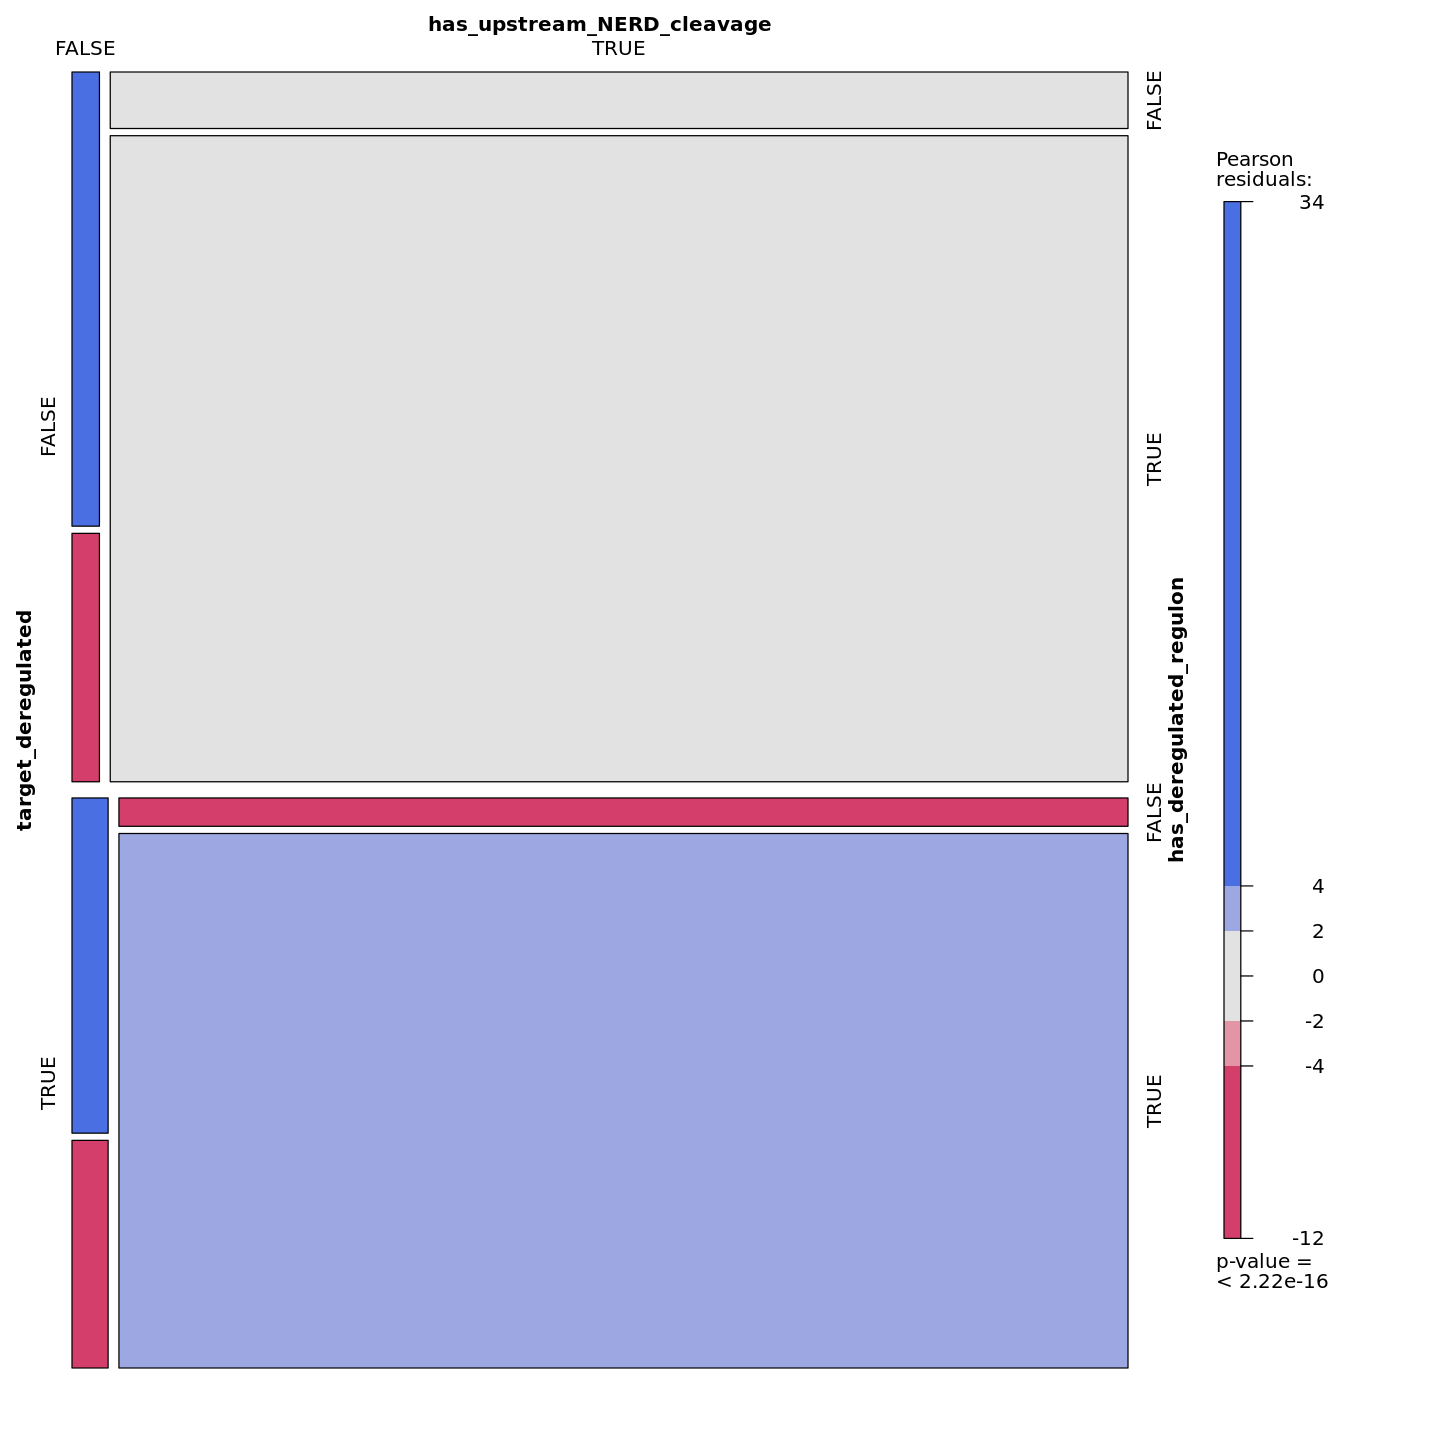

In [71]:
X=data.frame(table(target_deregulated=P3$is_significant,has_upstream_NERD_cleavage=P3$p_direct_targets>0,has_deregulated_regulon=P3$p_dereg_targets>0))
XX=xtabs(Freq~target_deregulated+has_upstream_NERD_cleavage+has_deregulated_regulon,X)
options(repr.plot.width=12, repr.plot.height=12)
mosaic(XX, shade=TRUE, clegend=TRUE,legend_width=10,gp =shading_hcl)#, gp_args = list(h = c(130, 43), c = 100, l = c(90, 70))) 

## Larger upstream regulon (up to order==3)  - >0% direct NERD-DEK1 targets & >5% deregulated TFs

, , has_deregulated_regulon = FALSE

                  has_upstream_NERD_cleavage
target_deregulated FALSE TRUE
             FALSE   201 2001
             TRUE    193  987

, , has_deregulated_regulon = TRUE

                  has_upstream_NERD_cleavage
target_deregulated FALSE TRUE
             FALSE    96 9012
             TRUE    121 7783


, , has_deregulated_regulon = FALSE

                  has_upstream_NERD_cleavage
target_deregulated       FALSE        TRUE
             FALSE 0.009855840 0.098117093
             TRUE  0.009463568 0.048396587

, , has_deregulated_regulon = TRUE

                  has_upstream_NERD_cleavage
target_deregulated       FALSE        TRUE
             FALSE 0.004707267 0.441894675
             TRUE  0.005933118 0.381631853


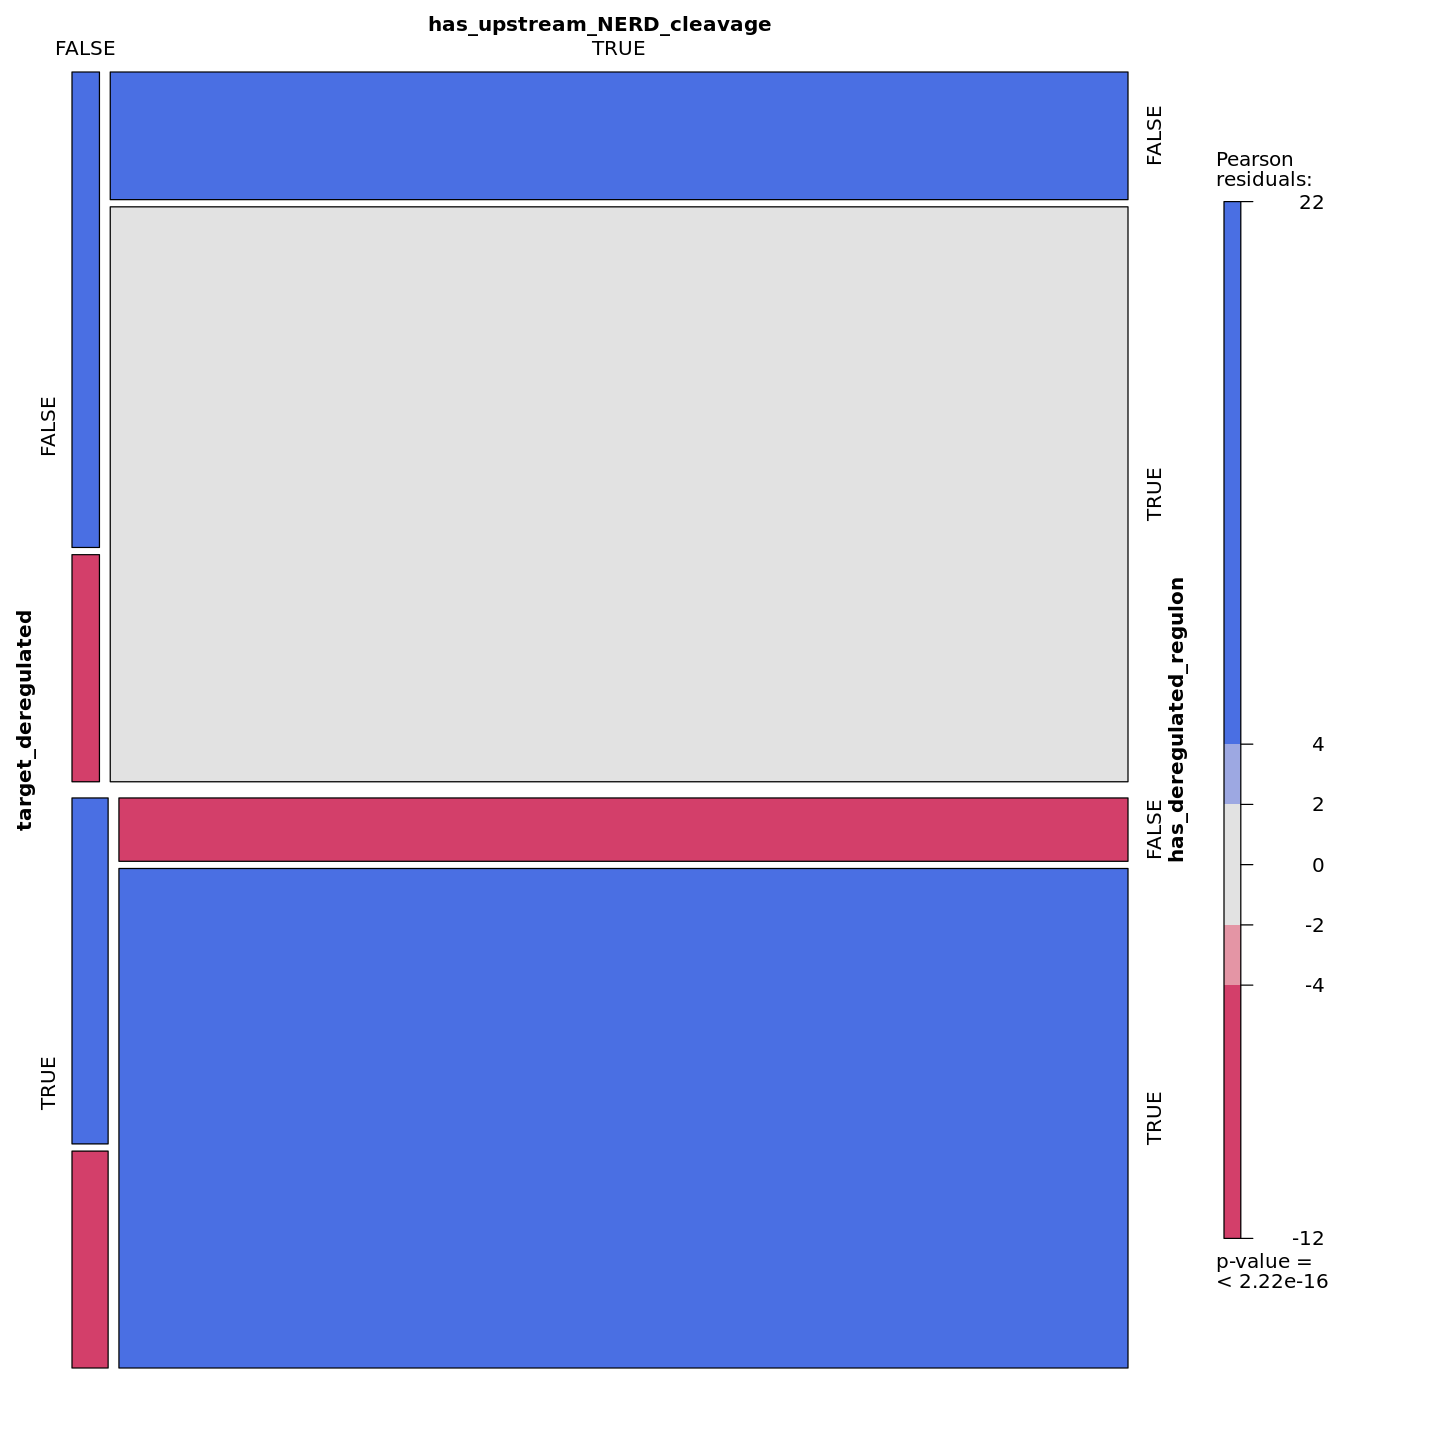

In [72]:
X=table(target_deregulated=P3$is_significant,has_upstream_NERD_cleavage=P3$p_direct_targets>0,has_deregulated_regulon=P3$p_dereg_targets>0.05)
X
prop.table(X)
X=data.frame(X)
XX=xtabs(Freq~target_deregulated+has_upstream_NERD_cleavage+has_deregulated_regulon,X)
options(repr.plot.width=12, repr.plot.height=12)
mosaic(XX, shade=TRUE, clegend=TRUE,legend_width=10,gp =shading_hcl)#, gp_args = list(h = c(130, 43), c = 100, l = c(90, 70))) 

In [73]:
P1=droplevels(subset(PPP,order==1 ))
nrow(PPP)
nrow(P1)

[1] 61182

[1] 20394

## Direct upstream regulon (order==1)  - >0% direct NERD-DEK1 targets & >15% deregulated TFs

, , has_deregulated_regulon = FALSE

                  has_upstream_NERD_cleavage
target_deregulated FALSE TRUE
             FALSE   192 1632
             TRUE    187  717

, , has_deregulated_regulon = TRUE

                  has_upstream_NERD_cleavage
target_deregulated FALSE TRUE
             FALSE   105 9381
             TRUE    127 8053


, , has_deregulated_regulon = FALSE

                  has_upstream_NERD_cleavage
target_deregulated       FALSE        TRUE
             FALSE 0.009414534 0.080023536
             TRUE  0.009169364 0.035157399

, , has_deregulated_regulon = TRUE

                  has_upstream_NERD_cleavage
target_deregulated       FALSE        TRUE
             FALSE 0.005148573 0.459988232
             TRUE  0.006227322 0.394871041


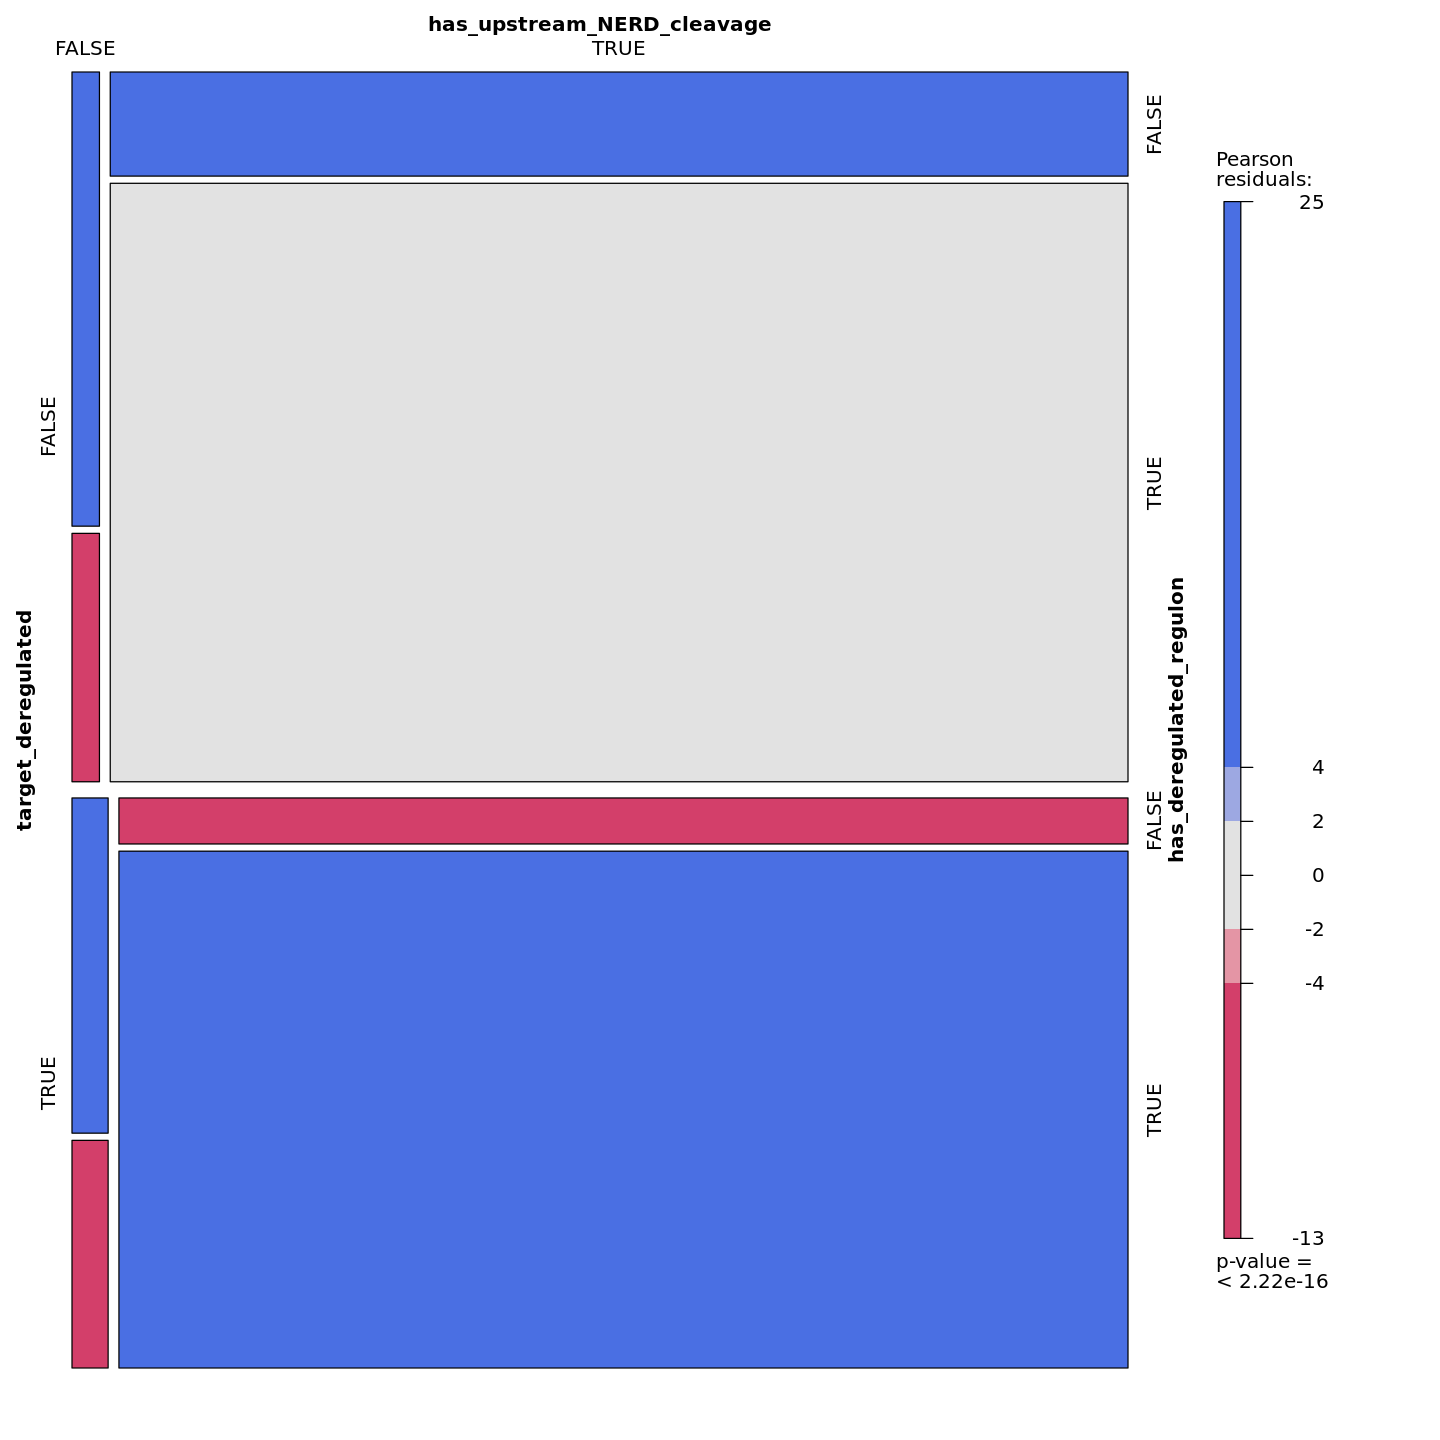

In [74]:
X=table(target_deregulated=P1$is_significant,has_upstream_NERD_cleavage=P1$p_direct_targets>0,has_deregulated_regulon=P1$p_dereg_targets>0.15)
X
prop.table(X)
X=data.frame(X)
XX=xtabs(Freq~target_deregulated+has_upstream_NERD_cleavage+has_deregulated_regulon,X)
options(repr.plot.width=12, repr.plot.height=12)
mosaic(XX, shade=TRUE, clegend=TRUE,legend_width=10,gp =shading_hcl)#, gp_args = list(h = c(130, 43), c = 100, l = c(90, 70))) 

## Deregulated targets - direct upstream regulon (order==1) 

In [75]:
PP1=droplevels(subset(PPP,order==1 & is_significant ==TRUE))
nrow(PPP)
nrow(PP1)

[1] 61182

[1] 9084

In [76]:
PP2=droplevels(subset(PPP,order==2 & is_significant ==TRUE))
nrow(PPP)
nrow(PP2)

[1] 61182

[1] 9084

In [77]:
x=cut(PP1$p_dereg_targets[PP1$p_dereg_targets>0],breaks=seq(min(PP1$p_dereg_targets[PP1$p_dereg_targets>0]),1,by=.5),right=TRUE,include.lowest=TRUE,dig.lab=1,ordered.result=TRUE)
PP1$p_dereg_cut=ordered(ifelse(PP1$p_dereg_targets>0,as.character(x),"0"),levels=c(0,levels(x)))
x=cut(PP1$p_direct_targets[PP1$p_direct_targets>0],breaks=seq(min(PP1$p_direct_targets[PP1$p_direct_targets>0]),1,by=.5),right=TRUE,include.lowest=TRUE,dig.lab=1,ordered.result=TRUE)
PP1$p_direct_cut=ordered(ifelse(PP1$p_direct_targets>0,as.character(x),"0"),levels=c(0,levels(x)))

In [78]:
x=cut(PP2$p_dereg_targets[PP2$p_dereg_targets>0],breaks=seq(min(PP2$p_dereg_targets[PP2$p_dereg_targets>0]),1,by=.5),right=TRUE,include.lowest=TRUE,dig.lab=1,ordered.result=TRUE)
PP2$p_dereg_cut=ordered(ifelse(PP2$p_dereg_targets>0,as.character(x),"0"),levels=c(0,levels(x)))
x=cut(PP2$p_direct_targets[PP2$p_direct_targets>0],breaks=seq(min(PP2$p_direct_targets[PP2$p_direct_targets>0]),1,by=.5),right=TRUE,include.lowest=TRUE,dig.lab=1,ordered.result=TRUE)
PP2$p_direct_cut=ordered(ifelse(PP2$p_direct_targets>0,as.character(x),"0"),levels=c(0,levels(x)))

                      upstream_deregulation
upstream_NERD_cleavage    0 [0.1,0.6]
             0          187        74
             [0.1,0.6]  199      2226

                      upstream_deregulation
upstream_NERD_cleavage          0  [0.1,0.6]
             0         0.06962025 0.02755026
             [0.1,0.6] 0.07408786 0.82874162

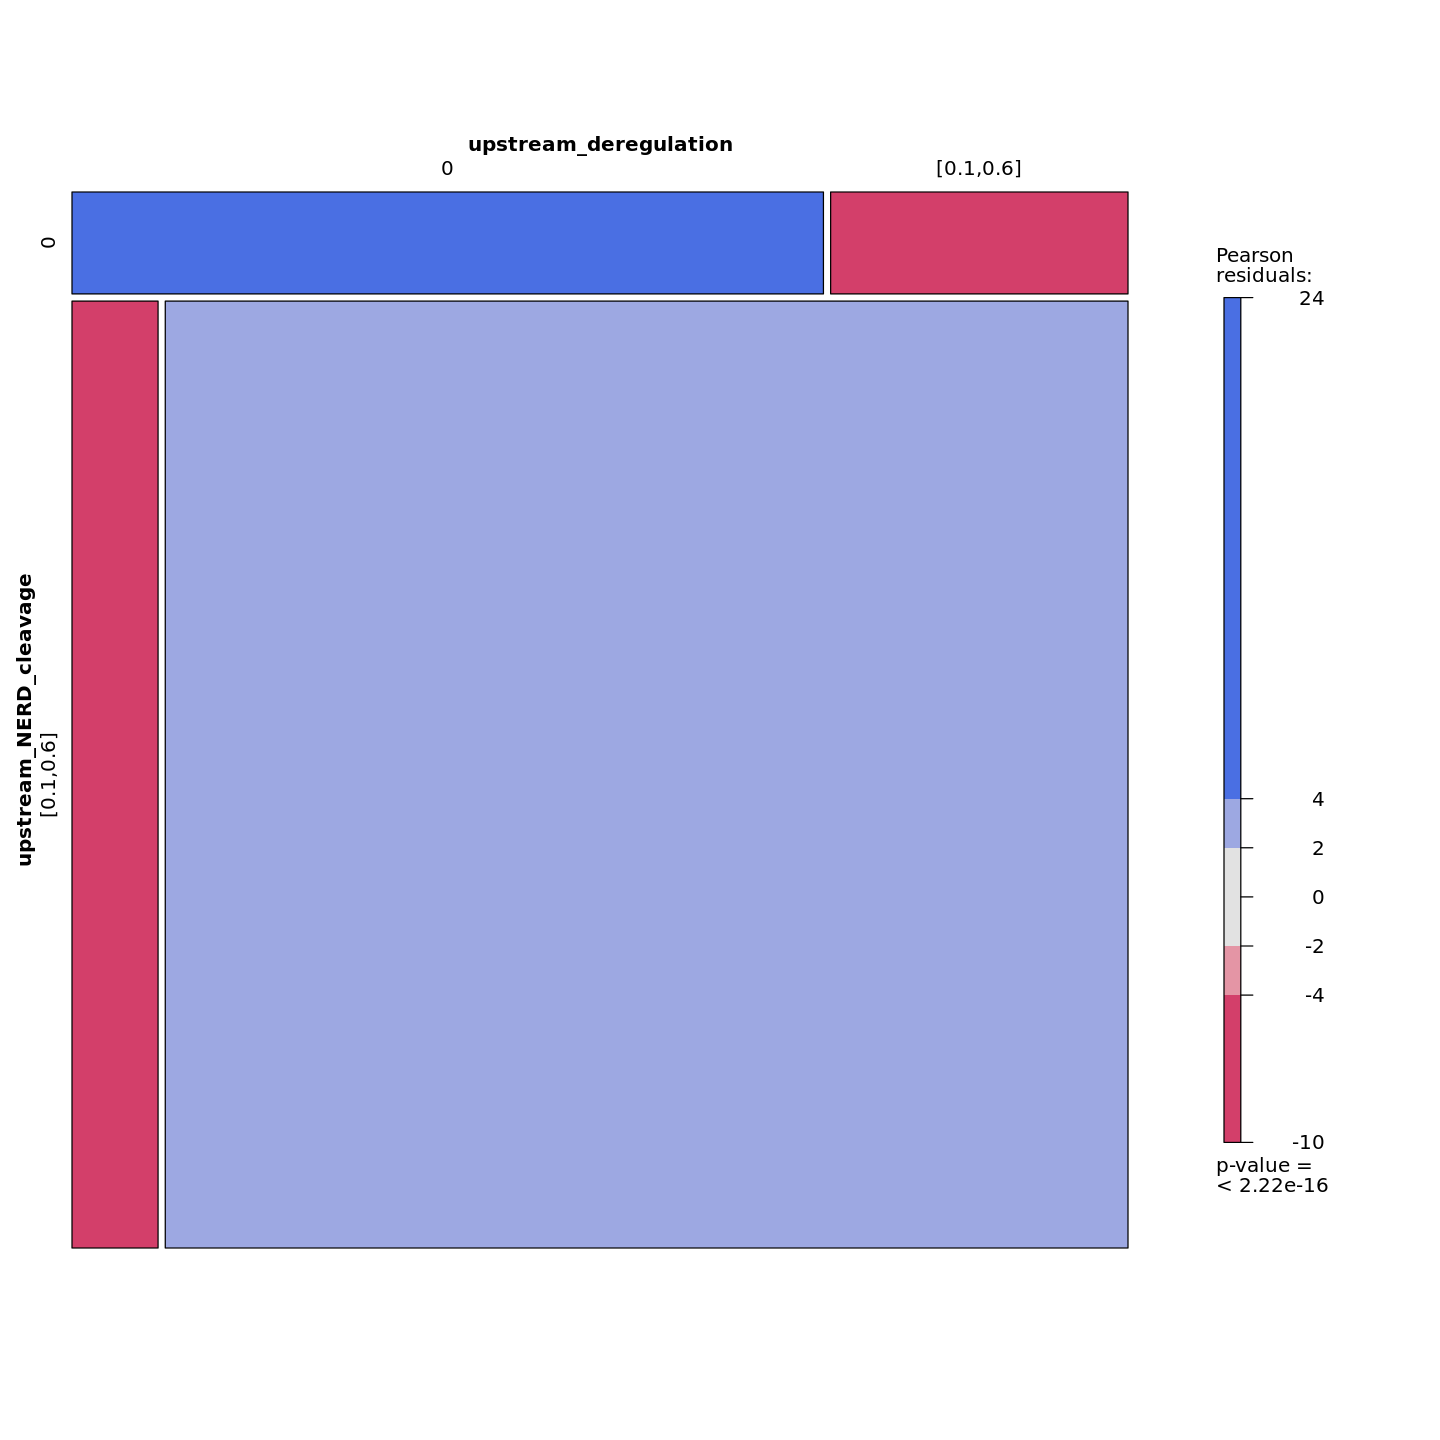

In [79]:
X=table(upstream_NERD_cleavage=PP1$p_direct_cut,upstream_deregulation=PP1$p_dereg_cut)
X
prop.table(X)
X=data.frame(X)
XX=xtabs(Freq~upstream_NERD_cleavage+upstream_deregulation,X)
options(repr.plot.width=12, repr.plot.height=12)
mosaic(XX, shade=TRUE, clegend=TRUE,legend_width=10,gp =shading_hcl)#, gp_args = list(h = c(130, 43), c = 100, l = c(90, 70))) 

## Deregulated targets - direct upstream regulon (up to order==3) 

In [80]:
PP3=droplevels(subset(PPP,order==3 & is_significant ==TRUE ))
nrow(PPP)
nrow(PP3)

[1] 61182

[1] 9084

In [81]:
x=cut(PP3$p_dereg_targets[PP3$p_dereg_targets>0],breaks=seq(min(PP3$p_dereg_targets[PP3$p_dereg_targets>0]),1,by=.5),right=TRUE,include.lowest=TRUE,dig.lab=1,ordered.result=TRUE)
PP3$p_dereg_cut=ordered(ifelse(PP3$p_dereg_targets>0,as.character(x),"0"),levels=c(0,levels(x)))
x=cut(PP3$p_direct_targets[PP3$p_direct_targets>0],breaks=seq(min(PP3$p_direct_targets[PP3$p_direct_targets>0]),1,by=.5),right=TRUE,include.lowest=TRUE,dig.lab=1,ordered.result=TRUE)
PP3$p_direct_cut=ordered(ifelse(PP3$p_direct_targets>0,as.character(x),"0"),levels=c(0,levels(x)))

                      upstream_deregulation
upstream_NERD_cleavage    0 [0.007,0.5]
           0            187         119
           [0.007,0.5]  318        5687

                      upstream_deregulation
upstream_NERD_cleavage          0 [0.007,0.5]
           0           0.02963080  0.01885597
           [0.007,0.5] 0.05038821  0.90112502

png 
  2

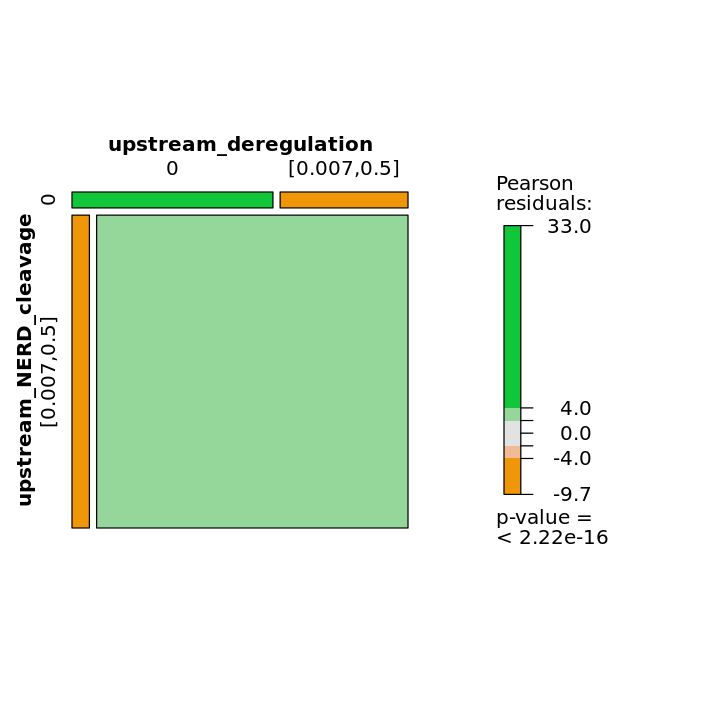

In [82]:
X=table(upstream_NERD_cleavage=PP3$p_direct_cut,upstream_deregulation=PP3$p_dereg_cut)
X
prop.table(X)
X=data.frame(X)
XX=xtabs(Freq~upstream_NERD_cleavage+upstream_deregulation,X)
options(repr.plot.width=6, repr.plot.height=6)
mosaic(XX, shade=TRUE, clegend=TRUE,legend_width=10,gp =shading_hcl, gp_args = list(h = c(130, 43), c = 100, l = c(90, 70))) 
pdf("chisq_test.impact.upstream_deregulation.deregulated_targets.pdf",width=6,height=6)
mosaic(XX, shade=TRUE, clegend=TRUE,legend_width=10,gp =shading_hcl, gp_args = list(h = c(130, 43), c = 100, l = c(90, 70))) 
dev.off()

                      upstream_deregulation
upstream_NERD_cleavage    0 [0.007,0.5]
           0            187         119
           [0.007,0.5]  318        5687

                      upstream_deregulation
upstream_NERD_cleavage          0 [0.007,0.5]
           0           0.02963080  0.01885597
           [0.007,0.5] 0.05038821  0.90112502

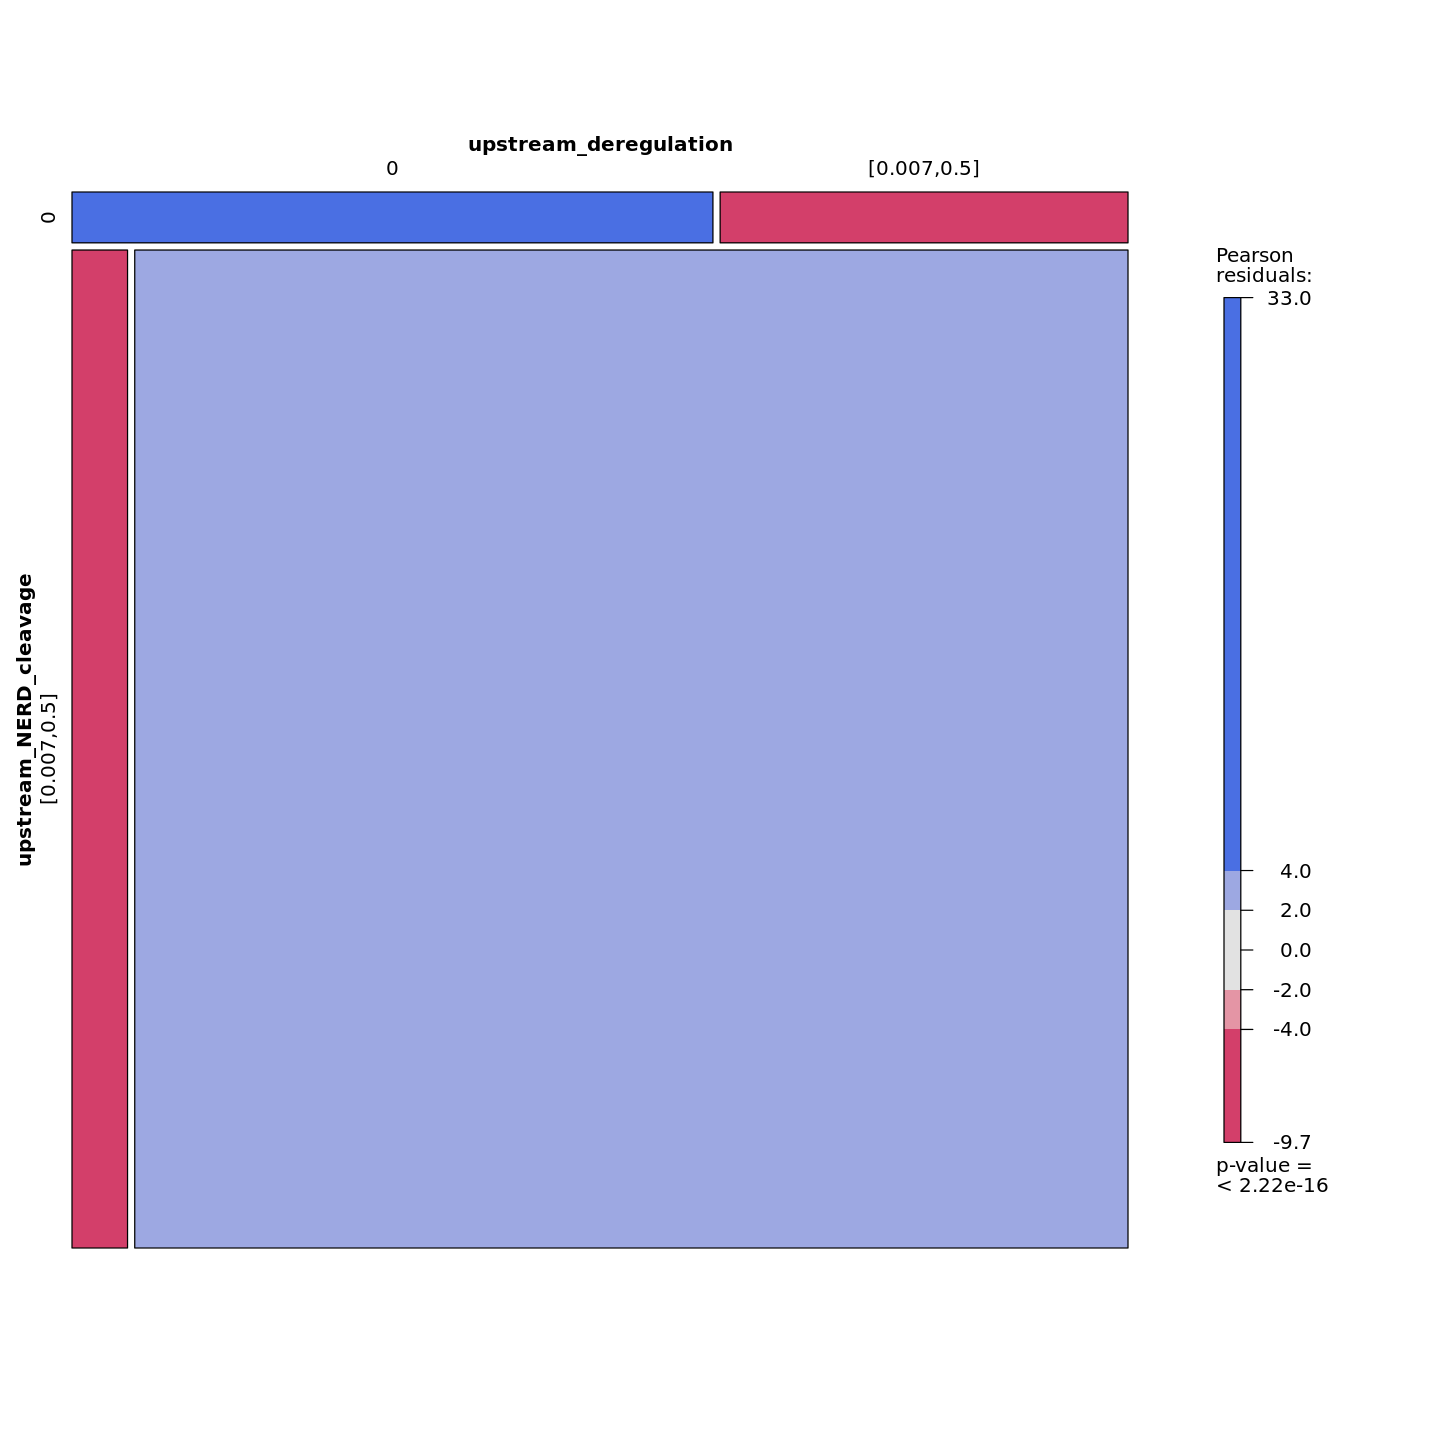

In [83]:
X=table(upstream_NERD_cleavage=PP3$p_direct_cut,upstream_deregulation=PP3$p_dereg_cut)
X
prop.table(X)
X=data.frame(X)
XX=xtabs(Freq~upstream_NERD_cleavage+upstream_deregulation,X)
options(repr.plot.width=12, repr.plot.height=12)
mosaic(XX, shade=TRUE, clegend=TRUE,legend_width=10,gp =shading_hcl)#, gp_args = list(h = c(130, 43), c = 100, l = c(90, 70))) 

In [84]:
info=function(ds) {
    X=ds %>% summarise(
        p_all_targets=summary(p_all_targets), 
        p_direct_targets=summary(p_direct_targets), 
        p_dereg_targets=summary(p_dereg_targets), 
                ) %>%
        t()  

    colnames(X)=names(summary(ds$p_all_targets))
    X
    }

In [85]:
info(PP1)

Min. 1st Qu.   Median    Mean      3rd Qu.   Max.
p_all_targets    0    0.7142857 0.8333333 0.8186256 1.0000000 1   
p_direct_targets 0    0.5000000 0.6666667 0.6381137 0.8000000 1   
p_dereg_targets  0    0.3333333 0.5000000 0.5218498 0.7142857 1

In [86]:
info(PP2)

Min. 1st Qu.   Median    Mean      3rd Qu.   Max.
p_all_targets    0    0.6000000 0.7272727 0.7044381 0.8484848 1   
p_direct_targets 0    0.3571429 0.5000000 0.4818266 0.6111111 1   
p_dereg_targets  0    0.2000000 0.3333333 0.3459763 0.4761905 1

In [87]:
info(PP3)

Min. 1st Qu.   Median    Mean      3rd Qu.   Max.
p_all_targets    0    0.5365854 0.6486486 0.6228570 0.7423071 1   
p_direct_targets 0    0.2727273 0.4050633 0.3909905 0.5111111 1   
p_dereg_targets  0    0.1328535 0.2244898 0.2391285 0.3260870 1

In [88]:
prop.table(table(PPP$order, sig=PPP$is_significant, dereg=PPP$p_dereg_targets>0.1),1)

, , dereg = FALSE

   sig
         FALSE       TRUE
  1 0.05545749 0.03138178
  2 0.11228793 0.05648720
  3 0.16039031 0.08502501

, , dereg = TRUE

   sig
         FALSE       TRUE
  1 0.49911739 0.41404335
  2 0.44228695 0.38893792
  3 0.39418456 0.36040012


In [89]:
prop.table(table(PP1$p_dereg_targets>0.05))
prop.table(table(PP2$p_dereg_targets>0.05))
prop.table(table(PP3$p_dereg_targets>0.05))


     FALSE       TRUE 
0.06924262 0.93075738 


     FALSE       TRUE 
0.08663584 0.91336416 


    FALSE      TRUE 
0.1298987 0.8701013 

In [90]:
prop.table(table(PP1$p_direct_targets>0.05))
prop.table(table(PP2$p_direct_targets>0.05))
prop.table(table(PP3$p_direct_targets>0.05))


     FALSE       TRUE 
0.03456627 0.96543373 


     FALSE       TRUE 
0.03731836 0.96268164 


     FALSE       TRUE 
0.05008807 0.94991193 

In [91]:
prop.table(table(PP1$p_all_targets>0.05))
prop.table(table(PP2$p_all_targets>0.05))
prop.table(table(PP3$p_all_targets>0.05))


     FALSE       TRUE 
0.02058565 0.97941435 


    FALSE      TRUE 
0.0209159 0.9790841 


     FALSE       TRUE 
0.02388815 0.97611185 

In [92]:
plot_trend=function(ds,tit,method="lm",max=100) {
ds %>% filter(community %in% subnetworks) %>%  
    select(geneid, effect_size,p_all_targets, p_dereg_targets,p_direct_targets) %>% 
    mutate_if(str_detect(names(.),"p_"),function(x) x*100) %>%
    rename ("direct or indirect"="p_all_targets","direct"="p_direct_targets","indirect"="p_dereg_targets") %>% 
    pivot_longer(-c(geneid,effect_size),names_to="targeting_type",values_to="percent_regulon") %>%
    ggplot(aes(x=percent_regulon,y=effect_size,colour=targeting_type)) +
              scale_colour_discrete(name="DEK1 targeting of upstream TFs") +
              geom_smooth(method=method) +
              xlab("% upstream regulon") +
              ylab("deregulation in mutants")+
              xlim(0,max) +
              ggtitle(tit)
}

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'



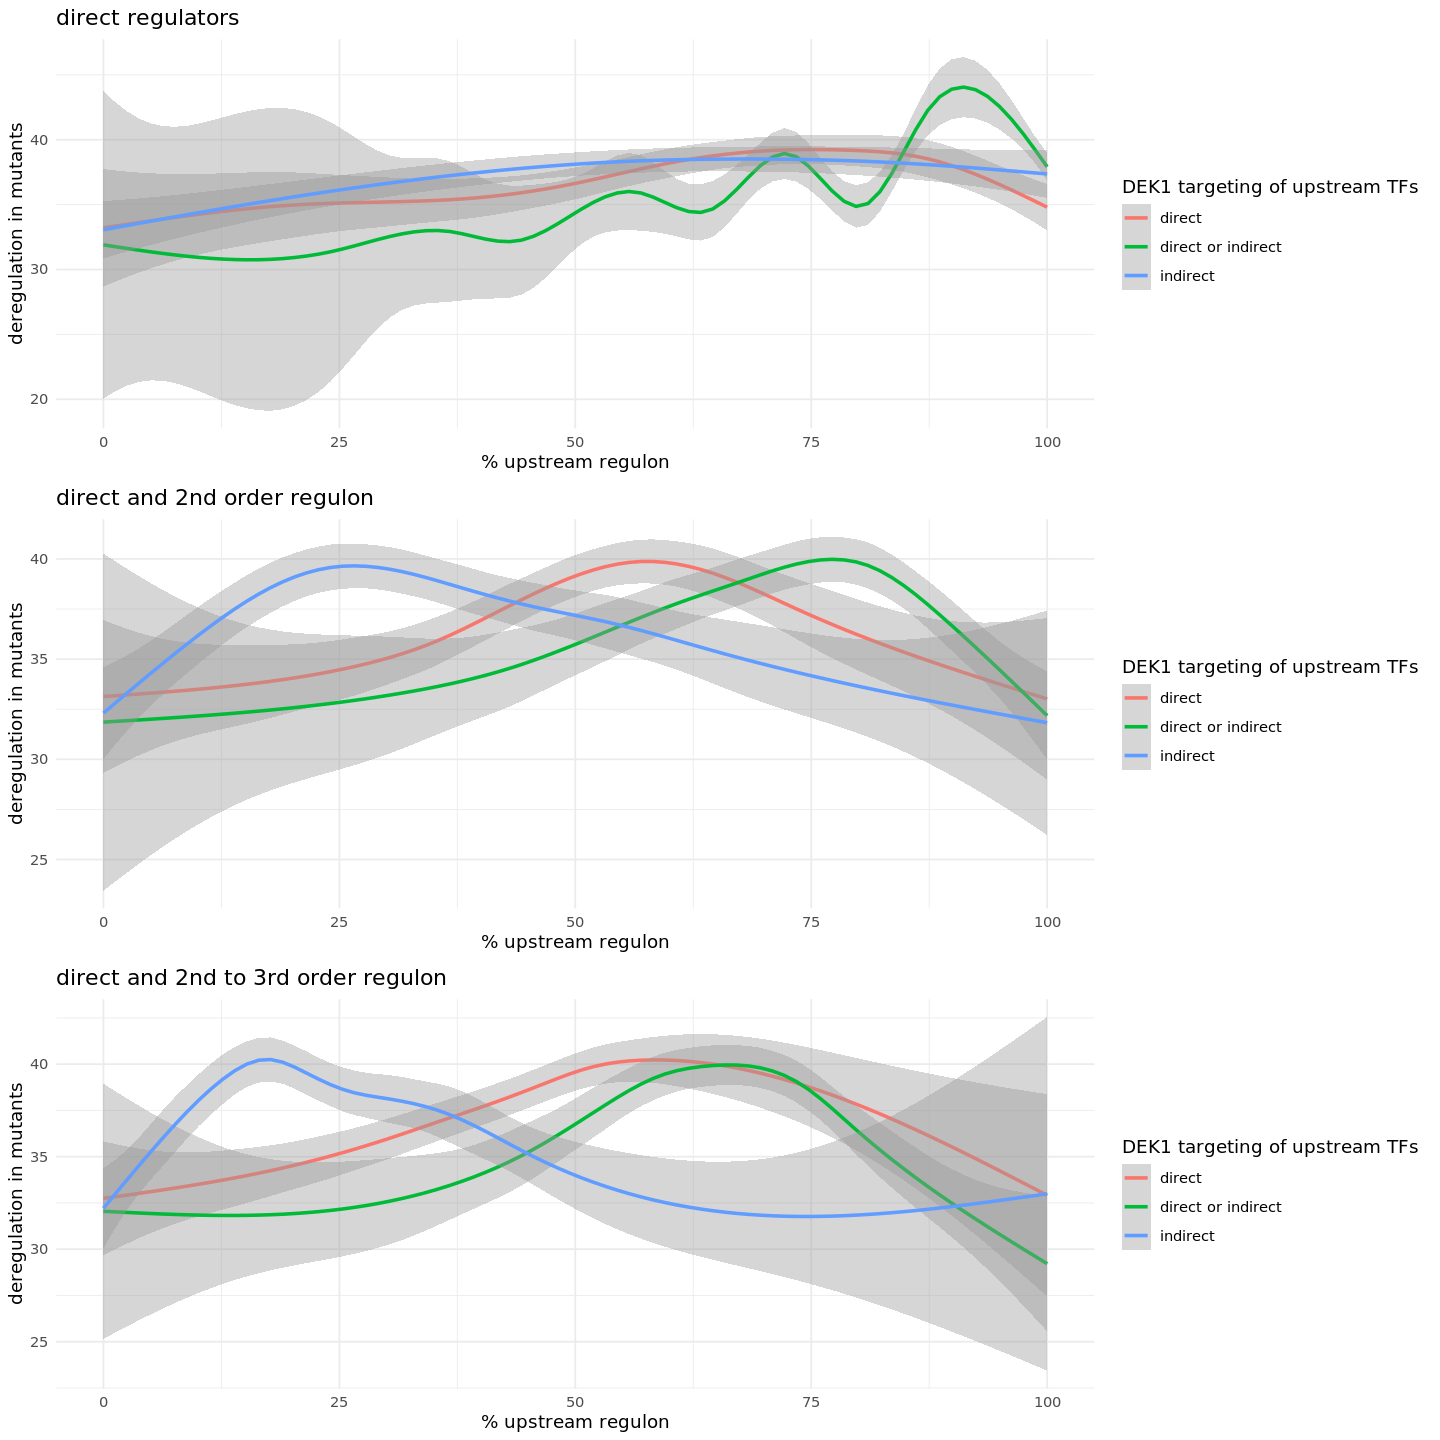

In [93]:
p1=plot_trend(PP1,"direct regulators","gam")
p2=plot_trend(PP2,"direct and 2nd order regulon","gam")
p3=plot_trend(PP3,"direct and 2nd to 3rd order regulon","gam")

grid.arrange(p1, p2,p3, nrow = 3)
              

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



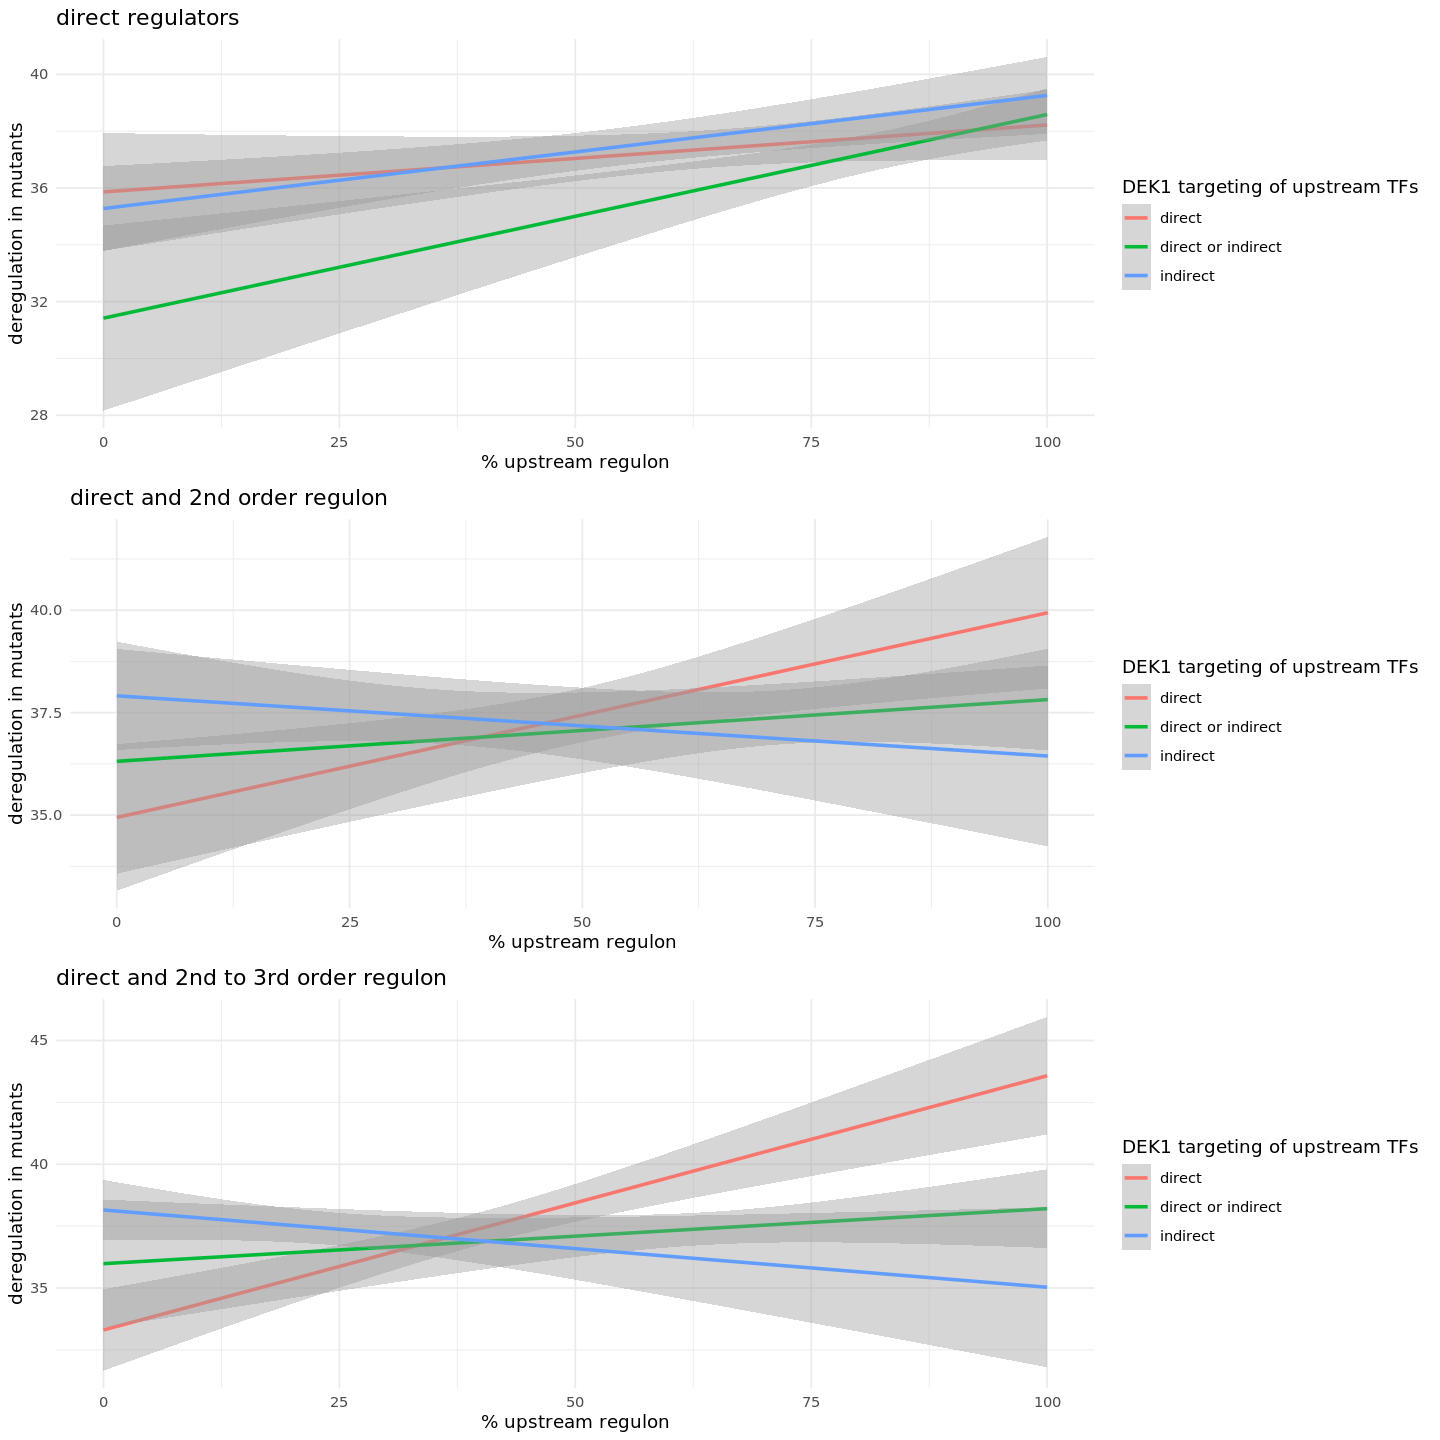

In [94]:
p1=plot_trend(PP1,"direct regulators")
p2=plot_trend(PP2,"direct and 2nd order regulon")
p3=plot_trend(PP3,"direct and 2nd to 3rd order regulon")

grid.arrange(p1, p2,p3, nrow = 3)
              

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



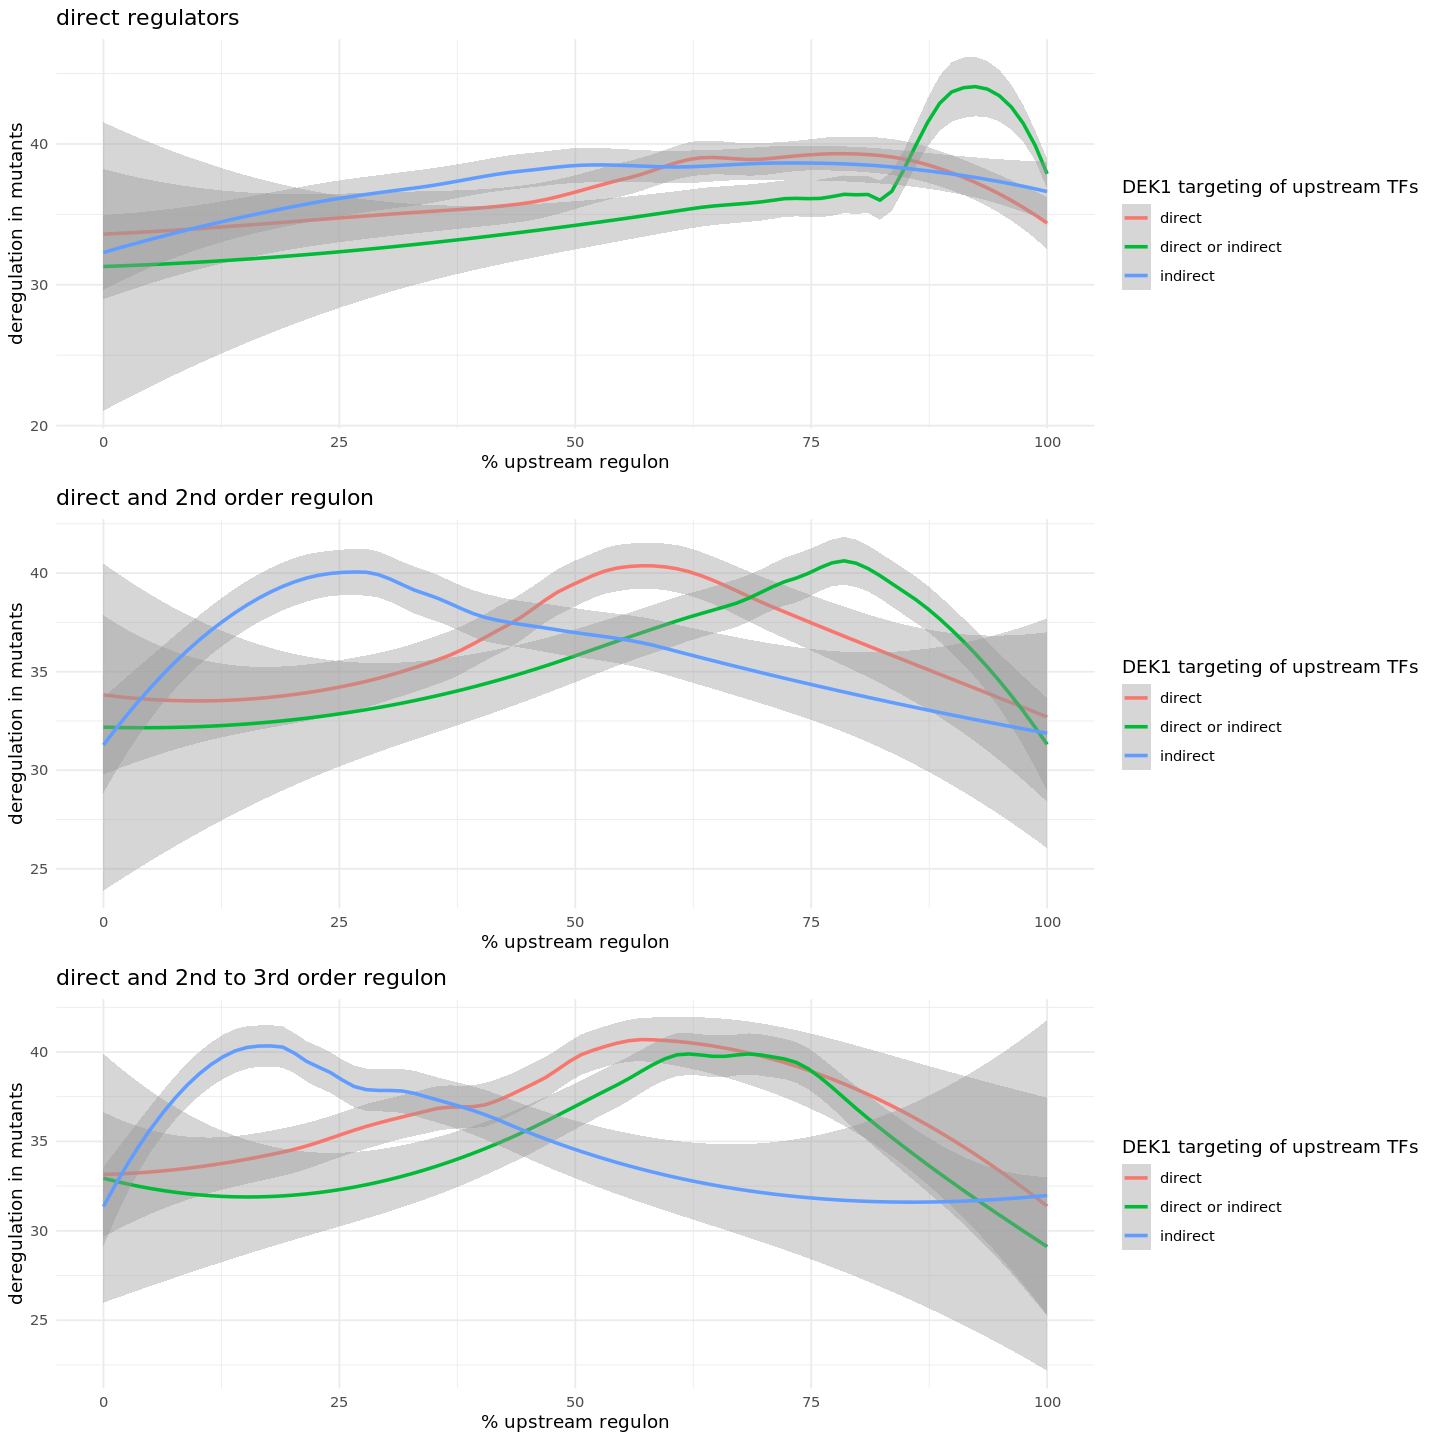

In [95]:
p1=plot_trend(PP1,"direct regulators","loess")
p2=plot_trend(PP2,"direct and 2nd order regulon","loess")
p3=plot_trend(PP3,"direct and 2nd to 3rd order regulon","loess")

grid.arrange(p1, p2,p3, nrow = 3)
              

`geom_smooth()` using formula 'y ~ x'



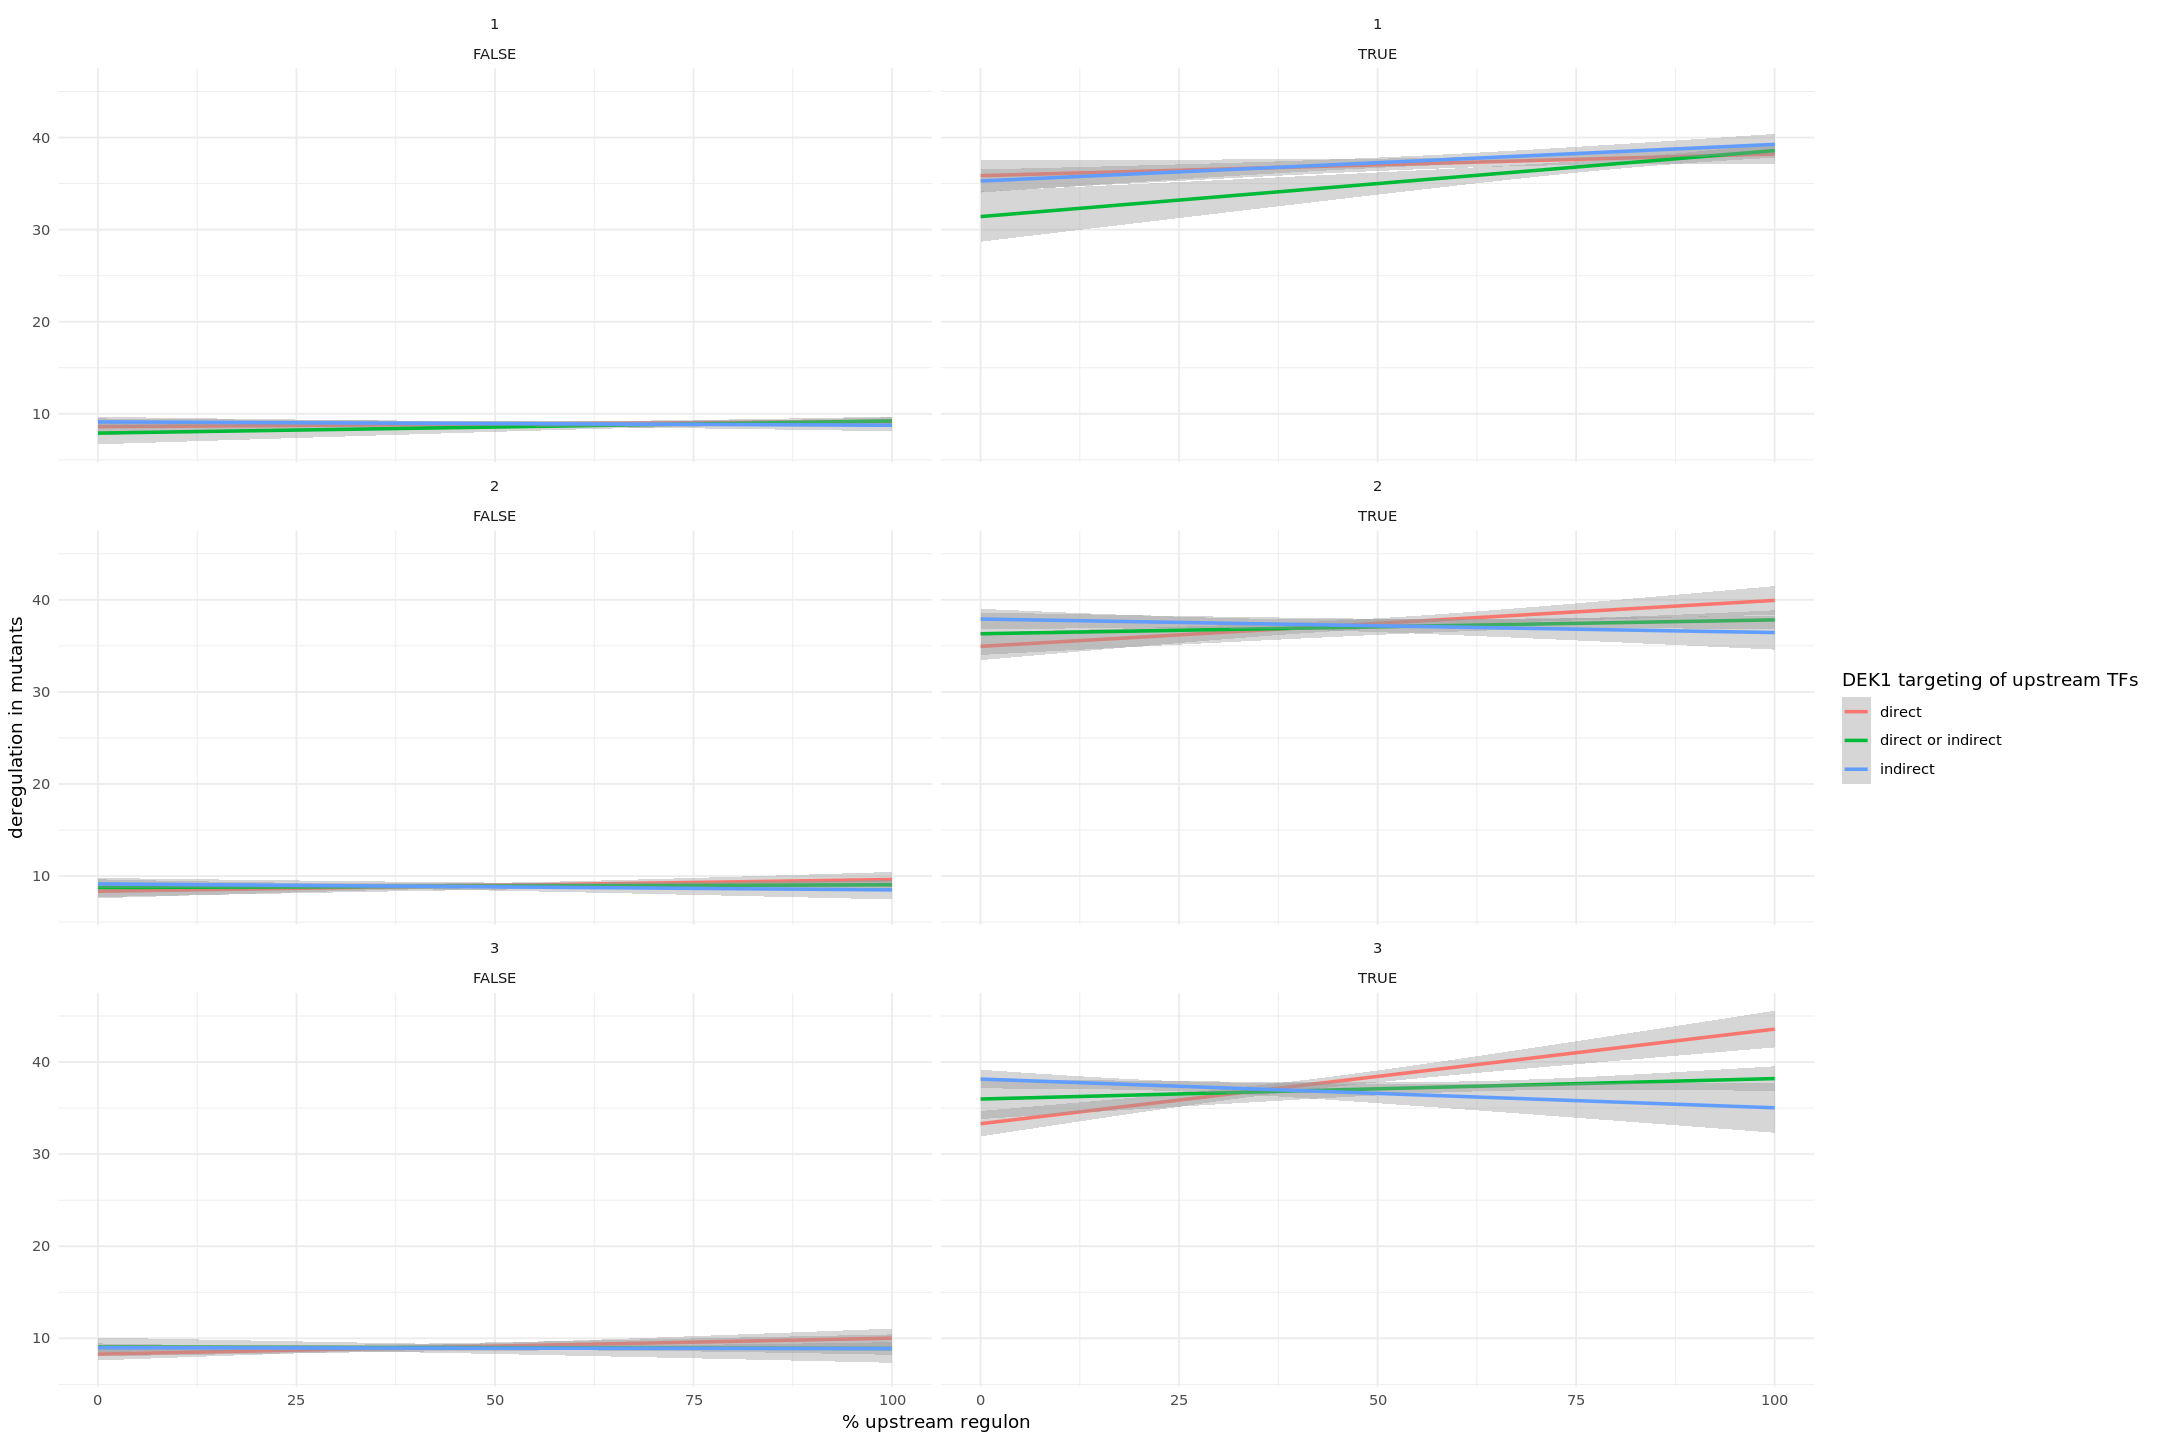

In [96]:

options(repr.plot.width=18, repr.plot.height=12)
max=100
method="glm"
PPP %>% filter(community %in% subnetworks) %>%  
    select(geneid, order, is_significant, effect_size,p_all_targets, p_dereg_targets,p_direct_targets) %>% 
    mutate_if(str_detect(names(.),"p_"),function(x) x*100) %>%
    rename ("direct or indirect"="p_all_targets","direct"="p_direct_targets","indirect"="p_dereg_targets") %>% 
    pivot_longer(-c(geneid,effect_size,is_significant,order),names_to="targeting_type",values_to="percent_regulon") %>%
    ggplot(aes(x=percent_regulon,y=effect_size,colour=targeting_type)) +
              scale_colour_discrete(name="DEK1 targeting of upstream TFs") +
              geom_smooth(method=method,level = 0.9) +
              facet_wrap(order~is_significant,ncol=2) +
              xlab("% upstream regulon") +
              ylab("deregulation in mutants")+
              xlim(0,max) 

In [115]:
cr=function(ds,target,method="kendall") print(cor.test(ds[[target]],ds[["effect_size"]],method=method))
cr(PP1,"p_direct_targets")
cr(PP1,"p_dereg_targets")
cr(PP1,"p_all_targets")


	Kendall's rank correlation tau

data:  ds[[target]] and ds[["effect_size"]]
z = 1.9043, p-value = 0.05688
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
0.01379275 


	Kendall's rank correlation tau

data:  ds[[target]] and ds[["effect_size"]]
z = 3.7958, p-value = 0.0001472
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.0273503 


	Kendall's rank correlation tau

data:  ds[[target]] and ds[["effect_size"]]
z = 3.1427, p-value = 0.001674
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
0.02356452 



In [98]:
cr=function(ds,target,method="kendall") print(cor.test(ds[[target]],ds[["effect_size"]],method=method))
cr(PP2,"p_direct_targets")
cr(PP2,"p_dereg_targets")
cr(PP2,"p_all_targets")


	Kendall's rank correlation tau

data:  ds[[target]] and ds[["effect_size"]]
z = 4.3111, p-value = 1.625e-05
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
0.03028774 


	Kendall's rank correlation tau

data:  ds[[target]] and ds[["effect_size"]]
z = 0.99526, p-value = 0.3196
alternative hypothesis: true tau is not equal to 0
sample estimates:
        tau 
0.006999736 


	Kendall's rank correlation tau

data:  ds[[target]] and ds[["effect_size"]]
z = 0.12115, p-value = 0.9036
alternative hypothesis: true tau is not equal to 0
sample estimates:
         tau 
0.0008517015 



In [99]:
cr=function(ds,target,method="kendall") print(cor.test(ds[[target]],ds[["effect_size"]],method=method))
cr(PP3,"p_direct_targets")
cr(PP3,"p_dereg_targets")
cr(PP3,"p_all_targets")


	Kendall's rank correlation tau

data:  ds[[target]] and ds[["effect_size"]]
z = 8.201, p-value = 2.383e-16
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
0.05745689 


	Kendall's rank correlation tau

data:  ds[[target]] and ds[["effect_size"]]
z = 0.56113, p-value = 0.5747
alternative hypothesis: true tau is not equal to 0
sample estimates:
        tau 
0.003937228 


	Kendall's rank correlation tau

data:  ds[[target]] and ds[["effect_size"]]
z = 0.33173, p-value = 0.7401
alternative hypothesis: true tau is not equal to 0
sample estimates:
        tau 
0.002323712 



In [100]:
cr=function(ds,target,method="pearson") print(cor.test(ds[[target]],ds[["effect_size"]],method=method))
cr(PP3 %>% filter(community %in% c("II","V","X")),"p_direct_targets")
cr(PP3 %>% filter(community %in% c("II","V","X")),"p_dereg_targets")
cr(PP3 %>% filter(community %in% c("II","V","X")),"p_all_targets")


	Pearson's product-moment correlation

data:  ds[[target]] and ds[["effect_size"]]
t = 4.139, df = 3887, p-value = 3.562e-05
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.03488364 0.09746942
sample estimates:
       cor 
0.06624168 


	Pearson's product-moment correlation

data:  ds[[target]] and ds[["effect_size"]]
t = 1.8656, df = 3887, p-value = 0.06217
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.00152159  0.06128356
sample estimates:
       cor 
0.02991051 


	Pearson's product-moment correlation

data:  ds[[target]] and ds[["effect_size"]]
t = 5.0971, df = 3887, p-value = 3.612e-07
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.05018184 0.11262621
sample estimates:
       cor 
0.08148398 



In [101]:
summary(step(glm(effect_size~p_direct_targets+p_dereg_targets+p_all_targets,data=subset(PP3,community %in% subnetworks))))

Start:  AIC=87081.2
effect_size ~ p_direct_targets + p_dereg_targets + p_all_targets

                   Df Deviance   AIC
- p_all_targets     1  9027150 87081
<none>                 9025757 87081
- p_dereg_targets   1  9027936 87081
- p_direct_targets  1  9054725 87108

Step:  AIC=87080.58
effect_size ~ p_direct_targets + p_dereg_targets

                   Df Deviance   AIC
<none>                 9027150 87081
- p_dereg_targets   1  9033717 87085
- p_direct_targets  1  9060146 87111



Call:
glm(formula = effect_size ~ p_direct_targets + p_dereg_targets, 
    data = subset(PP3, community %in% subnetworks))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-36.07  -18.54  -12.00    4.77  351.53  

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       34.2620     0.9198  37.251  < 2e-16 ***
p_direct_targets  11.2461     1.9694   5.710 1.16e-08 ***
p_dereg_targets   -5.5271     2.1697  -2.547   0.0109 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 1011.899)

    Null deviance: 9062323  on 8923  degrees of freedom
Residual deviance: 9027150  on 8921  degrees of freedom
AIC: 87081

Number of Fisher Scoring iterations: 2


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



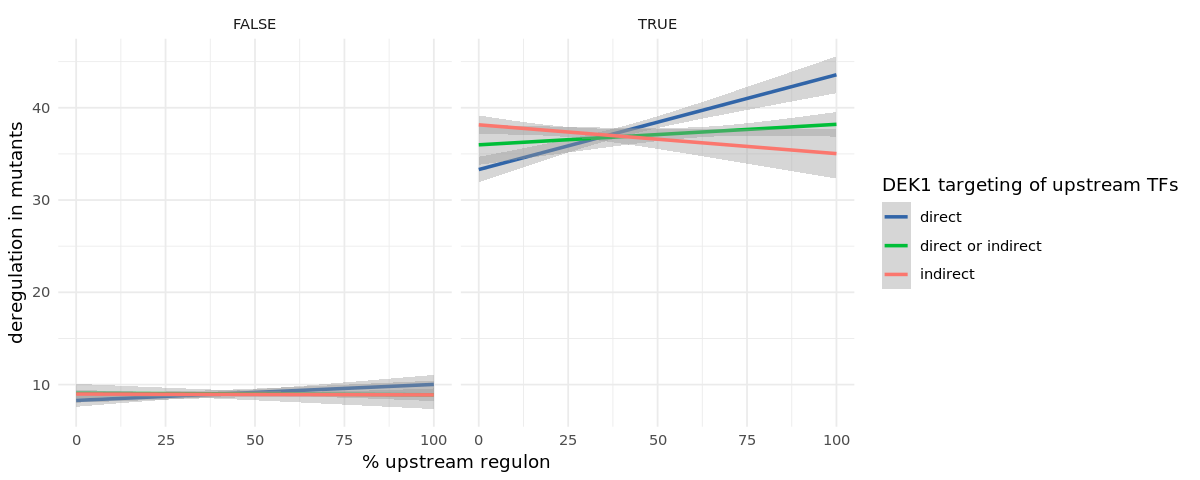

In [102]:
options(repr.plot.width=10, repr.plot.height=4)
g=PPP %>% filter(community %in% subnetworks & order == 3) %>%  
    select(geneid, order, is_significant, effect_size,p_all_targets, p_dereg_targets,p_direct_targets) %>% 
    mutate_if(str_detect(names(.),"p_"),function(x) x*100) %>%
    rename ("direct or indirect"="p_all_targets","direct"="p_direct_targets","indirect"="p_dereg_targets") %>% 
    pivot_longer(-c(geneid,effect_size,is_significant,order),names_to="targeting_type",values_to="percent_regulon") %>%
    ggplot(aes(x=percent_regulon,y=effect_size,colour=targeting_type)) +
              scale_colour_manual(name="DEK1 targeting of upstream TFs", values=c("#3165a8","#00be38","#fb776e")) +
              geom_smooth(method="glm",level = 0.9) +
              facet_wrap(~is_significant,ncol=2) +
              xlab("% upstream regulon") +
              ylab("deregulation in mutants")
g
ggsave(g,filename="dependency.target_effect_size.3rd_order_deregulation.pdf",width=12,height=5)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



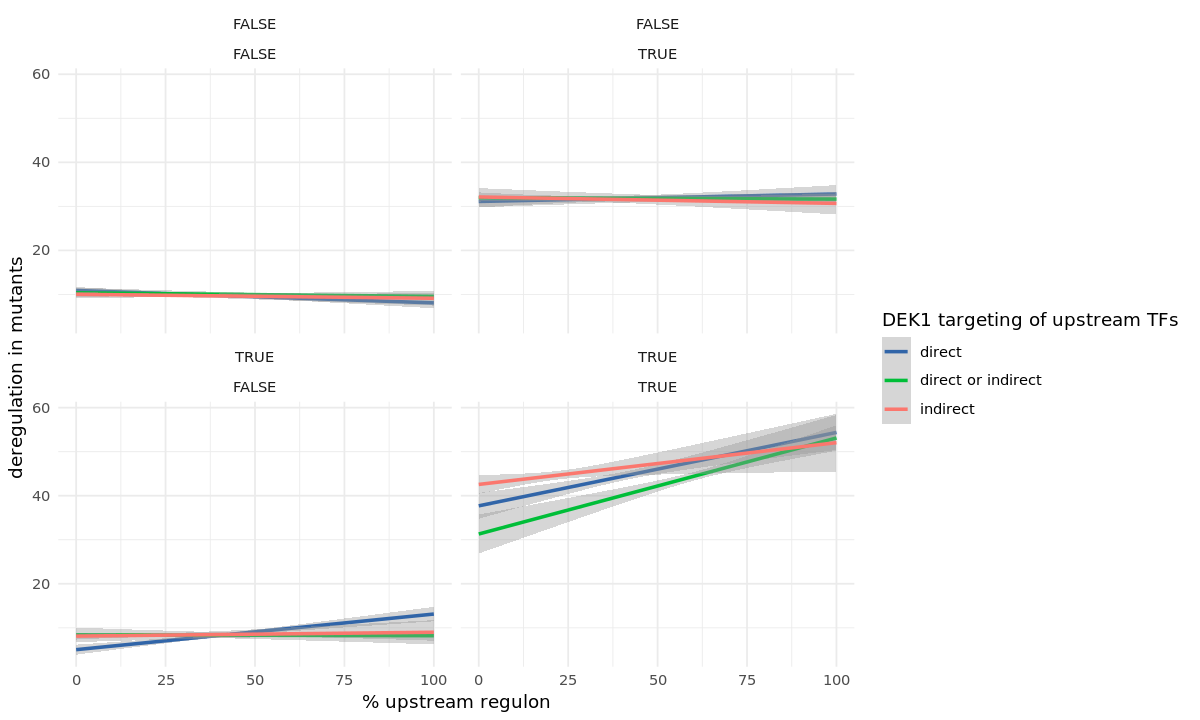

In [103]:
options(repr.plot.width=10, repr.plot.height=6)
g=PPP %>% filter(community %in% subnetworks & order == 3) %>%  
    mutate(NERD_enriched=community %in% c("II","V","X")) %>%
    select(geneid, order, NERD_enriched,is_significant, effect_size,p_all_targets, p_dereg_targets,p_direct_targets) %>% 
    mutate_if(str_detect(names(.),"p_"),function(x) x*100) %>%
    rename ("direct or indirect"="p_all_targets","direct"="p_direct_targets","indirect"="p_dereg_targets") %>% 
    pivot_longer(-c(geneid,effect_size,NERD_enriched,is_significant,order),names_to="targeting_type",values_to="percent_regulon") %>%
    ggplot(aes(x=percent_regulon,y=effect_size,colour=targeting_type)) +
              scale_colour_manual(name="DEK1 targeting of upstream TFs", values=c("#3165a8","#00be38","#fb776e")) +
              geom_smooth(method="glm",level = 0.9) +
              facet_wrap(NERD_enriched~is_significant,ncol=2) +
              xlab("% upstream regulon") +
              ylab("deregulation in mutants")
g
ggsave(g,filename="dependency.target_effect_size.3rd_order_deregulation.NERD_enriched_subnetworks_is_significant.pdf",width=10,height=6)

### Target ~ TF deregulation

In [104]:
table(a$community)


    0    II    IX     V  VIII     X 
45045 17231 16298 10140 13935 14636 

In [105]:
A=inner_join(a, P %>% select(geneid, effect_size,is_significant),by=c("targetGene"="geneid")) %>%
    rename("target_deregulation"="effect_size","target_significant"="is_significant") %>%
    inner_join(.,P %>% select(geneid,effect_size,is_significant,
                              sites_rel,tertiary_deaminated_rel,tertiary_oxidized_or_acetylated_rel,secondary_ATE_rel,
                              secondary_peptidase_rel,primary_acetylated_rel),by=c("regulatoryGene"="geneid")) %>%
    rename("TF_deregulation"="effect_size","TF_significant"="is_significant") 
head(A)

regulatoryGene   targetGene                 full_cor   full_reg our_cor      
1 Pp3c4_31920.mRNA Pp3c13_21080.mRNA           0.1577695 +        -4.337281e-16
2 Pp3c4_350.mRNA   Pp3c3_28370.C_D_box_snoRNA  1.0000000 +         1.000000e+00
3 Pp3c12_10.mRNA   Pp3c1_12760.mRNA           -0.1279099 -         1.873743e-15
4 Pp3c1_21610.mRNA Pp3s178_40.mRNA             0.2570535 +         2.713689e-16
5 Pp3c1_32440.mRNA Pp3c7_19620.mRNA            0.7938397 +         6.887235e-01
6 Pp3c2_9700.mRNA  Pp3c5_14180.mRNA            0.1967969 +        -2.155251e-15
  our_reg weight     regulator_rank target_rank mutual_rank ⋯
1 -       0.06337407 1              1           1           ⋯
2 +       0.05976139 1              1           1           ⋯
3 +       0.05927444 1              1           1           ⋯
4 +       0.05903109 1              1           1           ⋯
5 +       0.05734152 1              1           1           ⋯
6 -       0.05491606 1              1           1           ⋯
  target_deregulation target_significant TF_deregulation TF_significant
1 0.000000            FALSE              51.032238        TRUE         
2 0.000000            FALSE               0.000000       FALSE         
3 0.000000            FALSE              17.424235       FALSE         
4 0.000000            FALSE               0.000000       FALSE         
5 1.064409            FALSE              15.490770        TRUE         
6 0.000000            FALSE               5.020095       FALSE         
  sites_rel  tertiary_deaminated_rel tertiary_oxidized_or_acetylated_rel
1 0.08977556 0.009975062             0.0000                             
2 0.01960784 0.000000000             0.0000                             
3 0.07268170 0.005012531             0.0000                             
4 0.05500000 0.007500000             0.0025                             
5 0.07531381 0.004184100             0.0000                             
6 0.07894737 0.015037594             0.0000                             
  secondary_ATE_rel secondary_peptidase_rel primary_acetylated_rel
1 0.004987531       0.01745636              0.05236908            
2 0.000000000       0.01960784              0.00000000            
3 0.001253133       0.01127820              0.05012531            
4 0.002500000       0.01000000              0.03250000            
5 0.004184100       0.00418410              0.05020921            
6 0.005639098       0.01879699              0.03195489

`geom_smooth()` using formula 'y ~ x'



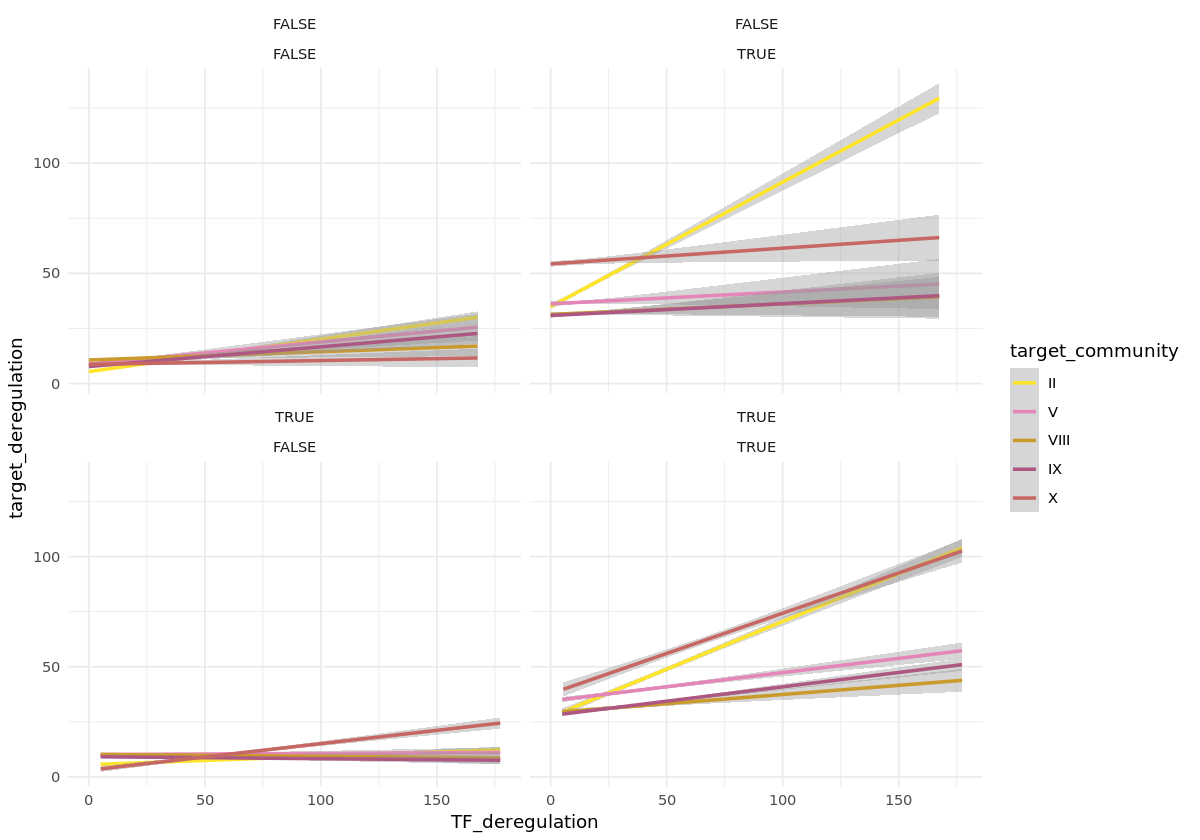

In [106]:
options(repr.plot.width=10, repr.plot.height=7)
ggplot(A, aes(x=TF_deregulation,y=target_deregulation,colour=target_community)) +
    geom_smooth(method="glm") + facet_wrap(TF_significant~target_significant) + 
    scale_colour_manual(values=col2)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



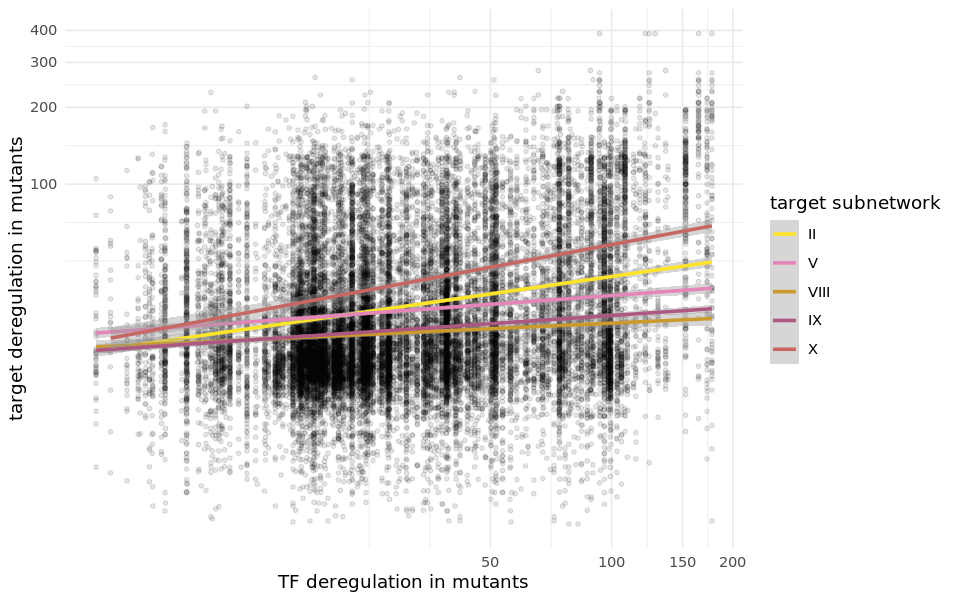

In [107]:
options(repr.plot.width=8, repr.plot.height=5)
g=A %>% filter(TF_significant==TRUE & target_significant==TRUE & target_deregulation>0 & TF_deregulation>0) %>%
ggplot(., 
       aes(x=TF_deregulation,y=target_deregulation,colour=target_community)) +
    geom_point(alpha=1/10,size=1,color="black") +
    geom_smooth(method="glm") + 
    scale_colour_manual(values=col2,name="target subnetwork") + 
    scale_x_continuous( trans="pseudo_log") + scale_y_continuous(trans="pseudo_log") +
    xlab("TF deregulation in mutants") +
    ylab("target deregulation in mutants") 
g
ggsave(g,filename="relationship.TF-target.deregulation.target_subnetworks.pdf",width=8,height=5)

In [108]:
summary(glm(target_deregulation~TF_deregulation*target_community+0,data=A))


Call:
glm(formula = target_deregulation ~ TF_deregulation * target_community + 
    0, data = A)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-49.96  -19.04   -6.42    5.82  362.50  

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)    
TF_deregulation                       0.168260   0.004700  35.802  < 2e-16 ***
target_communityII                   15.322727   0.225879  67.836  < 2e-16 ***
target_communityV                    21.626081   0.304484  71.025  < 2e-16 ***
target_communityVIII                 18.745000   0.266049  70.457  < 2e-16 ***
target_communityIX                   19.891906   0.242987  81.864  < 2e-16 ***
target_communityX                    19.754170   0.254042  77.759  < 2e-16 ***
TF_deregulation:target_communityV    -0.066215   0.009507  -6.965  3.3e-12 ***
TF_deregulation:target_communityVIII -0.130351   0.010758 -12.117  < 2e-16 ***
TF_deregulation:target_communityIX   -0.089384   0.008580 -10.417  < 2e-

In [109]:
cor.test(A$target_deregulation,A$TF_deregulation,method="kendall")


	Kendall's rank correlation tau

data:  A$target_deregulation and A$TF_deregulation
z = 31.564, p-value < 2.2e-16
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
0.06400298 


In [110]:
cor.test(A$target_deregulation,A$TF_deregulation,method="pearson")


	Pearson's product-moment correlation

data:  A$target_deregulation and A$TF_deregulation
t = 45.895, df = 117283, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1271993 0.1384435
sample estimates:
      cor 
0.1328256 


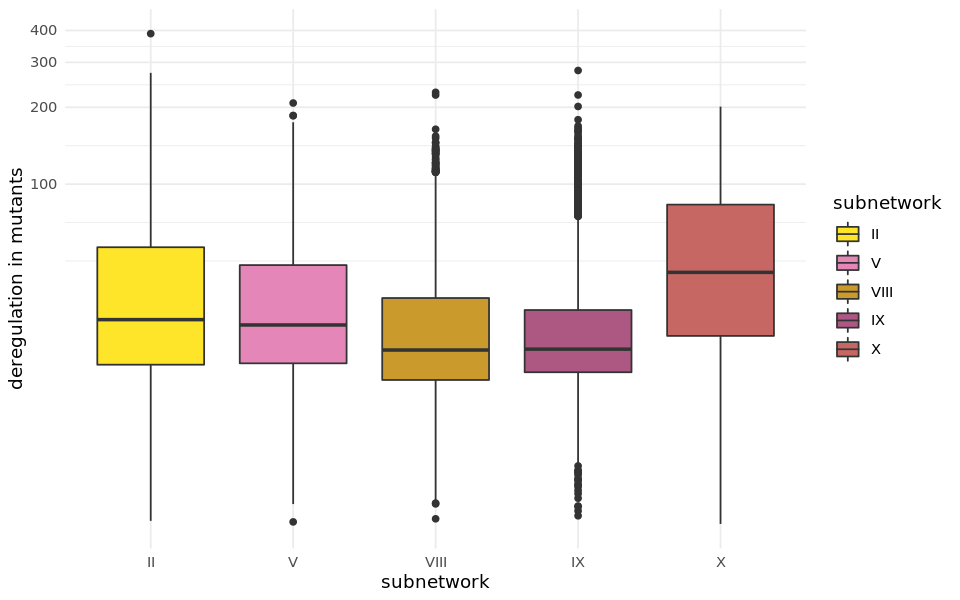

In [111]:
g=P %>% filter(is_significant & community %in% subnetworks) %>%
ggplot(aes(y=effect_size,x=community,fill=community)) + 
geom_boxplot() +
scale_fill_manual(name="subnetwork",values=col2) + 
scale_y_continuous(trans="pseudo_log") +
ylab("deregulation in mutants")  +
xlab("subnetwork")
g
ggsave(g,filename="deregulation_effect_size.target_subnetworks.pdf",width=8,height=5)

In [112]:
P %>% filter(is_significant & community %in% subnetworks) %>% group_by(community) %>% 
summarise(median_effect_size=median(effect_size),mean=mean(effect_size)) %>% arrange(median_effect_size)

`summarise()` ungrouping output (override with `.groups` argument)



community median_effect_size mean    
1 VIII      22.36221           31.80023
2 IX        22.54164           31.73974
3 V         28.05879           38.16212
4 II        29.44260           46.18691
5 X         45.11861           57.62695

In [113]:
PPX=PPP
x=cut(PPX$p_dereg_targets[PPX$p_dereg_targets>0],breaks=seq(min(PPX$p_dereg_targets[PPX$p_dereg_targets>0]),1,by=.5),right=TRUE,include.lowest=TRUE,dig.lab=1,ordered.result=TRUE)
PPX$p_dereg_cut=ordered(ifelse(PPX$p_dereg_targets>0,as.character(x),"0"),levels=c(0,levels(x)))
x=cut(PPX$p_direct_targets[PPX$p_direct_targets>0],breaks=seq(min(PPX$p_direct_targets[PPX$p_direct_targets>0]),1,by=.5),right=TRUE,include.lowest=TRUE,dig.lab=1,ordered.result=TRUE)
PPX$p_direct_cut=ordered(ifelse(PPX$p_direct_targets>0,as.character(x),"0"),levels=c(0,levels(x)))

, , upstream_deregulation = 0

     upstream_NERD_cleavage
order     0 [0.007,0.5]
    1   379         357
    2   379         718
    3   379         987

, , upstream_deregulation = [0.005,0.5]

     upstream_NERD_cleavage
order     0 [0.007,0.5]
    1   136        2994
    2   198        8316
    3   224       13067


, , upstream_deregulation = 0

     upstream_NERD_cleavage
order          0 [0.007,0.5]
    1  1.3471245   1.2689273
    2  1.3471245   2.5520722
    3  1.3471245   3.5082107

, , upstream_deregulation = [0.005,0.5]

     upstream_NERD_cleavage
order          0 [0.007,0.5]
    1  0.4834009  10.6419279
    2  0.7037748  29.5585413
    3  0.7961897  46.4455819


png 
  2

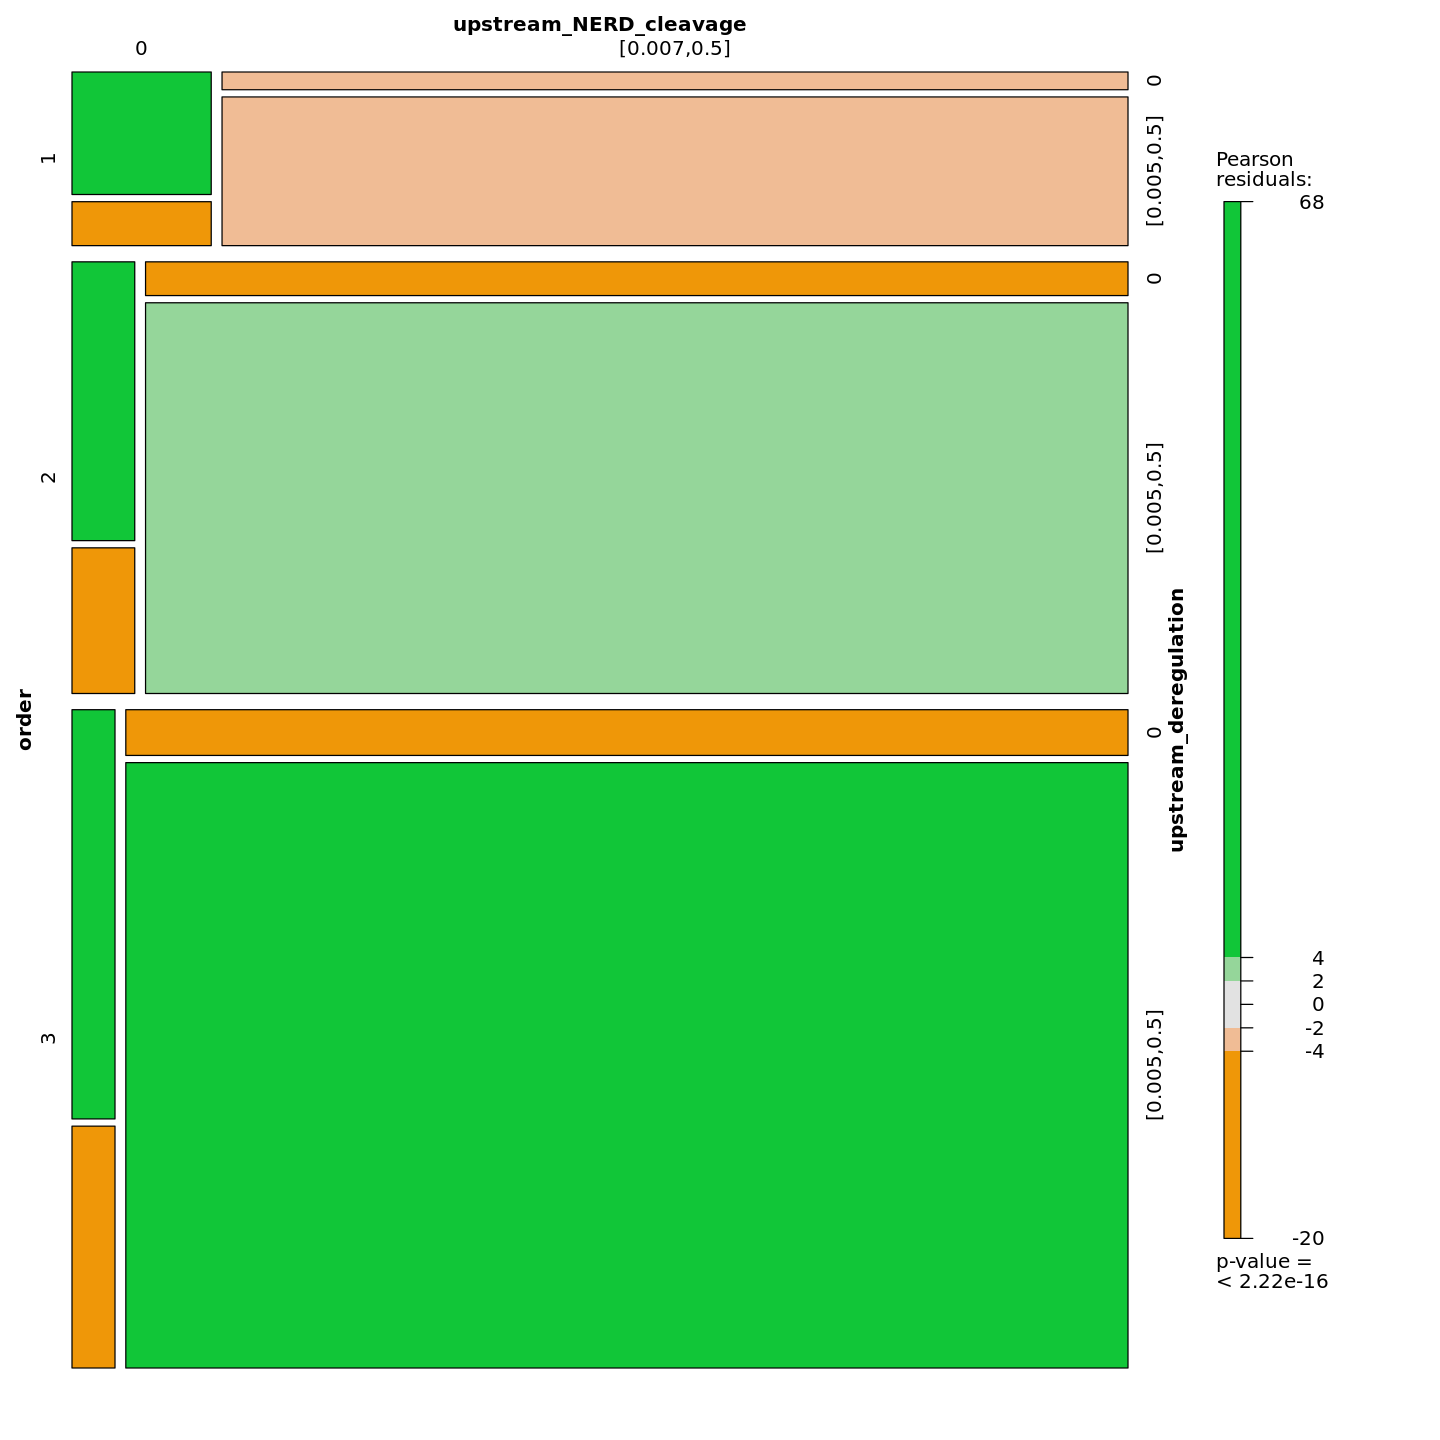

In [114]:
X=table(order=PPX$order,upstream_NERD_cleavage=PPX$p_direct_cut,upstream_deregulation=PPX$p_dereg_cut)
X
prop.table(X)*100
X=data.frame(X)
XX=xtabs(Freq~order+upstream_NERD_cleavage+upstream_deregulation,X)
options(repr.plot.width=12, repr.plot.height=12)
mosaic(XX, shade=TRUE, clegend=TRUE,legend_width=10,gp =shading_hcl, gp_args = list(h = c(130, 43), c = 100, l = c(90, 70))) 
pdf("chisq_test.impact.order.upstream_deregulation.deregulated_targets.pdf",width=12,height=12)
mosaic(XX, shade=TRUE, clegend=TRUE,legend_width=10,gp =shading_hcl, gp_args = list(h = c(130, 43), c = 100, l = c(90, 70))) 
dev.off()